### Kelompok Alfaith

| Nama Anggota      |
|-------------------|
| Fauzan Ahsanudin Alfikri       |
| Muhammad Fikri Hanif       |
| Farrel Faruqh Effendi          |


# IMPORT DATASET

In [1]:
# Install necessary libraries
!pip install gdown

import gdown
import zipfile
import os

# Google Drive file ID
file_id = '1UgGFM_SFwHELqYr43BOFHA9TGfl5QuS9'
output_path = 'archive.zip'

# Download the file from Google Drive
print(f"Downloading file with ID: {file_id}")
try:
    gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)
    print(f"Downloaded to {output_path}")
except Exception as e:
    print(f"Error downloading file: {e}")
    # Exit if download failed
    exit()


# Try to extract the zip file
print(f"Trying to extract {output_path}")
try:
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        # Check if password protected
        if zip_ref.testzip() is not None:
            print("The zip file is password protected. I cannot uncrack it without the password.")
        else:
            zip_ref.extractall("extracted_content")
            print("File extracted successfully to 'extracted_content/'")
except zipfile.BadZipFile:
    print("Error: The downloaded file is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Clean up the downloaded zip file
# os.remove(output_path)
# print(f"Removed downloaded file: {output_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1UgGFM_SFwHELqYr43BOFHA9TGfl5QuS9
From (redirected): https://drive.google.com/uc?id=1UgGFM_SFwHELqYr43BOFHA9TGfl5QuS9&confirm=t&uuid=931b0454-31f2-4ec2-920e-08821d1367a9
To: /content/archive.zip
100%|██████████| 268M/268M [00:05<00:00, 45.8MB/s]


Downloaded to archive.zip
Trying to extract archive.zip
File extracted successfully to 'extracted_content/'


# PREPOCESSING DATASET

In [2]:
import os
import json
import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
import os
import cv2
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from scipy.spatial import KDTree
import torch.nn.functional as F

class CrowdDataset(Dataset):
    def __init__(self, img_dir, json_dir, target_size=(256,256),
                 use_crop=True, multi_scale=True, num_crops=4,
                 preload_annotations=True, min_sigma=2, max_sigma=8):
        self.img_dir = img_dir
        self.json_dir = json_dir
        self.target_size = target_size
        self.use_crop = use_crop
        self.multi_scale = multi_scale
        self.num_crops = num_crops
        self.min_sigma = min_sigma
        self.max_sigma = max_sigma

        # image & json
        valid_ext = [".jpg", ".jpeg", ".png", ".bmp"]
        self.img_files = sorted([f for f in os.listdir(img_dir) if os.path.splitext(f)[1].lower() in valid_ext])
        self.json_files = sorted([f for f in os.listdir(json_dir) if f.endswith(".json")])
        assert len(self.img_files) == len(self.json_files), \
            f"Jumlah image ({len(self.img_files)}) dan JSON ({len(self.json_files)}) tidak sama!"

        # indices per crop
        self.indices = []
        for i in range(len(self.img_files)):
            for c in range(self.num_crops if self.use_crop else 1):
                self.indices.append((i, c))

        # transform
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        # preload annotations
        self.anns = []
        if preload_annotations:
            for jf in self.json_files:
                with open(os.path.join(json_dir, jf), 'r') as f:
                    ann = json.load(f)
                pts = [(p["x"], p["y"]) for p in ann.get("points", [])]
                self.anns.append(pts)
        else:
            self.anns = [None] * len(self.json_files)

        # pooling kernel
        self.pool_kernel = torch.ones((1,1,8,8), dtype=torch.float32)
        self.pool_stride = 8

        # kernel cache
        self.kernel_cache = {}

    def __len__(self):
        return len(self.indices)

    def _compute_sigmas(self, points, h, w):
        if len(points) == 0:
            return np.array([], dtype=np.float32)
        pts_arr = np.array(points, dtype=np.float32)
        if len(points) > 3:
            tree = KDTree(pts_arr)
            k = min(4, len(points))
            distances, _ = tree.query(pts_arr, k=k)
            if k > 1:
                neighbor = distances[:, 1:]
                sigmas = np.mean(neighbor, axis=1) * 0.3
            else:
                sigmas = np.full(len(points), max(self.min_sigma, min(self.max_sigma, np.mean([h,w]) / 50.0)))
        else:
            sigmas = np.full(len(points), max(self.min_sigma, min(self.max_sigma, np.mean([h,w]) / 50.0)))
        sigmas = np.clip(sigmas, self.min_sigma, self.max_sigma)
        return sigmas

    def _render_density_local_kernels(self, h, w, points):
        density = np.zeros((h, w), dtype=np.float32)
        if len(points) == 0:
            return density

        sigmas = self._compute_sigmas(points, h, w)
        for (x, y), sigma in zip(points, sigmas):
            if sigma <= 0:
                continue
            cx, cy = int(round(x)), int(round(y))
            radius = int(np.ceil(3 * sigma))
            key = int(round(sigma*100))

            kernel = self.kernel_cache.get(key)
            if kernel is None:
                ax = np.arange(-radius, radius+1, dtype=np.float32)
                xx, yy = np.meshgrid(ax, ax)
                kernel = np.exp(-(xx**2 + yy**2)/(2*sigma**2))
                s = kernel.sum()
                if s>0:
                    kernel /= s
                self.kernel_cache[key] = kernel

            # bounds
            x1, x2 = cx-radius, cx+radius+1
            y1, y2 = cy-radius, cy+radius+1
            kx1, ky1 = 0 if x1>=0 else -x1, 0 if y1>=0 else -y1
            kx2 = kernel.shape[1] if x2<=w else kernel.shape[1]-(x2-w)
            ky2 = kernel.shape[0] if y2<=h else kernel.shape[0]-(y2-h)
            dst_x1, dst_x2 = max(x1,0), min(x2,w)
            dst_y1, dst_y2 = max(y1,0), min(y2,h)

            patch_density = density[dst_y1:dst_y2, dst_x1:dst_x2]
            patch_kernel = kernel[ky1:ky2, kx1:kx2]
            h_min = min(patch_density.shape[0], patch_kernel.shape[0])
            w_min = min(patch_density.shape[1], patch_kernel.shape[1])
            if h_min>0 and w_min>0:
                density[dst_y1:dst_y1+h_min, dst_x1:dst_x1+w_min] += patch_kernel[:h_min,:w_min]

        return density

    def __getitem__(self, idx):
        img_idx, crop_id = self.indices[idx]

        img_path = os.path.join(self.img_dir, self.img_files[img_idx])
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img.shape[:2]

        if self.anns[img_idx] is not None:
            points = list(self.anns[img_idx])
        else:
            with open(os.path.join(self.json_dir, self.json_files[img_idx]), 'r') as f:
                ann = json.load(f)
            points = [(p["x"], p["y"]) for p in ann.get("points", [])]

        # multi-scale
        if self.multi_scale:
            scale_factor = float(np.random.uniform(0.7,1.3))
            img = cv2.resize(img, (int(orig_w*scale_factor), int(orig_h*scale_factor)))
            points = [(x*scale_factor, y*scale_factor) for x,y in points]
            orig_h, orig_w = img.shape[:2]

        # fit ke canvas 640x360
        target_h, target_w = 360, 640
        canvas = np.zeros((target_h, target_w,3), dtype=np.uint8)
        scale = min(target_w/orig_w, target_h/orig_h)
        new_w, new_h = int(orig_w*scale), int(orig_h*scale)
        resized_img = cv2.resize(img,(new_w,new_h))
        points = [(x*scale, y*scale) for x,y in points]
        x_offset, y_offset = (target_w-new_w)//2, (target_h-new_h)//2
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_img
        points = [(x+x_offset, y+y_offset) for x,y in points]

        # density full
        density_full = self._render_density_local_kernels(target_h, target_w, points)

        # crop
        if self.use_crop:
            grid_y = grid_x = int(np.sqrt(self.num_crops))
            crop_h, crop_w = target_h//grid_y, target_w//grid_x
            i = crop_id // grid_x
            j = crop_id % grid_x
            y1, y2 = i*crop_h, (i+1)*crop_h
            x1, x2 = j*crop_w, (j+1)*crop_w
            canvas = canvas[y1:y2, x1:x2]
            density_patch = density_full[y1:y2, x1:x2]
        else:
            density_patch = density_full

        # sum-pooling
        density_t = torch.from_numpy(density_patch.astype(np.float32)).unsqueeze(0).unsqueeze(0)
        pooled = F.conv2d(density_t, self.pool_kernel, stride=self.pool_stride).squeeze(0).squeeze(0)

        # true_count per patch (sebelum pooling)
        true_count = torch.tensor(float(density_patch.sum()), dtype=torch.float32)

        # transform
        img_t = self.transform(canvas)
        density_out = pooled.unsqueeze(0).float()

        return img_t, density_out, true_count


# MODELING

In [4]:
# =========================================================
# Improved CSRNet V2 - Complete Implementation
# =========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

# ===================================================================
# SPATIAL ATTENTION MODULE
# ===================================================================
class SpatialAttention(nn.Module):
    """
    Spatial Attention Module untuk fokus pada area penting
    """
    def __init__(self, channels):
        super(SpatialAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(channels, channels//8, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels//8, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        att_weights = self.attention(x)
        return x * att_weights

# ===================================================================
# GLOBAL CONTEXT MODULE
# ===================================================================
class GlobalContext(nn.Module):
    """
    Global Context Module untuk menangkap informasi global
    Berdasarkan GCNet paper (ICCV 2019)
    """
    def __init__(self, channels, reduction=16):
        super(GlobalContext, self).__init__()
        self.channels = channels
        self.reduction = reduction

        # Context Modeling - Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Transform - MLP dengan bottleneck
        self.context_transform = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1),
            nn.LayerNorm([channels // reduction, 1, 1]),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1)
        )

        # Attention mechanism untuk spatial modeling
        self.conv_mask = nn.Conv2d(channels, 1, kernel_size=1)
        self.softmax = nn.Softmax(dim=2)

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()

        # Attention-based pooling
        input_x = x.view(batch, channel, height * width)
        input_x = input_x.unsqueeze(1)  # [N, 1, C, H*W]

        # Context mask
        context_mask = self.conv_mask(x)  # [N, 1, H, W]
        context_mask = context_mask.view(batch, 1, height * width)  # [N, 1, H*W]
        context_mask = self.softmax(context_mask)  # [N, 1, H*W]
        context_mask = context_mask.unsqueeze(3)  # [N, 1, H*W, 1]

        # Context aggregation
        context = torch.matmul(input_x, context_mask)  # [N, 1, C, 1]
        context = context.view(batch, channel, 1, 1)  # [N, C, 1, 1]

        return context

    def forward(self, x):
        # Spatial pooling dengan attention
        context = self.spatial_pool(x)

        # Transform context
        context_transform = self.context_transform(context)

        # Add residual connection
        return x + context_transform

# ===================================================================
# CHANNEL ATTENTION MODULE (Bonus)
# ===================================================================
class ChannelAttention(nn.Module):
    """
    Channel Attention Module (seperti SENet)
    """
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

# ===================================================================
# IMPROVED CSRNET V2 - COMPLETE
# ===================================================================
class ImprovedCSRNetV2(nn.Module):
    """
    Improved CSRNet V2 dengan:
    - Multi-scale ASPP backend
    - Spatial Attention
    - Global Context modeling
    - Multi-task learning (density + count)
    """
    def __init__(self, pretrained_frontend=True):
        super(ImprovedCSRNetV2, self).__init__()

        # ===========================
        # Frontend - VGG16-like backbone
        # ===========================
        self.frontend = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 1/2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 1/4

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 1/8

            # Block 4 (final feature extraction)
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # ===========================
        # Attention Modules
        # ===========================
        # Spatial Attention
        self.spatial_attention = SpatialAttention(512)

        # Global Context
        self.global_context = GlobalContext(512, reduction=16)

        # Channel Attention (optional)
        self.channel_attention = ChannelAttention(512, reduction=16)

        # ===========================
        # Multi-Scale ASPP Backend
        # ===========================
        self.aspp = nn.ModuleList([
            # Branch 1: rate 1 (local details)
            nn.Sequential(
                nn.Conv2d(512, 128, 3, padding=1, dilation=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True)
            ),
            # Branch 2: rate 2 (medium context)
            nn.Sequential(
                nn.Conv2d(512, 128, 3, padding=2, dilation=2),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True)
            ),
            # Branch 3: rate 4 (large context)
            nn.Sequential(
                nn.Conv2d(512, 128, 3, padding=4, dilation=4),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True)
            ),
            # Branch 4: Global pooling branch
            nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(512, 128, 1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True)
            )
        ])

        # ===========================
        # Feature Fusion
        # ===========================
        # Fusion layer (4 branches × 128 = 512 channels)
        self.fusion = nn.Sequential(
            nn.Conv2d(512, 256, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # ===========================
        # Multi-task Output Heads
        # ===========================
        # Density map head
        self.density_head = nn.Conv2d(64, 1, 1)

        # Direct count estimation head
        self.count_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, 1)
        )

        # Density classification head (sparse, medium, dense)
        self.density_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, 3),  # 3 classes: sparse, medium, dense
            nn.Softmax(dim=1)
        )

        # ===========================
        # Weight Initialization
        # ===========================
        self._initialize_weights()

        # Load pretrained VGG weights if requested
        if pretrained_frontend:
            self._load_vgg_weights()

    def _initialize_weights(self):
        """Initialize weights untuk layers yang baru"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def _load_vgg_weights(self):
        """Load pretrained VGG16 weights untuk frontend"""
        try:
            import torchvision.models as models
            vgg16 = models.vgg16(pretrained=True)

            # Map VGG16 features ke frontend kita
            vgg_features = list(vgg16.features.children())
            frontend_modules = list(self.frontend.children())

            # Copy weights untuk conv layers yang sesuai
            vgg_idx = 0
            for i, module in enumerate(frontend_modules):
                if isinstance(module, nn.Conv2d):
                    while vgg_idx < len(vgg_features) and not isinstance(vgg_features[vgg_idx], nn.Conv2d):
                        vgg_idx += 1
                    if vgg_idx < len(vgg_features):
                        module.weight.data.copy_(vgg_features[vgg_idx].weight.data)
                        if module.bias is not None:
                            module.bias.data.copy_(vgg_features[vgg_idx].bias.data)
                        vgg_idx += 1

            print("✅ Loaded pretrained VGG16 weights for frontend")
        except Exception as e:
            print(f"⚠️ Could not load VGG16 weights: {e}")

    def forward(self, x):
        """
        Forward pass

        Args:
            x: Input image tensor (B, 3, H, W)

        Returns:
            density_map: Density map (B, 1, H/8, W/8)
            direct_count: Direct count estimation (B,)
            density_class: Density classification (B, 3)
        """
        # ===========================
        # Feature Extraction
        # ===========================
        features = self.frontend(x)  # (B, 512, H/8, W/8)

        # ===========================
        # Attention Enhancement
        # ===========================
        # Apply spatial attention
        features = self.spatial_attention(features)

        # Apply global context
        features = self.global_context(features)

        # Apply channel attention
        features = self.channel_attention(features)

        # ===========================
        # Multi-Scale Processing
        # ===========================
        branch_outputs = []

        for i, branch in enumerate(self.aspp):
            if i == 3:  # Global pooling branch
                global_feat = branch(features)
                # Upsample back to original feature size
                global_feat = F.interpolate(
                    global_feat,
                    size=features.shape[2:],
                    mode='bilinear',
                    align_corners=False
                )
                branch_outputs.append(global_feat)
            else:
                branch_outputs.append(branch(features))

        # Concatenate all branch outputs
        multi_scale_feat = torch.cat(branch_outputs, dim=1)  # (B, 512, H/8, W/8)

        # ===========================
        # Feature Fusion
        # ===========================
        fused_features = self.fusion(multi_scale_feat)  # (B, 64, H/8, W/8)

        # ===========================
        # Multi-task Outputs
        # ===========================
        # Density map prediction
        density_map = self.density_head(fused_features)  # (B, 1, H/8, W/8)

        # Direct count estimation
        direct_count = self.count_head(fused_features).squeeze(-1)  # (B,)

        # Density classification
        density_class = self.density_classifier(fused_features)  # (B, 3)

        return density_map, direct_count, density_class

In [5]:
import torch
import torch.nn.functional as F

class DensityAwareLoss(torch.nn.Module):
    def __init__(self):
        super(DensityAwareLoss, self).__init__()

    def forward(self, density_pred, count_pred, density_gt, count_gt, true_counts):
        """
        Args:
            density_pred: Predicted density map (B, 1, H, W)
            count_pred: Predicted count (B,) - optional, bisa None
            density_gt: Ground truth density map (B, 1, H, W)
            count_gt: Ground truth count (B,)
            true_counts: Ground truth counts untuk density classification
        """
        # Basic losses
        mse_loss = F.mse_loss(density_pred, density_gt)

        if count_pred is not None:
            count_loss = F.l1_loss(count_pred, count_gt)
        else:
            # Jika tidak ada direct count prediction, hitung dari density map
            pred_counts = density_pred.sum(dim=[1,2,3])
            count_loss = F.l1_loss(pred_counts, true_counts)

        # Adaptive weighting berdasarkan density level
        batch_size = density_pred.shape[0]
        total_loss = 0.0

        for i in range(batch_size):
            count_val = true_counts[i].item()

            if count_val > 100:  # Dense crowd
                sample_loss = mse_loss + 0.005 * count_loss
            elif count_val < 20:  # Sparse crowd
                sample_loss = 0.5 * mse_loss + 0.05 * count_loss
            else:  # Medium density
                sample_loss = mse_loss + 0.01 * count_loss

            total_loss += sample_loss

        return total_loss / batch_size

# Alternative: Vectorized version (lebih efisien)
class DensityAwareLossVectorized(torch.nn.Module):
    def __init__(self):
        super(DensityAwareLossVectorized, self).__init__()

    def forward(self, density_pred, count_pred, density_gt, count_gt, true_counts):
        # Basic losses
        mse_loss = F.mse_loss(density_pred, density_gt, reduction='none')
        mse_loss = mse_loss.mean(dim=[1,2,3])  # (B,)

        if count_pred is not None:
            count_loss = F.l1_loss(count_pred, count_gt, reduction='none')  # (B,)
        else:
            pred_counts = density_pred.sum(dim=[1,2,3])
            count_loss = F.l1_loss(pred_counts, true_counts, reduction='none')  # (B,)

        # Create density masks
        dense_mask = (true_counts > 100).float()      # Dense: > 100
        sparse_mask = (true_counts < 20).float()      # Sparse: < 20
        medium_mask = ((true_counts >= 20) & (true_counts <= 100)).float()  # Medium

        # Adaptive weights
        dense_loss = mse_loss + 0.005 * count_loss
        sparse_loss = 0.5 * mse_loss + 0.05 * count_loss
        medium_loss = mse_loss + 0.01 * count_loss

        # Weighted combination
        final_loss = (dense_mask * dense_loss +
                     sparse_mask * sparse_loss +
                     medium_mask * medium_loss)

        return final_loss.mean()


In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import math
import numpy as np

# ===================================================================
# IMPROVED DENSITY-AWARE LOSS dengan Count Focus
# ===================================================================
class ImprovedDensityAwareLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = nn.MSELoss(reduction='none')
        self.smooth_l1_loss = nn.SmoothL1Loss(reduction='none')
        self.mae_loss = nn.L1Loss(reduction='none')

    def forward(self, density_pred, count_pred, density_gt, count_gt, true_counts):
        batch_size = density_pred.shape[0]
        total_loss = 0.0

        # Clamp predictions untuk prevent extreme values
        density_pred = torch.clamp(density_pred, min=0, max=20)

        for i in range(batch_size):
            count_val = true_counts[i].item()

            # Individual sample losses
            density_loss_sample = self.smooth_l1_loss(density_pred[i], density_gt[i]).mean()

            if count_pred is not None:
                count_pred_clamped = torch.clamp(count_pred[i], min=0, max=2000)
                count_loss_sample = self.mae_loss(count_pred_clamped, true_counts[i])
            else:
                pred_count_sample = density_pred[i].sum()
                count_loss_sample = self.mae_loss(pred_count_sample, true_counts[i])

            # Adaptive weighting berdasarkan density level
            if count_val <= 50:  # Sparse crowds - focus on count accuracy
                sample_loss = 0.3 * density_loss_sample + 0.7 * count_loss_sample
            elif count_val <= 200:  # Medium crowds - balanced
                sample_loss = 0.6 * density_loss_sample + 0.4 * count_loss_sample
            else:  # Dense crowds - focus on spatial distribution
                sample_loss = 0.8 * density_loss_sample + 0.2 * count_loss_sample

            total_loss += sample_loss

        return total_loss / batch_size

# ===================================================================
# OPTIMAL LEARNING RATE OPTIMIZER (Updated to 1e-4)
# ===================================================================
def get_optimal_optimizer(model, base_lr=1e-4):
    """
    Optimal optimizer dengan differential LR yang sudah proven bagus
    Base LR: 1e-4 (proven optimal)
    Frontend LR: 5e-5 (50% dari base, tidak terlalu ekstrim)
    """
    frontend_params = []
    backend_params = []

    # Frontend parameters (pretrained)
    if hasattr(model, 'frontend'):
        frontend_params.extend(list(model.frontend.parameters()))

    # Backend parameters (random init)
    backend_modules = []
    for name, module in model.named_children():
        if name != 'frontend':
            backend_modules.append(module)

    for module in backend_modules:
        backend_params.extend(list(module.parameters()))

    # Optimal differential LR setup
    optimizer = torch.optim.AdamW([
        {'params': frontend_params, 'lr': base_lr * 0.5, 'weight_decay': 1e-4},  # 50% dari base (proven good)
        {'params': backend_params, 'lr': base_lr, 'weight_decay': 1e-4}          # Full optimal LR
    ], eps=1e-8, betas=(0.9, 0.999))

    return optimizer

# ===================================================================
# LR MONITORING CALLBACK
# ===================================================================
class LearningRateMonitor:
    """Monitor learning rate dan warn jika terlalu rendah"""

    def __init__(self):
        self.lr_history = []
        self.warned_low_lr = False

    def log_lr(self, optimizer, epoch):
        if len(optimizer.param_groups) > 1:  # Differential LR
            frontend_lr = optimizer.param_groups[0]['lr']
            backend_lr = optimizer.param_groups[1]['lr']

            # Warning jika LR terlalu rendah
            if backend_lr < 1e-5 and not self.warned_low_lr:
                print(f"🚨 Backend LR very low: {backend_lr:.2e} - Consider stopping or restarting")
                self.warned_low_lr = True
            if frontend_lr < 5e-6 and not self.warned_low_lr:
                print(f"🚨 Frontend LR very low: {frontend_lr:.2e}")

            self.lr_history.append({
                'epoch': epoch,
                'frontend_lr': frontend_lr,
                'backend_lr': backend_lr
            })

            return frontend_lr, backend_lr

        else:  # Standard LR
            current_lr = optimizer.param_groups[0]['lr']

            if current_lr < 1e-5 and not self.warned_low_lr:
                print(f"🚨 LR very low: {current_lr:.2e} - Consider stopping or restarting")
                self.warned_low_lr = True

            self.lr_history.append({
                'epoch': epoch,
                'lr': current_lr
            })

            return current_lr, current_lr

# ===================================================================
# IMPROVED TRAINING FUNCTION dengan Optimal LR
# ===================================================================
def train_csrnet(
    train_loader,
    val_loader,
    device,
    num_epochs=50,                          # 🔧 Reduced, karena dengan LR optimal convergence lebih cepat
    lr=1e-4,                               # 🔧 OPTIMAL LR yang proven bagus
    model=None,
    optimizer=None,
    start_epoch=1,
    print_interval=10,
    save_dir="/content/model_checkpoints",
    scheduler_type="ReduceLROnPlateau",    # 🔧 Default ke plateau (more stable)
    use_density_aware_loss=True,
    resume_from_checkpoint=None,
    use_differential_lr=True,
    gradient_clip_norm=1.0,                # 🔧 Back to reasonable value
    early_stopping_patience=8,             # 🔧 Reasonable patience
    min_improvement=0.3                    # 🔧 Smaller threshold for meaningful improvement
):
    """
    Improved CSRNet Training Function dengan Optimal Learning Rate Strategy
    Key improvements:
    - LR 1e-4 (proven optimal for CSRNet)
    - Frontend LR 5e-5 (50% differential, not too extreme)
    - ReduceLROnPlateau default (more stable than cosine)
    - Better LR monitoring and warnings
    """

    print(f"🚀 Starting OPTIMIZED CSRNet Training")
    print(f"📱 Device: {device}")
    print(f"🎯 Epochs: {num_epochs}")
    print(f"📊 Base Learning Rate: {lr:.1e} (OPTIMAL - Proven Best)")
    print(f"🔧 Scheduler: {scheduler_type}")
    print(f"💡 Improved Density-Aware Loss: {use_density_aware_loss}")
    print(f"⚖️ Optimal Differential LR: {use_differential_lr}")
    print(f"✂️ Gradient Clipping: {gradient_clip_norm}")
    print(f"⏰ Early Stopping Patience: {early_stopping_patience}")

    # ===========================
    # Model Setup
    # ===========================
    if resume_from_checkpoint and os.path.exists(resume_from_checkpoint):
        print(f"🔄 Loading checkpoint from {resume_from_checkpoint}")
        checkpoint = torch.load(resume_from_checkpoint, map_location=device)

        if model is None:
            model = ImprovedCSRNetV2(pretrained_frontend=True)
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)

        start_epoch = checkpoint.get('epoch', 1) + 1
        best_mae = checkpoint.get('best_mae', float('inf'))
        print(f"📊 Resuming from epoch {start_epoch}, Best MAE: {best_mae:.2f}")
    else:
        if model is None:
            model = ImprovedCSRNetV2(pretrained_frontend=True)
        best_mae = float("inf")

    model = model.to(device)
    os.makedirs(save_dir, exist_ok=True)

    # ===========================
    # Improved Loss Function
    # ===========================
    if use_density_aware_loss:
        criterion = ImprovedDensityAwareLoss()
        print("🎯 Using Improved Density-Aware Loss Function")
    else:
        criterion = nn.SmoothL1Loss().to(device)
        count_loss_fn = nn.L1Loss().to(device)
        print("📊 Using SmoothL1 + L1 Loss")

    # ===========================
    # Optimal Optimizer Setup
    # ===========================
    if optimizer is None:
        if use_differential_lr:
            optimizer = get_optimal_optimizer(model, lr)
            print(f"⚙️ Using OPTIMAL Differential AdamW:")
            print(f"   Frontend LR: {lr*0.5:.1e} (50% of base)")
            print(f"   Backend LR:  {lr:.1e} (optimal base)")
        else:
            optimizer = torch.optim.AdamW(
                model.parameters(),
                lr=lr,
                weight_decay=1e-4,
                eps=1e-8,
                betas=(0.9, 0.999)
            )
            print(f"⚙️ Using OPTIMAL AdamW: {lr:.1e}")

    # ===========================
    # Optimal Scheduler Setup
    # ===========================
    if scheduler_type == "ReduceLROnPlateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.7,        # 🔧 Gentle reduction
            patience=6,        # 🔧 Reasonable patience
            threshold=0.5,     # 🔧 Meaningful improvement
            min_lr=1e-6,       # 🔧 Stop at 1e-6, tidak lebih rendah
        )
        print("📉 Using OPTIMAL ReduceLROnPlateau scheduler")
    elif scheduler_type == "CosineAnnealingLR":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=num_epochs, eta_min=lr*0.01  # Stop at 1e-6 untuk base 1e-4
        )
        print("🌊 Using CosineAnnealingLR scheduler")
    elif scheduler_type == "OneCycleLR":
        total_steps = len(train_loader) * (num_epochs - start_epoch + 1)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=lr*2.5,     # 🔧 Reasonable peak: 2.5e-4
            total_steps=total_steps,
            pct_start=0.3,
            anneal_strategy='cos',
            div_factor=5,      # Start LR = max_lr/5 = 5e-5
            final_div_factor=25  # End LR = max_lr/25 = 1e-5
        )
        print("🔄 Using OPTIMAL OneCycleLR scheduler")
    else:
        scheduler = None
        print("🔒 No Learning Rate Scheduler (Fixed Optimal LR)")

    # Mixed precision training
    scaler = torch.amp.GradScaler('cuda' if device.type == 'cuda' else 'cpu')
    print("⚡ Using Mixed Precision Training")

    # Setup LR monitoring
    lr_monitor = LearningRateMonitor()

    # Early stopping setup
    epochs_without_improvement = 0
    mae_history = []

    # ===========================
    # Training Loop
    # ===========================
    print(f"\n{'='*60}")
    print(f"🏃‍♂️ STARTING OPTIMIZED TRAINING LOOP")
    print(f"{'='*60}")

    for epoch in range(start_epoch, num_epochs + 1):
        # Monitor learning rates
        if use_differential_lr:
            frontend_lr, backend_lr = lr_monitor.log_lr(optimizer, epoch)
        else:
            current_lr, _ = lr_monitor.log_lr(optimizer, epoch)

        # ===========================
        # TRAINING PHASE
        # ===========================
        model.train()
        running_loss = 0.0
        train_mae = 0.0
        train_samples = 0

        pbar = tqdm(
            train_loader,
            desc=f"Epoch {epoch:2d}/{num_epochs} [Train]",
            unit="batch",
            leave=False
        )

        for batch_idx, (imgs, dens, true_counts) in enumerate(pbar, 1):
            imgs = imgs.to(device, non_blocking=True)
            dens = dens.to(device, non_blocking=True)
            true_counts = true_counts.to(device, non_blocking=True)

            # Forward pass
            with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                outputs = model(imgs)

                # Handle model outputs
                if isinstance(outputs, tuple) and len(outputs) == 3:
                    density_pred, count_pred, density_class = outputs
                elif isinstance(outputs, tuple) and len(outputs) == 2:
                    density_pred, count_pred = outputs
                else:
                    density_pred = outputs
                    count_pred = None

                # Calculate loss
                if use_density_aware_loss:
                    loss = criterion(density_pred, count_pred, dens, true_counts, true_counts)
                else:
                    density_loss = criterion(density_pred, dens)
                    pred_counts = density_pred.sum(dim=[1,2,3])
                    count_loss = count_loss_fn(pred_counts, true_counts)
                    loss = density_loss + 0.1 * count_loss

            # Backward pass
            optimizer.zero_grad()
            scaler.scale(loss).backward()

            # Gradient clipping
            if gradient_clip_norm is not None:
                scaler.unscale_(optimizer)
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_norm)

                # Check for gradient issues
                if grad_norm > 10:
                    print(f"⚠️ Large gradient norm: {grad_norm:.2f}")
                elif grad_norm < 1e-6:
                    print(f"⚠️ Very small gradients: {grad_norm:.2e}")

            scaler.step(optimizer)
            scaler.update()

            # Statistics
            running_loss += loss.item() * imgs.size(0)

            # Calculate MAE
            if count_pred is not None:
                pred_counts = count_pred
            else:
                pred_counts = density_pred.sum(dim=[1,2,3])

            batch_mae = (pred_counts.detach().cpu() - true_counts.cpu()).abs().mean().item()
            train_mae += batch_mae * imgs.size(0)
            train_samples += imgs.size(0)

            # Update OneCycleLR scheduler
            if scheduler_type == "OneCycleLR":
                scheduler.step()

            # Progress bar with optimal info
            if use_differential_lr:
                lr_info = f"F:{frontend_lr:.1e}/B:{backend_lr:.1e}"
            else:
                lr_info = f"{current_lr:.1e}"

            avg_pred = pred_counts.mean().item()
            avg_true = true_counts.mean().item()
            count_error = abs(avg_pred - avg_true)

            pbar.set_postfix({
                "Loss": f"{loss.item():.3f}",
                "MAE": f"{batch_mae:5.1f}",
                "Count_Err": f"{count_error:5.1f}",
                "LR": lr_info
            })

        # Epoch metrics
        epoch_loss = running_loss / train_samples
        epoch_train_mae = train_mae / train_samples

        # ===========================
        # VALIDATION PHASE
        # ===========================
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_samples = 0

        val_pbar = tqdm(
            val_loader,
            desc=f"Epoch {epoch:2d}/{num_epochs} [Val]",
            unit="batch",
            leave=False
        )

        with torch.no_grad():
            for imgs, dens, true_counts in val_pbar:
                imgs = imgs.to(device, non_blocking=True)
                dens = dens.to(device, non_blocking=True)
                true_counts = true_counts.to(device, non_blocking=True)

                with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                    outputs = model(imgs)

                    if isinstance(outputs, tuple) and len(outputs) == 3:
                        density_pred, count_pred, density_class = outputs
                    elif isinstance(outputs, tuple) and len(outputs) == 2:
                        density_pred, count_pred = outputs
                    else:
                        density_pred = outputs
                        count_pred = None

                    # Validation loss
                    if use_density_aware_loss:
                        loss = criterion(density_pred, count_pred, dens, true_counts, true_counts)
                    else:
                        density_loss = F.smooth_l1_loss(density_pred, dens)
                        pred_counts = density_pred.sum(dim=[1,2,3])
                        count_loss = F.l1_loss(pred_counts, true_counts)
                        loss = density_loss + 0.1 * count_loss

                val_loss += loss.item() * imgs.size(0)

                if count_pred is not None:
                    pred_counts = count_pred
                else:
                    pred_counts = density_pred.sum(dim=[1,2,3])

                batch_mae = (pred_counts.cpu() - true_counts.cpu()).abs().mean().item()
                val_mae += batch_mae * imgs.size(0)
                val_samples += imgs.size(0)

                val_pbar.set_postfix({
                    "Loss": f"{loss.item():.3f}",
                    "MAE": f"{batch_mae:5.1f}"
                })

        epoch_val_loss = val_loss / val_samples
        epoch_val_mae = val_mae / val_samples
        mae_history.append(epoch_val_mae)

        # ===========================
        # Scheduler Update
        # ===========================
        if scheduler is not None:
            if scheduler_type == "ReduceLROnPlateau":
                scheduler.step(epoch_val_mae)
            elif scheduler_type in ["CosineAnnealingLR", "ExponentialLR"]:
                scheduler.step()

        # ===========================
        # Learning Rate Status
        # ===========================
        if use_differential_lr:
            new_frontend_lr = optimizer.param_groups[0]['lr']
            new_backend_lr = optimizer.param_groups[1]['lr']
            lr_str = f"Frontend: {new_frontend_lr:.2e}, Backend: {new_backend_lr:.2e}"

            # Check if LR reduced
            if scheduler_type == "ReduceLROnPlateau":
                if new_backend_lr < backend_lr:
                    print(f"🔽 LR reduced: Backend {backend_lr:.2e} → {new_backend_lr:.2e}")
        else:
            new_lr = optimizer.param_groups[0]['lr']
            lr_str = f"{new_lr:.2e}"

            if scheduler_type == "ReduceLROnPlateau":
                if new_lr < current_lr:
                    print(f"🔽 LR reduced: {current_lr:.2e} → {new_lr:.2e}")

        # ===========================
        # Early Stopping Check
        # ===========================
        improved = False
        if epoch_val_mae < best_mae - min_improvement:
            improvement = best_mae - epoch_val_mae
            best_mae = epoch_val_mae
            epochs_without_improvement = 0
            improved = True

            # Save best model
            best_path = os.path.join(save_dir, "best_csrnet.pth")
            torch.save(model.state_dict(), best_path)

            print(f"\n[Epoch {epoch:2d}/{num_epochs}] " + "="*50)
            print(f"✅ Train Loss: {epoch_loss:7.4f} | Train MAE: {epoch_train_mae:6.2f}")
            print(f"🔍 Val Loss  : {epoch_val_loss:7.4f} | Val MAE  : {epoch_val_mae:6.2f}")
            print(f"📊 Learning Rate - {lr_str}")
            print(f"💾 BEST MODEL SAVED! (MAE: {best_mae:.2f}, Improvement: {improvement:.2f})")
        else:
            epochs_without_improvement += 1
            print(f"\n[Epoch {epoch:2d}/{num_epochs}] " + "="*50)
            print(f"✅ Train Loss: {epoch_loss:7.4f} | Train MAE: {epoch_train_mae:6.2f}")
            print(f"🔍 Val Loss  : {epoch_val_loss:7.4f} | Val MAE  : {epoch_val_mae:6.2f}")
            print(f"📊 Learning Rate - {lr_str}")
            print(f"⏰ No improvement for {epochs_without_improvement}/{early_stopping_patience} epochs")

        # Save checkpoint
        checkpoint_path = os.path.join(save_dir, "checkpoint_latest.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler and hasattr(scheduler, 'state_dict') else None,
            'best_mae': best_mae,
            'train_loss': epoch_loss,
            'train_mae': epoch_train_mae,
            'val_loss': epoch_val_loss,
            'val_mae': epoch_val_mae,
            'mae_history': mae_history,
            'epochs_without_improvement': epochs_without_improvement,
            'lr_history': lr_monitor.lr_history
        }, checkpoint_path)

        print("-" * 70)

        # Early stopping
        if epochs_without_improvement >= early_stopping_patience:
            print(f"🛑 Early stopping triggered after {early_stopping_patience} epochs without improvement!")
            print(f"   Best MAE achieved: {best_mae:.2f}")
            break

    # ===========================
    # Training Completion
    # ===========================
    print(f"\n{'='*60}")
    print(f"🎉 OPTIMIZED TRAINING COMPLETED!")
    print(f"{'='*60}")
    print(f"✨ Best Validation MAE: {best_mae:.2f}")
    print(f"📈 Training epochs: {epoch - start_epoch + 1}")
    print(f"💾 Best model: {os.path.join(save_dir, 'best_csrnet.pth')}")
    print(f"🔄 Latest checkpoint: {os.path.join(save_dir, 'checkpoint_latest.pth')}")

    # Show MAE improvement curve
    if len(mae_history) > 5:
        initial_mae = np.mean(mae_history[:3])
        final_mae = np.mean(mae_history[-3:])
        total_improvement = initial_mae - final_mae

        if total_improvement > 0:
            print(f"📉 Total MAE improvement: {total_improvement:.2f}")
            print(f"   Initial: {initial_mae:.2f} → Final: {final_mae:.2f}")
        else:
            print(f"📈 MAE increased by {abs(total_improvement):.2f} (check for overfitting)")

    # Show final LR status
    final_lr_info = lr_monitor.lr_history[-1] if lr_monitor.lr_history else None
    if final_lr_info:
        print(f"🔧 Final Learning Rates:")
        if 'frontend_lr' in final_lr_info:
            print(f"   Frontend: {final_lr_info['frontend_lr']:.2e}")
            print(f"   Backend: {final_lr_info['backend_lr']:.2e}")
        else:
            print(f"   LR: {final_lr_info['lr']:.2e}")

    print(f"{'='*60}")

    return model

In [7]:
import torch
import torch.nn as nn

def evaluate_model(model, data_loader, device):
    model.eval()
    mae, mse, n_samples = 0.0, 0.0, 0

    with torch.no_grad():
        for imgs, dens, true_counts in data_loader:
            imgs = imgs.to(device)
            dens = dens.to(device)

            # Prediksi density map
            outputs = model(imgs)

            # Hitung prediksi jumlah orang (sum of density map)
            pred_counts = outputs.sum(dim=[1,2,3]).cpu()
            true_counts = true_counts.cpu()

            # Update metric
            errors = pred_counts - true_counts
            mae += errors.abs().sum().item()
            mse += (errors ** 2).sum().item()
            n_samples += imgs.size(0)

    mae /= n_samples
    mse = (mse / n_samples) ** 0.5  # RMSE (root mean squared error)

    return mae, mse


In [8]:
# =========================================================
# IMPROVED MAIN SCRIPT
# =========================================================
if __name__ == "__main__":
    img_dir = "/content/extracted_content/train/images"
    json_dir = "/content/extracted_content/train/labels"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Training on:", device)

    # Conservative dataset parameters
    full_dataset = CrowdDataset(
        img_dir,
        json_dir,
        target_size=(360, 640),  # Consistent with previous training
        use_crop=False,
        multi_scale=True,
        num_crops=4,
        preload_annotations=True
    )

    # Dataset split
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)  # Reproducible split
    )

    # Conservative data loader parameters
    train_loader = DataLoader(
        train_dataset,
        batch_size=45,  # Reduced batch size untuk stability
        shuffle=True,
        num_workers=2,  # Follow warning recommendation
        pin_memory=True,
        persistent_workers=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=8,   # Smaller validation batch
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True
    )

    # Sanity check
    img, dens, true_count = full_dataset[0]
    print("\nSanity Check:")
    print("  Image shape   :", img.shape)
    print("  Density shape :", dens.shape)
    print("  True count    :", true_count.item())
    print("  Density sum   :", dens.sum().item())

    consistency_error = abs(dens.sum().item() - true_count.item())
    if consistency_error > 2:
        print(f"⚠️ Warning: Density consistency error: {consistency_error:.2f}")
    else:
        print("✅ Density map consistency OK")

    # ================================
    # IMPROVED Training
    # ================================
    print(f"\n🚀 Starting training with {len(train_dataset)} train samples, {len(val_dataset)} val samples")

    # Training dengan optimal parameters
    model = train_csrnet(
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        num_epochs=100,                    # Epochs sesuai keinginan
        lr=1e-4,                          # Fixed optimal LR
        scheduler_type=None,              # 🔧 NO SCHEDULER!
        use_density_aware_loss=True,
        use_differential_lr=True,
        gradient_clip_norm=1.0,
        early_stopping_patience=8,
        min_improvement=0.3,
        save_dir="/content/optimal_model_checkpoints"
    )


    # Save final model
    final_model_path = "/content/model_checkpoints/improved_csrnet_final.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"✅ Final model saved as {final_model_path}")

    # ================================
    # Evaluation
    # ================================
    try:
        mae, rmse = evaluate_model(model, val_loader, device)
        print(f"\n📊 Final Evaluation on Validation Set:")
        print(f"   MAE  : {mae:.2f}")
        print(f"   RMSE : {rmse:.2f}")

        # Performance categories
        if mae < 50:
            print("🎯 Excellent performance!")
        elif mae < 100:
            print("✅ Good performance!")
        elif mae < 150:
            print("⚠️ Moderate performance - consider more training")
        else:
            print("❌ Poor performance - review model/data")

    except Exception as e:
        print(f"❌ Evaluation failed: {e}")

Training on: cuda

Sanity Check:
  Image shape   : torch.Size([3, 360, 640])
  Density shape : torch.Size([1, 45, 80])
  True count    : 538.9547119140625
  Density sum   : 538.9547729492188
✅ Density map consistency OK

🚀 Starting training with 1520 train samples, 380 val samples
🚀 Starting OPTIMIZED CSRNet Training
📱 Device: cuda
🎯 Epochs: 100
📊 Base Learning Rate: 1.0e-04 (OPTIMAL - Proven Best)
🔧 Scheduler: None
💡 Improved Density-Aware Loss: True
⚖️ Optimal Differential LR: True
✂️ Gradient Clipping: 1.0
⏰ Early Stopping Patience: 8


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 99.9MB/s]


✅ Loaded pretrained VGG16 weights for frontend
🎯 Using Improved Density-Aware Loss Function
⚙️ Using OPTIMAL Differential AdamW:
   Frontend LR: 5.0e-05 (50% of base)
   Backend LR:  1.0e-04 (optimal base)
🔒 No Learning Rate Scheduler (Fixed Optimal LR)
⚡ Using Mixed Precision Training

🏃‍♂️ STARTING OPTIMIZED TRAINING LOOP


Epoch  1/100 [Train]:   3%|▎         | 1/34 [00:06<03:19,  6.05s/batch, Loss=49.915, MAE=204.7, Count_Err=204.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.56


Epoch  1/100 [Train]:   6%|▌         | 2/34 [00:07<01:48,  3.41s/batch, Loss=51.447, MAE=202.5, Count_Err=202.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.44


Epoch  1/100 [Train]:   9%|▉         | 3/34 [00:09<01:19,  2.57s/batch, Loss=31.438, MAE=116.0, Count_Err=116.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.26


Epoch  1/100 [Train]:  12%|█▏        | 4/34 [00:10<01:05,  2.19s/batch, Loss=31.611, MAE=124.0, Count_Err=124.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: inf


Epoch  1/100 [Train]:  15%|█▍        | 5/34 [00:12<00:56,  1.96s/batch, Loss=31.977, MAE=113.4, Count_Err=113.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.28


Epoch  1/100 [Train]:  18%|█▊        | 6/34 [00:13<00:51,  1.83s/batch, Loss=40.094, MAE=145.0, Count_Err=145.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.81


Epoch  1/100 [Train]:  21%|██        | 7/34 [00:15<00:47,  1.74s/batch, Loss=42.656, MAE=159.7, Count_Err=159.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.59


Epoch  1/100 [Train]:  24%|██▎       | 8/34 [00:17<00:43,  1.69s/batch, Loss=36.380, MAE=131.9, Count_Err=131.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.51


Epoch  1/100 [Train]:  26%|██▋       | 9/34 [00:18<00:41,  1.65s/batch, Loss=40.387, MAE=154.3, Count_Err=154.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.13


Epoch  1/100 [Train]:  32%|███▏      | 11/34 [00:21<00:37,  1.61s/batch, Loss=24.548, MAE=70.3, Count_Err=70.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.19


Epoch  1/100 [Train]:  35%|███▌      | 12/34 [00:23<00:35,  1.62s/batch, Loss=44.012, MAE=173.2, Count_Err=173.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.39


Epoch  1/100 [Train]:  47%|████▋     | 16/34 [00:29<00:28,  1.59s/batch, Loss=32.933, MAE=118.7, Count_Err=118.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.56


Epoch  1/100 [Train]:  50%|█████     | 17/34 [00:31<00:27,  1.59s/batch, Loss=32.977, MAE=109.7, Count_Err=109.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.44


Epoch  1/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:20,  1.61s/batch, Loss=36.424, MAE=136.5, Count_Err=136.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.84


Epoch  1/100 [Train]:  68%|██████▊   | 23/34 [00:41<00:17,  1.61s/batch, Loss=37.846, MAE=136.6, Count_Err=136.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.02


Epoch  1/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:12,  1.60s/batch, Loss=34.715, MAE=128.1, Count_Err=128.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.80


Epoch  1/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.60s/batch, Loss=37.395, MAE=150.1, Count_Err=150.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.46


Epoch  1/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:09,  1.60s/batch, Loss=27.782, MAE=96.1, Count_Err=96.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.56



[Epoch  1/100] ==================================================
✅ Train Loss: 37.1046 | Train MAE: 138.49
🔍 Val Loss  : 37.0740 | Val MAE  : 135.44
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 135.44, Improvement: inf)
----------------------------------------------------------------------



[Epoch  2/100] ==================================================
✅ Train Loss: 36.9909 | Train MAE: 138.47
🔍 Val Loss  : 37.0358 | Val MAE  : 135.42
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------



[Epoch  3/100] ==================================================
✅ Train Loss: 36.9679 | Train MAE: 138.44
🔍 Val Loss  : 37.0025 | Val MAE  : 135.36
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------



[Epoch  4/100] ==================================================
✅ Train Loss: 36.9229 | Train MAE: 138.37
🔍 Val Loss  : 36.9422 | Val MAE  : 135.27
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------



[Epoch  5/100] ==================================================
✅ Train Loss: 36.8638 | Train MAE: 138.29
🔍 Val Loss  : 36.8682 | Val MAE  : 135.16
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 4/8 epochs
----------------------------------------------------------------------



[Epoch  6/100] ==================================================
✅ Train Loss: 36.7858 | Train MAE: 138.18
🔍 Val Loss  : 36.7878 | Val MAE  : 135.06
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 135.06, Improvement: 0.38)
----------------------------------------------------------------------



[Epoch  7/100] ==================================================
✅ Train Loss: 36.6983 | Train MAE: 138.05
🔍 Val Loss  : 36.6799 | Val MAE  : 134.90
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------



[Epoch  8/100] ==================================================
✅ Train Loss: 36.5912 | Train MAE: 137.90
🔍 Val Loss  : 36.6023 | Val MAE  : 134.79
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------



[Epoch  9/100] ==================================================
✅ Train Loss: 36.4764 | Train MAE: 137.73
🔍 Val Loss  : 36.4638 | Val MAE  : 134.58
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 134.58, Improvement: 0.47)
----------------------------------------------------------------------



[Epoch 10/100] ==================================================
✅ Train Loss: 36.3528 | Train MAE: 137.55
🔍 Val Loss  : 36.3716 | Val MAE  : 134.46
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------



[Epoch 11/100] ==================================================
✅ Train Loss: 36.2198 | Train MAE: 137.36
🔍 Val Loss  : 36.2724 | Val MAE  : 134.31
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------



[Epoch 12/100] ==================================================
✅ Train Loss: 36.0780 | Train MAE: 137.16
🔍 Val Loss  : 36.1040 | Val MAE  : 134.06
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 134.06, Improvement: 0.53)
----------------------------------------------------------------------


Epoch 13/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.77s/batch, Loss=31.291, MAE=109.4, Count_Err=109.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: inf



[Epoch 13/100] ==================================================
✅ Train Loss: 35.9404 | Train MAE: 136.95
🔍 Val Loss  : 35.7573 | Val MAE  : 133.51
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 133.51, Improvement: 0.55)
----------------------------------------------------------------------



[Epoch 14/100] ==================================================
✅ Train Loss: 35.7752 | Train MAE: 136.71
🔍 Val Loss  : 35.6289 | Val MAE  : 133.28
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------



[Epoch 15/100] ==================================================
✅ Train Loss: 35.6207 | Train MAE: 136.48
🔍 Val Loss  : 35.7378 | Val MAE  : 133.47
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------



[Epoch 16/100] ==================================================
✅ Train Loss: 35.4916 | Train MAE: 136.29
🔍 Val Loss  : 35.0761 | Val MAE  : 132.47
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 132.47, Improvement: 1.04)
----------------------------------------------------------------------



[Epoch 17/100] ==================================================
✅ Train Loss: 35.3223 | Train MAE: 136.05
🔍 Val Loss  : 34.8936 | Val MAE  : 132.22
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 18/100 [Train]:  21%|██        | 7/34 [00:12<00:47,  1.75s/batch, Loss=27.636, MAE=81.4, Count_Err=81.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.69


Epoch 18/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.73s/batch, Loss=23.924, MAE=80.0, Count_Err=79.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.96


Epoch 18/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.72s/batch, Loss=30.239, MAE=104.5, Count_Err=104.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.35


Epoch 18/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.72s/batch, Loss=35.129, MAE=134.3, Count_Err=134.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.48


Epoch 18/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=27.880, MAE=110.7, Count_Err=110.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.08


Epoch 18/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=44.033, MAE=182.9, Count_Err=182.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.43


⚠️ Large gradient norm: 13.60



[Epoch 18/100] ==================================================
✅ Train Loss: 35.1578 | Train MAE: 135.85
🔍 Val Loss  : 34.9865 | Val MAE  : 132.43
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 19/100 [Train]:   3%|▎         | 1/34 [00:02<01:32,  2.80s/batch, Loss=39.771, MAE=144.7, Count_Err=144.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.54


Epoch 19/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.94s/batch, Loss=33.897, MAE=130.0, Count_Err=129.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.86


Epoch 19/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.84s/batch, Loss=36.665, MAE=149.0, Count_Err=148.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.31


Epoch 19/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=33.950, MAE=136.4, Count_Err=136.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.84


Epoch 19/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=30.551, MAE=104.2, Count_Err=104.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.33


Epoch 19/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=25.957, MAE=83.8, Count_Err=83.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.99


Epoch 19/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=41.935, MAE=171.3, Count_Err=171.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.52


Epoch 19/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=39.454, MAE=162.2, Count_Err=161.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.22


Epoch 19/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.72s/batch, Loss=56.395, MAE=240.1, Count_Err=239.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.98


Epoch 19/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=44.281, MAE=194.2, Count_Err=194.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.75


Epoch 19/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=37.223, MAE=147.1, Count_Err=146.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 56.07


Epoch 19/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=42.412, MAE=179.9, Count_Err=179.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.04


Epoch 19/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=37.282, MAE=159.2, Count_Err=159.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.64


Epoch 19/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=43.439, MAE=181.3, Count_Err=180.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 67.81


Epoch 19/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=34.857, MAE=125.7, Count_Err=125.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.19


Epoch 19/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=41.193, MAE=165.1, Count_Err=164.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.02


Epoch 19/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=31.878, MAE=117.8, Count_Err=117.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.43



[Epoch 19/100] ==================================================
✅ Train Loss: 35.0724 | Train MAE: 135.69
🔍 Val Loss  : 35.3416 | Val MAE  : 132.89
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 20/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.93s/batch, Loss=27.160, MAE=91.4, Count_Err=91.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.59


Epoch 20/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=39.401, MAE=161.0, Count_Err=161.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.26


Epoch 20/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.75s/batch, Loss=38.212, MAE=152.5, Count_Err=151.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.47


Epoch 20/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=31.676, MAE=133.0, Count_Err=132.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.87


Epoch 20/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:24,  1.72s/batch, Loss=30.116, MAE=115.8, Count_Err=115.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.80


Epoch 20/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=26.355, MAE=86.9, Count_Err=86.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.60


Epoch 20/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=29.829, MAE=115.0, Count_Err=114.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.75



[Epoch 20/100] ==================================================
✅ Train Loss: 34.9554 | Train MAE: 135.52
🔍 Val Loss  : 34.5191 | Val MAE  : 131.76
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 131.76, Improvement: 0.71)
----------------------------------------------------------------------


Epoch 21/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=50.168, MAE=198.6, Count_Err=198.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.34


Epoch 21/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=23.336, MAE=71.5, Count_Err=71.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.48


Epoch 21/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.71s/batch, Loss=59.566, MAE=267.0, Count_Err=266.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.69


Epoch 21/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=41.532, MAE=167.2, Count_Err=167.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.77


Epoch 21/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=28.718, MAE=106.6, Count_Err=106.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 92.79


Epoch 21/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.71s/batch, Loss=41.999, MAE=171.4, Count_Err=171.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.90


Epoch 21/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=30.555, MAE=113.2, Count_Err=113.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.85



[Epoch 21/100] ==================================================
✅ Train Loss: 34.7907 | Train MAE: 135.28
🔍 Val Loss  : 35.0245 | Val MAE  : 132.45
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 22/100 [Train]:   3%|▎         | 1/34 [00:02<01:30,  2.75s/batch, Loss=45.994, MAE=209.0, Count_Err=208.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.60


Epoch 22/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=45.181, MAE=196.4, Count_Err=196.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.02


Epoch 22/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.69s/batch, Loss=51.240, MAE=229.7, Count_Err=229.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.96


Epoch 22/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=33.409, MAE=128.2, Count_Err=128.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.05



[Epoch 22/100] ==================================================
✅ Train Loss: 34.5906 | Train MAE: 134.98
🔍 Val Loss  : 34.7022 | Val MAE  : 132.00
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 23/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=28.240, MAE=117.5, Count_Err=117.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.37


Epoch 23/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=32.491, MAE=135.4, Count_Err=135.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.98


Epoch 23/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=49.830, MAE=210.1, Count_Err=209.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.71


Epoch 23/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=23.570, MAE=78.5, Count_Err=78.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.66


Epoch 23/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=52.174, MAE=226.5, Count_Err=226.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.04


Epoch 23/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=26.166, MAE=96.0, Count_Err=95.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.28


Epoch 23/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=36.018, MAE=143.0, Count_Err=142.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.46


Epoch 23/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=23.287, MAE=74.3, Count_Err=74.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.02


⚠️ Large gradient norm: 14.05



[Epoch 23/100] ==================================================
✅ Train Loss: 34.3841 | Train MAE: 134.68
🔍 Val Loss  : 33.8370 | Val MAE  : 130.52
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 130.52, Improvement: 1.24)
----------------------------------------------------------------------


Epoch 24/100 [Train]:   3%|▎         | 1/34 [00:02<01:35,  2.91s/batch, Loss=28.245, MAE=99.2, Count_Err=99.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.28


Epoch 24/100 [Train]:   6%|▌         | 2/34 [00:04<01:11,  2.23s/batch, Loss=32.116, MAE=121.7, Count_Err=121.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.40


Epoch 24/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.99s/batch, Loss=24.205, MAE=82.3, Count_Err=82.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.65


Epoch 24/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.81s/batch, Loss=37.434, MAE=141.3, Count_Err=141.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.25


Epoch 24/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=36.504, MAE=142.0, Count_Err=142.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.70


Epoch 24/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.73s/batch, Loss=33.435, MAE=134.1, Count_Err=134.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.38


Epoch 24/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.73s/batch, Loss=32.163, MAE=137.6, Count_Err=137.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.09


Epoch 24/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=22.314, MAE=81.8, Count_Err=81.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.92


Epoch 24/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=30.531, MAE=109.9, Count_Err=109.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.55


Epoch 24/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=33.114, MAE=128.5, Count_Err=128.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.43


Epoch 24/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.72s/batch, Loss=26.083, MAE=101.5, Count_Err=100.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.20


Epoch 24/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.72s/batch, Loss=28.389, MAE=106.0, Count_Err=105.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.08


Epoch 24/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.72s/batch, Loss=48.818, MAE=226.0, Count_Err=224.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.52


Epoch 24/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.71s/batch, Loss=37.102, MAE=155.2, Count_Err=155.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.68


Epoch 24/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=58.588, MAE=255.6, Count_Err=255.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.50


Epoch 24/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=39.241, MAE=161.3, Count_Err=161.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.78


Epoch 24/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.70s/batch, Loss=40.271, MAE=163.6, Count_Err=163.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.66


Epoch 24/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=35.112, MAE=138.9, Count_Err=138.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.75


Epoch 24/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=36.402, MAE=139.0, Count_Err=139.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.00


⚠️ Large gradient norm: 17.44



[Epoch 24/100] ==================================================
✅ Train Loss: 34.1441 | Train MAE: 134.31
🔍 Val Loss  : 34.4247 | Val MAE  : 131.31
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 25/100 [Train]:   3%|▎         | 1/34 [00:03<01:59,  3.63s/batch, Loss=46.731, MAE=199.4, Count_Err=199.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.91


Epoch 25/100 [Train]:   6%|▌         | 2/34 [00:05<01:19,  2.49s/batch, Loss=30.945, MAE=125.3, Count_Err=125.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.55


Epoch 25/100 [Train]:   9%|▉         | 3/34 [00:07<01:05,  2.12s/batch, Loss=31.622, MAE=130.0, Count_Err=129.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.07


Epoch 25/100 [Train]:  12%|█▏        | 4/34 [00:08<00:58,  1.96s/batch, Loss=45.783, MAE=192.7, Count_Err=192.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.69


Epoch 25/100 [Train]:  15%|█▍        | 5/34 [00:10<00:53,  1.86s/batch, Loss=38.920, MAE=154.0, Count_Err=154.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.22


Epoch 25/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=22.896, MAE=84.3, Count_Err=83.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.35


Epoch 25/100 [Train]:  35%|███▌      | 12/34 [00:22<00:37,  1.71s/batch, Loss=28.927, MAE=119.0, Count_Err=118.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.62


Epoch 25/100 [Train]:  56%|█████▌    | 19/34 [00:34<00:25,  1.70s/batch, Loss=35.661, MAE=154.5, Count_Err=154.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.15


Epoch 25/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=27.996, MAE=97.8, Count_Err=97.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.06


Epoch 25/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.70s/batch, Loss=24.134, MAE=80.8, Count_Err=80.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.36


Epoch 25/100 [Train]:  65%|██████▍   | 22/34 [00:39<00:20,  1.71s/batch, Loss=31.839, MAE=129.5, Count_Err=129.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.94


Epoch 25/100 [Train]:  85%|████████▌ | 29/34 [00:51<00:08,  1.70s/batch, Loss=30.430, MAE=111.1, Count_Err=110.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.57


Epoch 25/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=33.013, MAE=139.5, Count_Err=139.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.69


Epoch 25/100 [Train]:  97%|█████████▋| 33/34 [00:58<00:01,  1.69s/batch, Loss=32.098, MAE=125.3, Count_Err=125.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.98



[Epoch 25/100] ==================================================
✅ Train Loss: 34.0217 | Train MAE: 134.12
🔍 Val Loss  : 34.1174 | Val MAE  : 131.16
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 26/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.75s/batch, Loss=32.589, MAE=139.1, Count_Err=139.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.46


Epoch 26/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.73s/batch, Loss=31.010, MAE=121.4, Count_Err=121.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.99


Epoch 26/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.72s/batch, Loss=27.463, MAE=97.0, Count_Err=96.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.09


Epoch 26/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=43.940, MAE=184.5, Count_Err=184.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.43


Epoch 26/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=24.259, MAE=85.4, Count_Err=85.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.56


Epoch 26/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.71s/batch, Loss=46.205, MAE=196.8, Count_Err=196.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.15


Epoch 26/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.71s/batch, Loss=32.608, MAE=116.0, Count_Err=115.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.10


Epoch 26/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=32.808, MAE=128.9, Count_Err=128.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.35


Epoch 26/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=28.006, MAE=117.8, Count_Err=117.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.84


Epoch 26/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=43.625, MAE=176.6, Count_Err=176.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.85


Epoch 26/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=29.407, MAE=109.5, Count_Err=108.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.36


Epoch 26/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=28.893, MAE=111.7, Count_Err=111.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 43.28


⚠️ Large gradient norm: 15.06



[Epoch 26/100] ==================================================
✅ Train Loss: 33.8017 | Train MAE: 133.79
🔍 Val Loss  : 33.8503 | Val MAE  : 130.61
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 27/100 [Train]:   3%|▎         | 1/34 [00:02<01:28,  2.68s/batch, Loss=18.690, MAE=62.5, Count_Err=62.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.56


Epoch 27/100 [Train]:   6%|▌         | 2/34 [00:04<01:06,  2.09s/batch, Loss=35.487, MAE=148.6, Count_Err=148.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.70


Epoch 27/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.90s/batch, Loss=26.134, MAE=108.0, Count_Err=107.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.78


Epoch 27/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.83s/batch, Loss=32.123, MAE=127.1, Count_Err=126.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.39


Epoch 27/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.78s/batch, Loss=31.881, MAE=115.3, Count_Err=115.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.64


Epoch 27/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=28.733, MAE=108.5, Count_Err=108.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.34


Epoch 27/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=44.540, MAE=186.7, Count_Err=186.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.85


Epoch 27/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.72s/batch, Loss=42.575, MAE=180.4, Count_Err=180.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.70


Epoch 27/100 [Train]:  29%|██▉       | 10/34 [00:17<00:41,  1.71s/batch, Loss=27.498, MAE=99.8, Count_Err=99.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.24


Epoch 27/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=40.455, MAE=154.2, Count_Err=154.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.92


Epoch 27/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=56.525, MAE=241.6, Count_Err=241.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.00


Epoch 27/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.72s/batch, Loss=23.886, MAE=81.0, Count_Err=79.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.32


Epoch 27/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=46.911, MAE=203.0, Count_Err=202.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.05


Epoch 27/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.71s/batch, Loss=29.091, MAE=113.6, Count_Err=113.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.03


Epoch 27/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=22.899, MAE=70.2, Count_Err=70.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.73


Epoch 27/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=21.083, MAE=73.3, Count_Err=73.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.45


Epoch 27/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=23.629, MAE=78.3, Count_Err=77.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.22


Epoch 27/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=40.589, MAE=171.9, Count_Err=171.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.93


Epoch 27/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=24.177, MAE=84.3, Count_Err=84.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.06


Epoch 27/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=29.182, MAE=115.2, Count_Err=115.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.42


Epoch 27/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=33.595, MAE=127.3, Count_Err=127.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.83


Epoch 27/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=33.709, MAE=140.9, Count_Err=140.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.54


Epoch 27/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=56.920, MAE=258.0, Count_Err=258.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.59


Epoch 27/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=35.294, MAE=149.0, Count_Err=148.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.35


⚠️ Large gradient norm: 12.57



[Epoch 27/100] ==================================================
✅ Train Loss: 33.5820 | Train MAE: 133.42
🔍 Val Loss  : 33.7188 | Val MAE  : 129.84
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 129.84, Improvement: 0.69)
----------------------------------------------------------------------


Epoch 28/100 [Train]:   3%|▎         | 1/34 [00:02<01:28,  2.67s/batch, Loss=29.219, MAE=103.8, Count_Err=103.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.91


Epoch 28/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.11s/batch, Loss=35.733, MAE=153.4, Count_Err=153.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.83


Epoch 28/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.92s/batch, Loss=36.911, MAE=148.9, Count_Err=148.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.91


Epoch 28/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=35.091, MAE=147.1, Count_Err=147.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.40


Epoch 28/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.79s/batch, Loss=26.794, MAE=111.2, Count_Err=111.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.84


Epoch 28/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.74s/batch, Loss=36.080, MAE=153.0, Count_Err=152.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 232.60


Epoch 28/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=28.517, MAE=108.5, Count_Err=108.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.93


Epoch 28/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.72s/batch, Loss=23.953, MAE=77.4, Count_Err=77.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.09


Epoch 28/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.71s/batch, Loss=41.216, MAE=181.9, Count_Err=180.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.59


Epoch 28/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=22.712, MAE=79.6, Count_Err=79.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.63


Epoch 28/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=46.239, MAE=188.4, Count_Err=188.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.35


Epoch 28/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=32.561, MAE=114.9, Count_Err=114.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.39


Epoch 28/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.70s/batch, Loss=34.574, MAE=143.4, Count_Err=143.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 109.20


Epoch 28/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=30.178, MAE=113.8, Count_Err=113.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.03


Epoch 28/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=32.218, MAE=126.5, Count_Err=126.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.22


Epoch 28/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.69s/batch, Loss=39.860, MAE=178.3, Count_Err=178.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.64


Epoch 28/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.69s/batch, Loss=36.339, MAE=144.5, Count_Err=144.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.03


Epoch 28/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=29.050, MAE=116.8, Count_Err=116.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.80


Epoch 28/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:24,  1.72s/batch, Loss=24.730, MAE=82.2, Count_Err=82.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.42


Epoch 28/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=68.725, MAE=314.6, Count_Err=314.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.45


Epoch 28/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=45.042, MAE=187.0, Count_Err=186.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.11


Epoch 28/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=24.544, MAE=80.1, Count_Err=80.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.36


Epoch 28/100 [Train]:  71%|███████   | 24/34 [00:41<00:17,  1.70s/batch, Loss=44.907, MAE=197.2, Count_Err=195.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.56


Epoch 28/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=32.098, MAE=139.5, Count_Err=139.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.27


Epoch 28/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=29.000, MAE=104.9, Count_Err=104.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.55


Epoch 28/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:12,  1.71s/batch, Loss=26.099, MAE=89.9, Count_Err=88.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.75


Epoch 28/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=27.451, MAE=94.2, Count_Err=94.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.80


Epoch 28/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=31.059, MAE=124.3, Count_Err=123.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.19


Epoch 28/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=24.297, MAE=89.5, Count_Err=88.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.49


Epoch 28/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=32.761, MAE=131.5, Count_Err=131.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.32


Epoch 28/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=34.720, MAE=137.2, Count_Err=137.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 78.30


Epoch 28/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=34.052, MAE=132.1, Count_Err=132.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.50


⚠️ Large gradient norm: 10.84



[Epoch 28/100] ==================================================
✅ Train Loss: 33.4770 | Train MAE: 133.29
🔍 Val Loss  : 33.5503 | Val MAE  : 129.78
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 29/100 [Train]:   3%|▎         | 1/34 [00:02<01:31,  2.76s/batch, Loss=20.611, MAE=72.5, Count_Err=72.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.22


Epoch 29/100 [Train]:   6%|▌         | 2/34 [00:04<01:08,  2.14s/batch, Loss=41.459, MAE=166.9, Count_Err=166.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.91


Epoch 29/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=32.685, MAE=134.9, Count_Err=134.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 43.44


Epoch 29/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=24.661, MAE=86.1, Count_Err=86.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.54


Epoch 29/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.75s/batch, Loss=29.428, MAE=119.8, Count_Err=119.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.40


Epoch 29/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=29.498, MAE=106.8, Count_Err=106.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.31


Epoch 29/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=21.172, MAE=81.3, Count_Err=81.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.89


Epoch 29/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=39.281, MAE=156.1, Count_Err=156.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.31


Epoch 29/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=24.952, MAE=88.4, Count_Err=88.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.23


Epoch 29/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=30.197, MAE=125.8, Count_Err=125.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.56


Epoch 29/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:26,  1.68s/batch, Loss=57.003, MAE=246.0, Count_Err=246.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.34


Epoch 29/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.69s/batch, Loss=27.807, MAE=100.1, Count_Err=100.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.35


Epoch 29/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.69s/batch, Loss=37.915, MAE=167.0, Count_Err=166.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.10


Epoch 29/100 [Train]:  68%|██████▊   | 23/34 [00:39<00:18,  1.69s/batch, Loss=26.741, MAE=93.6, Count_Err=92.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.65


Epoch 29/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.69s/batch, Loss=31.886, MAE=122.5, Count_Err=122.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.20


Epoch 29/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=34.803, MAE=145.0, Count_Err=144.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.49


Epoch 29/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=25.198, MAE=91.7, Count_Err=91.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.49


Epoch 29/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=42.896, MAE=178.8, Count_Err=178.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.78


Epoch 29/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.69s/batch, Loss=32.328, MAE=119.2, Count_Err=119.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.07


Epoch 29/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.69s/batch, Loss=44.780, MAE=189.6, Count_Err=189.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.61


⚠️ Large gradient norm: 15.70



[Epoch 29/100] ==================================================
✅ Train Loss: 33.2488 | Train MAE: 132.93
🔍 Val Loss  : 32.8231 | Val MAE  : 128.38
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 128.38, Improvement: 1.46)
----------------------------------------------------------------------


Epoch 30/100 [Train]:   3%|▎         | 1/34 [00:02<01:36,  2.92s/batch, Loss=42.387, MAE=175.5, Count_Err=175.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.32


Epoch 30/100 [Train]:   6%|▌         | 2/34 [00:04<01:10,  2.20s/batch, Loss=31.319, MAE=127.9, Count_Err=127.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.33


Epoch 30/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.97s/batch, Loss=38.870, MAE=160.1, Count_Err=160.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.31


Epoch 30/100 [Train]:  12%|█▏        | 4/34 [00:08<00:56,  1.88s/batch, Loss=44.410, MAE=184.0, Count_Err=183.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.53


Epoch 30/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.81s/batch, Loss=33.840, MAE=142.1, Count_Err=141.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.28


Epoch 30/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=37.809, MAE=142.4, Count_Err=141.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.66


Epoch 30/100 [Train]:  21%|██        | 7/34 [00:13<00:46,  1.74s/batch, Loss=28.228, MAE=107.0, Count_Err=106.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.45


Epoch 30/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=25.564, MAE=97.2, Count_Err=97.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.66


Epoch 30/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=30.621, MAE=117.6, Count_Err=117.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.78


Epoch 30/100 [Train]:  29%|██▉       | 10/34 [00:18<00:40,  1.71s/batch, Loss=52.212, MAE=233.4, Count_Err=233.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.30


Epoch 30/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=23.840, MAE=94.3, Count_Err=93.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.23


Epoch 30/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=26.872, MAE=100.2, Count_Err=100.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.48


Epoch 30/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.69s/batch, Loss=26.471, MAE=96.6, Count_Err=96.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.18


Epoch 30/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.69s/batch, Loss=46.426, MAE=207.5, Count_Err=206.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.80


Epoch 30/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=36.414, MAE=160.0, Count_Err=159.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.62


Epoch 30/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=33.886, MAE=122.1, Count_Err=122.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.25


Epoch 30/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.68s/batch, Loss=36.958, MAE=147.7, Count_Err=147.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.74


Epoch 30/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=38.142, MAE=150.6, Count_Err=150.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.26


Epoch 30/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=33.986, MAE=140.8, Count_Err=140.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.32


Epoch 30/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=21.359, MAE=77.3, Count_Err=77.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.26


Epoch 30/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=29.763, MAE=116.9, Count_Err=115.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 117.95


Epoch 30/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=34.174, MAE=142.3, Count_Err=142.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.66


Epoch 30/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=23.653, MAE=78.6, Count_Err=78.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.63


Epoch 30/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=24.151, MAE=86.4, Count_Err=85.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.95


Epoch 30/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=35.744, MAE=141.0, Count_Err=141.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.90


Epoch 30/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=32.640, MAE=122.7, Count_Err=122.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.77


Epoch 30/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=36.003, MAE=149.5, Count_Err=148.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 40.62


Epoch 30/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=29.775, MAE=119.3, Count_Err=119.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.96


Epoch 30/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=30.153, MAE=116.5, Count_Err=116.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.93


Epoch 30/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.69s/batch, Loss=30.509, MAE=126.4, Count_Err=125.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.42


Epoch 30/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=37.465, MAE=151.6, Count_Err=151.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.72


Epoch 30/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=26.162, MAE=96.4, Count_Err=96.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.01


Epoch 30/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=35.469, MAE=150.1, Count_Err=149.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.24


⚠️ Large gradient norm: 13.08



[Epoch 30/100] ==================================================
✅ Train Loss: 33.1851 | Train MAE: 132.67
🔍 Val Loss  : 33.0805 | Val MAE  : 129.45
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 31/100 [Train]:   3%|▎         | 1/34 [00:02<01:30,  2.74s/batch, Loss=27.242, MAE=109.8, Count_Err=109.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.71


Epoch 31/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.17s/batch, Loss=39.852, MAE=160.0, Count_Err=159.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.14


Epoch 31/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.97s/batch, Loss=25.829, MAE=93.2, Count_Err=93.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.10


Epoch 31/100 [Train]:  12%|█▏        | 4/34 [00:07<00:56,  1.88s/batch, Loss=45.493, MAE=185.4, Count_Err=184.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.10


Epoch 31/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.81s/batch, Loss=31.915, MAE=106.7, Count_Err=106.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 416.79


Epoch 31/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.78s/batch, Loss=37.344, MAE=153.4, Count_Err=152.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.17


Epoch 31/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.75s/batch, Loss=31.357, MAE=131.7, Count_Err=130.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.58


Epoch 31/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.73s/batch, Loss=25.318, MAE=104.9, Count_Err=103.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.59


Epoch 31/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.72s/batch, Loss=42.571, MAE=171.0, Count_Err=168.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 40.73


Epoch 31/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.73s/batch, Loss=43.949, MAE=195.5, Count_Err=194.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 213.14


Epoch 31/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.73s/batch, Loss=39.181, MAE=166.5, Count_Err=166.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.30


Epoch 31/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=30.316, MAE=134.2, Count_Err=133.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.58


Epoch 31/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=48.222, MAE=212.2, Count_Err=212.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.37


Epoch 31/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.71s/batch, Loss=33.774, MAE=129.3, Count_Err=129.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.08


Epoch 31/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=36.284, MAE=132.9, Count_Err=130.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.88


Epoch 31/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=43.013, MAE=184.0, Count_Err=183.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.27


Epoch 31/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.70s/batch, Loss=36.369, MAE=134.2, Count_Err=134.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.09


Epoch 31/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=18.125, MAE=51.7, Count_Err=51.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.43


Epoch 31/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=23.165, MAE=79.3, Count_Err=78.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.08


Epoch 31/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=26.852, MAE=99.5, Count_Err=99.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.45


Epoch 31/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=34.496, MAE=136.0, Count_Err=136.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.10


Epoch 31/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=25.604, MAE=100.5, Count_Err=100.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.96


Epoch 31/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=37.185, MAE=160.4, Count_Err=160.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.06


Epoch 31/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.70s/batch, Loss=44.123, MAE=199.4, Count_Err=199.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.03


Epoch 31/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=33.808, MAE=143.4, Count_Err=143.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.89


Epoch 31/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.72s/batch, Loss=28.264, MAE=94.7, Count_Err=94.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.25


Epoch 31/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:12,  1.72s/batch, Loss=30.285, MAE=133.4, Count_Err=131.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.41


Epoch 31/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=31.393, MAE=134.8, Count_Err=133.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.79


⚠️ Large gradient norm: 11.50



[Epoch 31/100] ==================================================
✅ Train Loss: 33.0509 | Train MAE: 132.62
🔍 Val Loss  : 33.3495 | Val MAE  : 130.06
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 32/100 [Train]:   3%|▎         | 1/34 [00:02<01:32,  2.80s/batch, Loss=30.446, MAE=126.0, Count_Err=124.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.11


Epoch 32/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.98s/batch, Loss=39.296, MAE=165.7, Count_Err=165.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.38


Epoch 32/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.74s/batch, Loss=23.160, MAE=86.7, Count_Err=86.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.22


Epoch 32/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.73s/batch, Loss=41.543, MAE=183.5, Count_Err=182.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.89


Epoch 32/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.73s/batch, Loss=31.606, MAE=113.7, Count_Err=113.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.46


Epoch 32/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=27.199, MAE=107.7, Count_Err=107.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.40


Epoch 32/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.72s/batch, Loss=33.717, MAE=143.9, Count_Err=143.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.26


Epoch 32/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.73s/batch, Loss=36.770, MAE=154.8, Count_Err=154.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.01


Epoch 32/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.72s/batch, Loss=21.854, MAE=81.6, Count_Err=81.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.70


Epoch 32/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:24,  1.72s/batch, Loss=47.423, MAE=201.3, Count_Err=200.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.46


Epoch 32/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=19.211, MAE=69.2, Count_Err=68.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.89


Epoch 32/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=27.847, MAE=97.9, Count_Err=97.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.94


Epoch 32/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.73s/batch, Loss=18.249, MAE=63.1, Count_Err=62.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.61


Epoch 32/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:12,  1.72s/batch, Loss=41.804, MAE=174.7, Count_Err=174.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.20


Epoch 32/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.71s/batch, Loss=31.316, MAE=127.3, Count_Err=126.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.77


Epoch 32/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=33.675, MAE=132.5, Count_Err=131.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 63.57


Epoch 32/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=30.744, MAE=123.5, Count_Err=123.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.49


Epoch 32/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=26.721, MAE=106.7, Count_Err=106.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.27


⚠️ Large gradient norm: 12.21



[Epoch 32/100] ==================================================
✅ Train Loss: 32.7079 | Train MAE: 132.06
🔍 Val Loss  : 32.3936 | Val MAE  : 128.51
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 33/100 [Train]:   6%|▌         | 2/34 [00:04<01:10,  2.21s/batch, Loss=32.089, MAE=120.5, Count_Err=120.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.82


Epoch 33/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=41.784, MAE=169.2, Count_Err=169.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.44


Epoch 33/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.72s/batch, Loss=24.036, MAE=101.8, Count_Err=101.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.98


Epoch 33/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.71s/batch, Loss=29.551, MAE=100.4, Count_Err=98.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.60


Epoch 33/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=53.550, MAE=246.8, Count_Err=244.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.98


Epoch 33/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=35.295, MAE=152.8, Count_Err=152.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.02


Epoch 33/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=30.584, MAE=103.2, Count_Err=103.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.72


Epoch 33/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.69s/batch, Loss=27.745, MAE=106.0, Count_Err=106.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.32


Epoch 33/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=17.559, MAE=62.9, Count_Err=62.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.09


Epoch 33/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=30.593, MAE=121.1, Count_Err=121.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.92


Epoch 33/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=42.649, MAE=181.3, Count_Err=181.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.37


Epoch 33/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.72s/batch, Loss=26.752, MAE=89.7, Count_Err=89.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.69


Epoch 33/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=23.745, MAE=91.0, Count_Err=90.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.43


Epoch 33/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.69s/batch, Loss=24.569, MAE=94.0, Count_Err=92.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.18


Epoch 33/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.69s/batch, Loss=25.508, MAE=106.2, Count_Err=104.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.58


Epoch 33/100 [Train]:  71%|███████   | 24/34 [00:41<00:17,  1.71s/batch, Loss=23.998, MAE=92.6, Count_Err=92.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.15


Epoch 33/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=33.225, MAE=132.8, Count_Err=131.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.17


Epoch 33/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.70s/batch, Loss=45.325, MAE=196.1, Count_Err=195.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 113.08


Epoch 33/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=24.857, MAE=103.8, Count_Err=103.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.23


Epoch 33/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.69s/batch, Loss=49.178, MAE=215.8, Count_Err=215.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.65


Epoch 33/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.69s/batch, Loss=34.397, MAE=138.4, Count_Err=138.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.14


Epoch 33/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=31.764, MAE=123.5, Count_Err=123.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.44


Epoch 33/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=37.116, MAE=145.5, Count_Err=145.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.09


Epoch 33/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=40.587, MAE=179.7, Count_Err=179.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.49


⚠️ Large gradient norm: 13.43



[Epoch 33/100] ==================================================
✅ Train Loss: 32.6313 | Train MAE: 131.91
🔍 Val Loss  : 32.3918 | Val MAE  : 126.84
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 126.84, Improvement: 1.54)
----------------------------------------------------------------------


Epoch 34/100 [Train]:   3%|▎         | 1/34 [00:02<01:28,  2.69s/batch, Loss=27.950, MAE=109.9, Count_Err=107.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.89


Epoch 34/100 [Train]:   6%|▌         | 2/34 [00:04<01:08,  2.15s/batch, Loss=40.408, MAE=169.7, Count_Err=169.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.95


Epoch 34/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.94s/batch, Loss=20.434, MAE=73.4, Count_Err=72.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.07


Epoch 34/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.83s/batch, Loss=23.123, MAE=84.8, Count_Err=84.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.99


Epoch 34/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.78s/batch, Loss=43.576, MAE=190.9, Count_Err=190.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.90


Epoch 34/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.75s/batch, Loss=20.565, MAE=78.4, Count_Err=77.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.63


Epoch 34/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=36.152, MAE=156.4, Count_Err=156.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.05


Epoch 34/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.71s/batch, Loss=30.363, MAE=129.2, Count_Err=129.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.25


Epoch 34/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=35.082, MAE=151.0, Count_Err=150.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.06


Epoch 34/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.71s/batch, Loss=43.858, MAE=183.5, Count_Err=183.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.40


Epoch 34/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=23.071, MAE=84.0, Count_Err=83.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.12


Epoch 34/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=29.000, MAE=116.0, Count_Err=116.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.39


Epoch 34/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.69s/batch, Loss=41.632, MAE=173.5, Count_Err=173.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.31


Epoch 34/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.69s/batch, Loss=35.766, MAE=129.1, Count_Err=129.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.96


Epoch 34/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=28.257, MAE=113.9, Count_Err=113.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.95


Epoch 34/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=28.531, MAE=107.6, Count_Err=107.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.13


Epoch 34/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=32.632, MAE=134.7, Count_Err=134.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.44


Epoch 34/100 [Train]:  68%|██████▊   | 23/34 [00:39<00:18,  1.69s/batch, Loss=27.357, MAE=101.6, Count_Err=101.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.50


Epoch 34/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=29.827, MAE=123.3, Count_Err=123.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.46


Epoch 34/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=40.031, MAE=168.2, Count_Err=168.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.69


Epoch 34/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=36.803, MAE=157.7, Count_Err=157.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.31


Epoch 34/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=28.820, MAE=122.0, Count_Err=121.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.95


Epoch 34/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.69s/batch, Loss=37.523, MAE=159.9, Count_Err=159.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.21


Epoch 34/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.69s/batch, Loss=29.851, MAE=123.9, Count_Err=123.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.97


Epoch 34/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=25.213, MAE=97.2, Count_Err=96.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.65


Epoch 34/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=29.794, MAE=116.2, Count_Err=114.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.33


⚠️ Large gradient norm: 16.01



[Epoch 34/100] ==================================================
✅ Train Loss: 32.3367 | Train MAE: 131.31
🔍 Val Loss  : 31.9572 | Val MAE  : 127.53
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 35/100 [Train]:   3%|▎         | 1/34 [00:03<01:50,  3.33s/batch, Loss=47.391, MAE=212.1, Count_Err=212.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.82


Epoch 35/100 [Train]:   6%|▌         | 2/34 [00:05<01:16,  2.39s/batch, Loss=33.875, MAE=152.1, Count_Err=151.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.47


Epoch 35/100 [Train]:   9%|▉         | 3/34 [00:06<01:04,  2.07s/batch, Loss=31.990, MAE=121.8, Count_Err=121.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.53


Epoch 35/100 [Train]:  12%|█▏        | 4/34 [00:08<00:57,  1.92s/batch, Loss=24.590, MAE=83.9, Count_Err=81.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.67


Epoch 35/100 [Train]:  15%|█▍        | 5/34 [00:10<00:53,  1.84s/batch, Loss=30.057, MAE=115.4, Count_Err=114.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.95


Epoch 35/100 [Train]:  18%|█▊        | 6/34 [00:11<00:50,  1.79s/batch, Loss=27.128, MAE=113.0, Count_Err=112.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.47


Epoch 35/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.75s/batch, Loss=29.412, MAE=111.7, Count_Err=111.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.72


Epoch 35/100 [Train]:  24%|██▎       | 8/34 [00:15<00:45,  1.75s/batch, Loss=36.709, MAE=146.8, Count_Err=146.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.51


Epoch 35/100 [Train]:  26%|██▋       | 9/34 [00:17<00:43,  1.76s/batch, Loss=36.709, MAE=164.2, Count_Err=164.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.83


Epoch 35/100 [Train]:  32%|███▏      | 11/34 [00:20<00:39,  1.72s/batch, Loss=34.320, MAE=140.6, Count_Err=140.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.66


Epoch 35/100 [Train]:  35%|███▌      | 12/34 [00:22<00:37,  1.71s/batch, Loss=40.213, MAE=168.5, Count_Err=168.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.41


Epoch 35/100 [Train]:  41%|████      | 14/34 [00:25<00:33,  1.70s/batch, Loss=24.396, MAE=89.5, Count_Err=88.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.80


Epoch 35/100 [Train]:  44%|████▍     | 15/34 [00:27<00:32,  1.69s/batch, Loss=22.818, MAE=92.1, Count_Err=90.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.62


Epoch 35/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.71s/batch, Loss=31.871, MAE=126.1, Count_Err=125.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.18


Epoch 35/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.70s/batch, Loss=23.107, MAE=89.1, Count_Err=88.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.77


Epoch 35/100 [Train]:  53%|█████▎    | 18/34 [00:32<00:27,  1.70s/batch, Loss=29.358, MAE=122.0, Count_Err=121.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.88


Epoch 35/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=39.449, MAE=167.1, Count_Err=167.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.50


Epoch 35/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.69s/batch, Loss=53.798, MAE=233.2, Count_Err=233.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.86


Epoch 35/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:21,  1.69s/batch, Loss=34.731, MAE=150.7, Count_Err=149.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.47


Epoch 35/100 [Train]:  65%|██████▍   | 22/34 [00:39<00:20,  1.69s/batch, Loss=23.879, MAE=81.7, Count_Err=81.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.65


Epoch 35/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=40.138, MAE=177.6, Count_Err=176.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.21


Epoch 35/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.72s/batch, Loss=36.609, MAE=151.7, Count_Err=151.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.05


Epoch 35/100 [Train]:  74%|███████▎  | 25/34 [00:44<00:15,  1.71s/batch, Loss=23.707, MAE=86.6, Count_Err=86.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.85


Epoch 35/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=30.506, MAE=111.9, Count_Err=111.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.57


Epoch 35/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.70s/batch, Loss=25.094, MAE=102.4, Count_Err=101.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.17


Epoch 35/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.70s/batch, Loss=30.955, MAE=127.1, Count_Err=126.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.45


Epoch 35/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.69s/batch, Loss=40.992, MAE=168.9, Count_Err=168.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.34


Epoch 35/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.69s/batch, Loss=35.402, MAE=154.8, Count_Err=154.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.21


Epoch 35/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.69s/batch, Loss=26.789, MAE=105.7, Count_Err=105.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.76


Epoch 35/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=29.064, MAE=122.4, Count_Err=121.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.34


Epoch 35/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=23.494, MAE=84.1, Count_Err=83.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.87


⚠️ Large gradient norm: 10.16



[Epoch 35/100] ==================================================
✅ Train Loss: 32.1749 | Train MAE: 130.96
🔍 Val Loss  : 31.6244 | Val MAE  : 126.84
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 36/100 [Train]:   3%|▎         | 1/34 [00:03<01:58,  3.60s/batch, Loss=39.003, MAE=163.1, Count_Err=163.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.10


Epoch 36/100 [Train]:  15%|█▍        | 5/34 [00:10<00:53,  1.85s/batch, Loss=28.118, MAE=111.0, Count_Err=109.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.96


Epoch 36/100 [Train]:  18%|█▊        | 6/34 [00:12<00:50,  1.79s/batch, Loss=31.018, MAE=123.8, Count_Err=123.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.48


Epoch 36/100 [Train]:  24%|██▎       | 8/34 [00:15<00:45,  1.76s/batch, Loss=28.919, MAE=95.7, Count_Err=95.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.05


Epoch 36/100 [Train]:  26%|██▋       | 9/34 [00:17<00:43,  1.73s/batch, Loss=18.016, MAE=60.0, Count_Err=59.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.63


Epoch 36/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=45.693, MAE=201.2, Count_Err=200.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.77


Epoch 36/100 [Train]:  32%|███▏      | 11/34 [00:20<00:39,  1.71s/batch, Loss=32.497, MAE=126.7, Count_Err=124.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.10


Epoch 36/100 [Train]:  35%|███▌      | 12/34 [00:22<00:37,  1.70s/batch, Loss=41.895, MAE=186.5, Count_Err=185.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.11


Epoch 36/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.69s/batch, Loss=32.841, MAE=143.9, Count_Err=143.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.56


Epoch 36/100 [Train]:  41%|████      | 14/34 [00:25<00:33,  1.69s/batch, Loss=28.501, MAE=115.4, Count_Err=115.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.05


Epoch 36/100 [Train]:  44%|████▍     | 15/34 [00:27<00:32,  1.71s/batch, Loss=25.412, MAE=104.7, Count_Err=104.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.02


Epoch 36/100 [Train]:  47%|████▋     | 16/34 [00:29<00:30,  1.71s/batch, Loss=16.899, MAE=60.8, Count_Err=60.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.24


Epoch 36/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.70s/batch, Loss=30.126, MAE=125.0, Count_Err=125.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.93


Epoch 36/100 [Train]:  53%|█████▎    | 18/34 [00:32<00:27,  1.70s/batch, Loss=35.585, MAE=144.8, Count_Err=144.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.63


Epoch 36/100 [Train]:  56%|█████▌    | 19/34 [00:34<00:25,  1.70s/batch, Loss=24.678, MAE=101.4, Count_Err=101.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.01


Epoch 36/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.69s/batch, Loss=33.007, MAE=132.3, Count_Err=132.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.96


Epoch 36/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.70s/batch, Loss=22.587, MAE=76.5, Count_Err=76.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.67


Epoch 36/100 [Train]:  65%|██████▍   | 22/34 [00:39<00:20,  1.69s/batch, Loss=30.023, MAE=125.6, Count_Err=125.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.63


Epoch 36/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=32.423, MAE=132.1, Count_Err=130.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.35


Epoch 36/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.70s/batch, Loss=40.526, MAE=174.9, Count_Err=174.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.37


Epoch 36/100 [Train]:  74%|███████▎  | 25/34 [00:44<00:15,  1.70s/batch, Loss=16.796, MAE=57.3, Count_Err=56.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.83


Epoch 36/100 [Train]:  76%|███████▋  | 26/34 [00:46<00:13,  1.69s/batch, Loss=37.652, MAE=169.9, Count_Err=169.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.16


Epoch 36/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.69s/batch, Loss=35.761, MAE=152.2, Count_Err=151.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.73


Epoch 36/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.69s/batch, Loss=26.531, MAE=98.5, Count_Err=98.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.69


Epoch 36/100 [Train]:  85%|████████▌ | 29/34 [00:51<00:08,  1.69s/batch, Loss=36.285, MAE=143.1, Count_Err=143.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.87


Epoch 36/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=32.103, MAE=128.2, Count_Err=127.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.11


Epoch 36/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.69s/batch, Loss=36.553, MAE=156.2, Count_Err=156.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.61


Epoch 36/100 [Train]:  94%|█████████▍| 32/34 [00:56<00:03,  1.68s/batch, Loss=19.387, MAE=67.9, Count_Err=66.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.95


Epoch 36/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=48.717, MAE=209.3, Count_Err=209.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.85


⚠️ Large gradient norm: 19.86



[Epoch 36/100] ==================================================
✅ Train Loss: 32.0960 | Train MAE: 130.68
🔍 Val Loss  : 31.7139 | Val MAE  : 127.11
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 37/100 [Train]:   6%|▌         | 2/34 [00:04<01:08,  2.14s/batch, Loss=29.309, MAE=120.4, Count_Err=118.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.32


Epoch 37/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.78s/batch, Loss=26.907, MAE=99.1, Count_Err=98.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.86


Epoch 37/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.75s/batch, Loss=39.361, MAE=164.6, Count_Err=164.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.69


Epoch 37/100 [Train]:  21%|██        | 7/34 [00:12<00:47,  1.74s/batch, Loss=28.727, MAE=109.6, Count_Err=109.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.61


Epoch 37/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=38.146, MAE=160.7, Count_Err=159.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.60


Epoch 37/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=27.187, MAE=116.3, Count_Err=115.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.11


Epoch 37/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=35.702, MAE=150.4, Count_Err=150.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.12


Epoch 37/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=29.172, MAE=112.7, Count_Err=111.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.81


Epoch 37/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=32.074, MAE=121.8, Count_Err=121.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.36


Epoch 37/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.69s/batch, Loss=29.737, MAE=112.6, Count_Err=112.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.95


Epoch 37/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.71s/batch, Loss=27.783, MAE=93.9, Count_Err=93.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.58


Epoch 37/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.71s/batch, Loss=32.393, MAE=144.9, Count_Err=144.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.00


Epoch 37/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=29.378, MAE=114.2, Count_Err=113.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.59


Epoch 37/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=47.613, MAE=194.0, Count_Err=194.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.34


Epoch 37/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.69s/batch, Loss=29.122, MAE=119.0, Count_Err=117.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 55.49


Epoch 37/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=25.983, MAE=103.0, Count_Err=102.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.41


Epoch 37/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.69s/batch, Loss=43.382, MAE=190.8, Count_Err=190.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.24


Epoch 37/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=40.882, MAE=173.7, Count_Err=172.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.84


Epoch 37/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=40.564, MAE=173.9, Count_Err=173.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.89


Epoch 37/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=31.799, MAE=125.4, Count_Err=124.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.57


Epoch 37/100 [Train]:  71%|███████   | 24/34 [00:41<00:17,  1.70s/batch, Loss=50.179, MAE=228.6, Count_Err=228.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.54


Epoch 37/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=23.279, MAE=93.7, Count_Err=93.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.07


Epoch 37/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.69s/batch, Loss=21.329, MAE=77.1, Count_Err=76.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.10


Epoch 37/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.69s/batch, Loss=27.508, MAE=108.5, Count_Err=107.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.67


Epoch 37/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=27.377, MAE=115.8, Count_Err=113.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.06


Epoch 37/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=39.614, MAE=169.8, Count_Err=169.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.38


Epoch 37/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.69s/batch, Loss=23.908, MAE=94.8, Count_Err=94.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.76


Epoch 37/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=21.512, MAE=79.7, Count_Err=78.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.86


Epoch 37/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=34.701, MAE=148.4, Count_Err=147.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.84


Epoch 37/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=24.283, MAE=89.8, Count_Err=89.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.21


⚠️ Large gradient norm: 21.38



[Epoch 37/100] ==================================================
✅ Train Loss: 32.0177 | Train MAE: 130.43
🔍 Val Loss  : 32.2645 | Val MAE  : 127.63
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 4/8 epochs
----------------------------------------------------------------------


Epoch 38/100 [Train]:   3%|▎         | 1/34 [00:02<01:33,  2.84s/batch, Loss=39.590, MAE=174.5, Count_Err=174.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.69


Epoch 38/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.16s/batch, Loss=30.555, MAE=118.0, Count_Err=118.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.28


Epoch 38/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.94s/batch, Loss=38.843, MAE=156.0, Count_Err=155.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.73


Epoch 38/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.84s/batch, Loss=27.245, MAE=95.1, Count_Err=95.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.38


Epoch 38/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=29.913, MAE=126.9, Count_Err=126.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.95


Epoch 38/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.74s/batch, Loss=43.188, MAE=179.4, Count_Err=179.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.63


Epoch 38/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=32.600, MAE=138.6, Count_Err=137.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.73


Epoch 38/100 [Train]:  32%|███▏      | 11/34 [00:19<00:38,  1.69s/batch, Loss=17.624, MAE=66.0, Count_Err=65.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.42


Epoch 38/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=45.985, MAE=205.5, Count_Err=205.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.35


Epoch 38/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.71s/batch, Loss=28.934, MAE=121.0, Count_Err=120.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.44


Epoch 38/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=33.002, MAE=123.5, Count_Err=122.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.39


Epoch 38/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=23.518, MAE=82.9, Count_Err=81.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.18


Epoch 38/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.69s/batch, Loss=20.868, MAE=78.7, Count_Err=78.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.17


Epoch 38/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=21.446, MAE=69.6, Count_Err=69.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.74


Epoch 38/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.69s/batch, Loss=22.487, MAE=87.7, Count_Err=87.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.34


Epoch 38/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=24.586, MAE=88.0, Count_Err=87.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.93


Epoch 38/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.69s/batch, Loss=35.864, MAE=139.1, Count_Err=139.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.43


Epoch 38/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.69s/batch, Loss=35.007, MAE=134.8, Count_Err=134.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.34


Epoch 38/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.69s/batch, Loss=37.070, MAE=159.8, Count_Err=159.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.83


Epoch 38/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.69s/batch, Loss=35.267, MAE=143.7, Count_Err=143.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.17


Epoch 38/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=18.874, MAE=67.6, Count_Err=67.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.22


Epoch 38/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=43.125, MAE=183.6, Count_Err=183.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.41


Epoch 38/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.70s/batch, Loss=32.343, MAE=132.3, Count_Err=132.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.15


Epoch 38/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=18.687, MAE=65.1, Count_Err=63.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.66


Epoch 38/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=36.608, MAE=164.0, Count_Err=163.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.01


Epoch 38/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=33.606, MAE=142.0, Count_Err=141.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.14


⚠️ Large gradient norm: 10.75



[Epoch 38/100] ==================================================
✅ Train Loss: 31.6743 | Train MAE: 129.73
🔍 Val Loss  : 30.7650 | Val MAE  : 124.66
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 124.66, Improvement: 2.18)
----------------------------------------------------------------------


Epoch 39/100 [Train]:   3%|▎         | 1/34 [00:02<01:32,  2.81s/batch, Loss=35.427, MAE=144.1, Count_Err=144.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.10


Epoch 39/100 [Train]:   6%|▌         | 2/34 [00:04<01:08,  2.15s/batch, Loss=24.084, MAE=85.4, Count_Err=84.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.04


Epoch 39/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.93s/batch, Loss=21.690, MAE=83.9, Count_Err=83.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.18


Epoch 39/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.83s/batch, Loss=42.969, MAE=190.9, Count_Err=190.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.14


Epoch 39/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=30.756, MAE=112.6, Count_Err=112.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.08


Epoch 39/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=34.801, MAE=149.8, Count_Err=149.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.49


Epoch 39/100 [Train]:  21%|██        | 7/34 [00:12<00:47,  1.74s/batch, Loss=43.041, MAE=196.3, Count_Err=195.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.40


Epoch 39/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=31.233, MAE=135.1, Count_Err=133.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.92


Epoch 39/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.71s/batch, Loss=28.067, MAE=121.3, Count_Err=119.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.41


Epoch 39/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=29.990, MAE=116.9, Count_Err=116.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.85


Epoch 39/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=23.664, MAE=88.3, Count_Err=87.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.80


Epoch 39/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=24.246, MAE=90.5, Count_Err=88.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.95


Epoch 39/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=27.073, MAE=94.8, Count_Err=93.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.62


Epoch 39/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.69s/batch, Loss=18.467, MAE=62.9, Count_Err=62.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.02


Epoch 39/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:26,  1.69s/batch, Loss=35.152, MAE=140.9, Count_Err=140.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.36


Epoch 39/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.68s/batch, Loss=36.771, MAE=159.1, Count_Err=159.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.14


Epoch 39/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=20.694, MAE=74.0, Count_Err=73.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.17


Epoch 39/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=32.546, MAE=132.9, Count_Err=132.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.22


Epoch 39/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=24.360, MAE=89.9, Count_Err=88.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.97


Epoch 39/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.69s/batch, Loss=30.155, MAE=125.0, Count_Err=124.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.09


Epoch 39/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=24.959, MAE=95.7, Count_Err=95.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.50


Epoch 39/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.69s/batch, Loss=23.949, MAE=85.2, Count_Err=85.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.08


Epoch 39/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.69s/batch, Loss=23.856, MAE=81.8, Count_Err=80.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.87


Epoch 39/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=30.751, MAE=118.3, Count_Err=118.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.04


Epoch 39/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.67s/batch, Loss=30.885, MAE=123.1, Count_Err=122.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.34


⚠️ Large gradient norm: 13.20



[Epoch 39/100] ==================================================
✅ Train Loss: 31.4922 | Train MAE: 129.27
🔍 Val Loss  : 30.5220 | Val MAE  : 123.94
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 123.94, Improvement: 0.72)
----------------------------------------------------------------------


Epoch 40/100 [Train]:   3%|▎         | 1/34 [00:02<01:28,  2.69s/batch, Loss=21.286, MAE=71.7, Count_Err=71.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.43


Epoch 40/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.10s/batch, Loss=21.276, MAE=84.4, Count_Err=84.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.77


Epoch 40/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.91s/batch, Loss=26.060, MAE=95.5, Count_Err=95.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.39


Epoch 40/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.83s/batch, Loss=33.102, MAE=139.7, Count_Err=138.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.94


Epoch 40/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=33.857, MAE=142.8, Count_Err=142.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.43


Epoch 40/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=31.071, MAE=131.3, Count_Err=130.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.75


Epoch 40/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.71s/batch, Loss=21.506, MAE=82.7, Count_Err=82.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.13


Epoch 40/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=33.375, MAE=146.0, Count_Err=145.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.24


Epoch 40/100 [Train]:  32%|███▏      | 11/34 [00:19<00:38,  1.69s/batch, Loss=25.810, MAE=103.3, Count_Err=103.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.26


Epoch 40/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=35.869, MAE=163.6, Count_Err=162.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.01


Epoch 40/100 [Train]:  38%|███▊      | 13/34 [00:22<00:35,  1.69s/batch, Loss=24.798, MAE=97.3, Count_Err=96.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.82


Epoch 40/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=43.192, MAE=173.1, Count_Err=173.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.59


Epoch 40/100 [Train]:  47%|████▋     | 16/34 [00:27<00:30,  1.68s/batch, Loss=24.759, MAE=101.5, Count_Err=101.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.90


Epoch 40/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.68s/batch, Loss=29.112, MAE=111.6, Count_Err=111.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.66


Epoch 40/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:26,  1.68s/batch, Loss=26.456, MAE=114.6, Count_Err=112.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 40.31


Epoch 40/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=49.516, MAE=230.2, Count_Err=228.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.45


Epoch 40/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.70s/batch, Loss=28.703, MAE=111.7, Count_Err=111.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.21


Epoch 40/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.69s/batch, Loss=22.773, MAE=94.3, Count_Err=92.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.74


Epoch 40/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.69s/batch, Loss=35.782, MAE=162.4, Count_Err=161.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.31


Epoch 40/100 [Train]:  68%|██████▊   | 23/34 [00:39<00:18,  1.69s/batch, Loss=38.321, MAE=171.5, Count_Err=171.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.69


Epoch 40/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.69s/batch, Loss=45.139, MAE=201.4, Count_Err=200.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.11


Epoch 40/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=25.572, MAE=81.8, Count_Err=80.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.36


Epoch 40/100 [Train]:  76%|███████▋  | 26/34 [00:44<00:13,  1.69s/batch, Loss=28.842, MAE=114.5, Count_Err=114.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.55


Epoch 40/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=35.478, MAE=152.7, Count_Err=152.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.99


Epoch 40/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=44.336, MAE=197.1, Count_Err=196.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.72


Epoch 40/100 [Train]:  85%|████████▌ | 29/34 [00:49<00:08,  1.69s/batch, Loss=30.384, MAE=130.7, Count_Err=129.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.16


Epoch 40/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.68s/batch, Loss=38.096, MAE=162.8, Count_Err=162.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.45


Epoch 40/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=22.431, MAE=79.7, Count_Err=79.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.81


Epoch 40/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.67s/batch, Loss=31.150, MAE=123.6, Count_Err=123.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.24


⚠️ Large gradient norm: 14.44



[Epoch 40/100] ==================================================
✅ Train Loss: 31.1992 | Train MAE: 128.73
🔍 Val Loss  : 30.9083 | Val MAE  : 125.44
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 41/100 [Train]:   3%|▎         | 1/34 [00:02<01:28,  2.69s/batch, Loss=23.002, MAE=98.0, Count_Err=97.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.34


Epoch 41/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.10s/batch, Loss=27.265, MAE=101.7, Count_Err=101.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.00


Epoch 41/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.91s/batch, Loss=37.525, MAE=163.1, Count_Err=162.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.50


Epoch 41/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.84s/batch, Loss=25.889, MAE=108.2, Count_Err=106.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.28


Epoch 41/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.78s/batch, Loss=29.890, MAE=118.4, Count_Err=118.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.58


Epoch 41/100 [Train]:  18%|█▊        | 6/34 [00:11<00:48,  1.75s/batch, Loss=25.573, MAE=106.0, Count_Err=103.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.07


Epoch 41/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=23.527, MAE=95.3, Count_Err=95.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.12


Epoch 41/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=28.763, MAE=111.1, Count_Err=110.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 51.88


Epoch 41/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.70s/batch, Loss=37.698, MAE=156.4, Count_Err=156.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.30


Epoch 41/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=35.228, MAE=148.5, Count_Err=148.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.77


Epoch 41/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=56.038, MAE=243.1, Count_Err=243.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.36


Epoch 41/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=41.681, MAE=164.9, Count_Err=164.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.86


Epoch 41/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=29.398, MAE=115.1, Count_Err=114.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.77


Epoch 41/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.70s/batch, Loss=39.661, MAE=167.4, Count_Err=167.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.66


Epoch 41/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=28.596, MAE=106.2, Count_Err=106.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.59


Epoch 41/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=29.966, MAE=117.7, Count_Err=116.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.73


Epoch 41/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=37.248, MAE=168.5, Count_Err=166.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.57


Epoch 41/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=32.153, MAE=129.4, Count_Err=129.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.15


Epoch 41/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=33.340, MAE=146.6, Count_Err=145.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.03


Epoch 41/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.70s/batch, Loss=23.352, MAE=90.5, Count_Err=88.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.20


Epoch 41/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=34.702, MAE=149.3, Count_Err=147.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.39


Epoch 41/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=24.424, MAE=91.8, Count_Err=91.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.47


Epoch 41/100 [Train]:  68%|██████▊   | 23/34 [00:39<00:18,  1.70s/batch, Loss=27.241, MAE=121.9, Count_Err=121.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.44


Epoch 41/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.69s/batch, Loss=21.000, MAE=80.6, Count_Err=80.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.36


Epoch 41/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=30.602, MAE=119.5, Count_Err=118.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.44


Epoch 41/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=29.447, MAE=119.2, Count_Err=118.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.07


Epoch 41/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=30.646, MAE=135.8, Count_Err=135.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.59


Epoch 41/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=27.706, MAE=124.8, Count_Err=122.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.47


Epoch 41/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=28.116, MAE=103.0, Count_Err=102.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.09


Epoch 41/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.69s/batch, Loss=26.929, MAE=113.4, Count_Err=111.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.30


Epoch 41/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=35.912, MAE=153.7, Count_Err=153.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.71


Epoch 41/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=28.137, MAE=123.1, Count_Err=122.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.13


Epoch 41/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=27.083, MAE=108.3, Count_Err=108.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.49


⚠️ Large gradient norm: 11.54



[Epoch 41/100] ==================================================
✅ Train Loss: 31.1046 | Train MAE: 128.46
🔍 Val Loss  : 31.5215 | Val MAE  : 125.19
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 42/100 [Train]:   3%|▎         | 1/34 [00:02<01:32,  2.81s/batch, Loss=42.023, MAE=184.7, Count_Err=184.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.24


Epoch 42/100 [Train]:   6%|▌         | 2/34 [00:04<01:08,  2.15s/batch, Loss=32.024, MAE=134.3, Count_Err=134.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.77


Epoch 42/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.96s/batch, Loss=31.901, MAE=136.1, Count_Err=136.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.77


Epoch 42/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=25.509, MAE=95.2, Count_Err=95.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.52


Epoch 42/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=41.506, MAE=164.0, Count_Err=163.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.17


Epoch 42/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.75s/batch, Loss=20.307, MAE=81.8, Count_Err=80.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.49


Epoch 42/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=20.494, MAE=66.1, Count_Err=65.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.59


Epoch 42/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.71s/batch, Loss=39.904, MAE=179.9, Count_Err=179.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.50


Epoch 42/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=36.927, MAE=155.2, Count_Err=154.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.81


Epoch 42/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=17.343, MAE=65.4, Count_Err=63.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.09


Epoch 42/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=23.320, MAE=88.4, Count_Err=87.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.88


Epoch 42/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.69s/batch, Loss=27.519, MAE=106.7, Count_Err=104.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.48


Epoch 42/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.69s/batch, Loss=17.092, MAE=60.9, Count_Err=60.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.03


Epoch 42/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=31.179, MAE=146.8, Count_Err=145.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.73


Epoch 42/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.68s/batch, Loss=29.087, MAE=128.1, Count_Err=127.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.46


Epoch 42/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=21.998, MAE=81.4, Count_Err=81.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.50


Epoch 42/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=14.733, MAE=47.9, Count_Err=47.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.62


Epoch 42/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=33.351, MAE=143.1, Count_Err=143.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.36


Epoch 42/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.69s/batch, Loss=50.058, MAE=221.2, Count_Err=221.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.91


Epoch 42/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:21,  1.69s/batch, Loss=30.952, MAE=123.7, Count_Err=123.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.29


Epoch 42/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.69s/batch, Loss=37.607, MAE=144.8, Count_Err=144.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.02


Epoch 42/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.69s/batch, Loss=26.867, MAE=100.8, Count_Err=100.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.44


Epoch 42/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.68s/batch, Loss=32.558, MAE=137.2, Count_Err=137.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.63


Epoch 42/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=50.175, MAE=232.4, Count_Err=232.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.94


Epoch 42/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.69s/batch, Loss=32.890, MAE=143.3, Count_Err=143.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.78


Epoch 42/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.68s/batch, Loss=24.000, MAE=101.7, Count_Err=101.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.22


Epoch 42/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=34.320, MAE=135.1, Count_Err=134.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.38


Epoch 42/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.68s/batch, Loss=30.116, MAE=130.8, Count_Err=129.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.27


Epoch 42/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.68s/batch, Loss=38.075, MAE=155.8, Count_Err=155.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.64


Epoch 42/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.68s/batch, Loss=30.551, MAE=125.4, Count_Err=124.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.59


Epoch 42/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=44.982, MAE=200.0, Count_Err=199.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.79


Epoch 42/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=20.377, MAE=75.8, Count_Err=74.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.67


⚠️ Large gradient norm: 15.67



[Epoch 42/100] ==================================================
✅ Train Loss: 30.9498 | Train MAE: 127.89
🔍 Val Loss  : 31.3591 | Val MAE  : 126.30
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 43/100 [Train]:   3%|▎         | 1/34 [00:02<01:36,  2.93s/batch, Loss=30.656, MAE=134.4, Count_Err=132.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.02


Epoch 43/100 [Train]:   6%|▌         | 2/34 [00:04<01:11,  2.24s/batch, Loss=25.862, MAE=102.7, Count_Err=100.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.52


Epoch 43/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.98s/batch, Loss=21.485, MAE=84.7, Count_Err=84.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.57


Epoch 43/100 [Train]:  12%|█▏        | 4/34 [00:08<00:55,  1.86s/batch, Loss=26.856, MAE=101.6, Count_Err=101.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.15


Epoch 43/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=31.692, MAE=134.7, Count_Err=134.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.61


Epoch 43/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=24.352, MAE=89.6, Count_Err=89.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.76


Epoch 43/100 [Train]:  21%|██        | 7/34 [00:13<00:46,  1.74s/batch, Loss=37.794, MAE=156.0, Count_Err=156.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.49


Epoch 43/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=29.404, MAE=122.8, Count_Err=122.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.26


Epoch 43/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.72s/batch, Loss=12.605, MAE=32.6, Count_Err=26.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.79


Epoch 43/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=36.682, MAE=142.8, Count_Err=142.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.98


Epoch 43/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=35.191, MAE=148.4, Count_Err=148.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.48


Epoch 43/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.69s/batch, Loss=38.163, MAE=167.9, Count_Err=167.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.82


Epoch 43/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.69s/batch, Loss=23.275, MAE=92.6, Count_Err=91.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.82


Epoch 43/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=34.645, MAE=144.0, Count_Err=143.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.50


Epoch 43/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=46.705, MAE=198.5, Count_Err=197.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.43


Epoch 43/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=30.727, MAE=134.7, Count_Err=134.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.24


Epoch 43/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=25.001, MAE=97.4, Count_Err=96.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.36


Epoch 43/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=19.416, MAE=74.3, Count_Err=72.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.19


Epoch 43/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=33.887, MAE=149.0, Count_Err=147.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.65


Epoch 43/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.69s/batch, Loss=34.252, MAE=146.7, Count_Err=145.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.33


Epoch 43/100 [Train]:  71%|███████   | 24/34 [00:41<00:17,  1.70s/batch, Loss=26.797, MAE=112.0, Count_Err=111.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.10


Epoch 43/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=27.998, MAE=118.3, Count_Err=115.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.50


Epoch 43/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=27.494, MAE=98.0, Count_Err=97.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.44


Epoch 43/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.70s/batch, Loss=21.002, MAE=87.4, Count_Err=86.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.45


Epoch 43/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=31.032, MAE=122.4, Count_Err=121.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.30


Epoch 43/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.69s/batch, Loss=29.190, MAE=120.2, Count_Err=120.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.36


Epoch 43/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.69s/batch, Loss=25.895, MAE=108.7, Count_Err=107.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.39


Epoch 43/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=52.938, MAE=249.0, Count_Err=248.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.30


Epoch 43/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=23.128, MAE=87.4, Count_Err=87.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.75


Epoch 43/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=34.556, MAE=141.5, Count_Err=139.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.70


⚠️ Large gradient norm: 11.71



[Epoch 43/100] ==================================================
✅ Train Loss: 30.7785 | Train MAE: 127.72
🔍 Val Loss  : 29.5316 | Val MAE  : 121.72
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 121.72, Improvement: 2.22)
----------------------------------------------------------------------


Epoch 44/100 [Train]:   3%|▎         | 1/34 [00:03<02:02,  3.70s/batch, Loss=23.568, MAE=92.9, Count_Err=92.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.26


Epoch 44/100 [Train]:   6%|▌         | 2/34 [00:05<01:20,  2.51s/batch, Loss=40.996, MAE=170.4, Count_Err=170.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.83


Epoch 44/100 [Train]:   9%|▉         | 3/34 [00:07<01:06,  2.13s/batch, Loss=21.119, MAE=70.7, Count_Err=67.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.59


Epoch 44/100 [Train]:  12%|█▏        | 4/34 [00:08<00:58,  1.95s/batch, Loss=27.598, MAE=117.9, Count_Err=117.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.07


Epoch 44/100 [Train]:  15%|█▍        | 5/34 [00:10<00:53,  1.86s/batch, Loss=43.188, MAE=181.5, Count_Err=180.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.65


Epoch 44/100 [Train]:  18%|█▊        | 6/34 [00:12<00:50,  1.80s/batch, Loss=38.061, MAE=173.4, Count_Err=171.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.69


Epoch 44/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.76s/batch, Loss=42.497, MAE=180.6, Count_Err=180.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.71


Epoch 44/100 [Train]:  24%|██▎       | 8/34 [00:15<00:45,  1.74s/batch, Loss=32.134, MAE=136.7, Count_Err=134.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.52


Epoch 44/100 [Train]:  26%|██▋       | 9/34 [00:17<00:43,  1.72s/batch, Loss=25.335, MAE=91.4, Count_Err=90.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.28


Epoch 44/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.71s/batch, Loss=21.738, MAE=93.2, Count_Err=91.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.32


Epoch 44/100 [Train]:  32%|███▏      | 11/34 [00:20<00:39,  1.70s/batch, Loss=28.234, MAE=119.3, Count_Err=119.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.30


Epoch 44/100 [Train]:  35%|███▌      | 12/34 [00:22<00:37,  1.69s/batch, Loss=22.265, MAE=89.6, Count_Err=89.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.08


Epoch 44/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.69s/batch, Loss=24.217, MAE=98.6, Count_Err=96.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.54


Epoch 44/100 [Train]:  41%|████      | 14/34 [00:25<00:33,  1.69s/batch, Loss=23.260, MAE=91.7, Count_Err=91.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.34


Epoch 44/100 [Train]:  44%|████▍     | 15/34 [00:27<00:32,  1.70s/batch, Loss=49.761, MAE=221.6, Count_Err=221.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.35


Epoch 44/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=25.105, MAE=86.5, Count_Err=86.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.52


Epoch 44/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.69s/batch, Loss=24.317, MAE=94.7, Count_Err=94.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.04


Epoch 44/100 [Train]:  53%|█████▎    | 18/34 [00:32<00:26,  1.69s/batch, Loss=21.337, MAE=86.0, Count_Err=85.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.29


Epoch 44/100 [Train]:  56%|█████▌    | 19/34 [00:34<00:25,  1.68s/batch, Loss=19.097, MAE=73.3, Count_Err=73.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.73


Epoch 44/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.68s/batch, Loss=48.362, MAE=207.5, Count_Err=206.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.29


Epoch 44/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:21,  1.68s/batch, Loss=31.011, MAE=124.5, Count_Err=124.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.99


Epoch 44/100 [Train]:  65%|██████▍   | 22/34 [00:39<00:20,  1.69s/batch, Loss=36.061, MAE=171.6, Count_Err=170.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.01


Epoch 44/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.69s/batch, Loss=29.449, MAE=127.4, Count_Err=126.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.64


Epoch 44/100 [Train]:  71%|███████   | 24/34 [00:42<00:16,  1.69s/batch, Loss=26.607, MAE=112.5, Count_Err=112.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.36


Epoch 44/100 [Train]:  74%|███████▎  | 25/34 [00:44<00:15,  1.69s/batch, Loss=28.856, MAE=111.3, Count_Err=111.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.53


Epoch 44/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.68s/batch, Loss=34.315, MAE=152.5, Count_Err=150.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.20


Epoch 44/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.68s/batch, Loss=34.516, MAE=149.6, Count_Err=148.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.02


Epoch 44/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.68s/batch, Loss=24.857, MAE=89.6, Count_Err=89.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.59


Epoch 44/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.68s/batch, Loss=42.319, MAE=183.8, Count_Err=183.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.86


Epoch 44/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.69s/batch, Loss=21.392, MAE=85.5, Count_Err=84.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.94


Epoch 44/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.68s/batch, Loss=45.793, MAE=202.2, Count_Err=202.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.75


Epoch 44/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=28.667, MAE=116.5, Count_Err=116.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.39


Epoch 44/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.67s/batch, Loss=21.887, MAE=84.5, Count_Err=84.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.19


⚠️ Large gradient norm: 25.10



[Epoch 44/100] ==================================================
✅ Train Loss: 30.5101 | Train MAE: 127.01
🔍 Val Loss  : 29.9458 | Val MAE  : 122.81
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 45/100 [Train]:   3%|▎         | 1/34 [00:02<01:29,  2.70s/batch, Loss=20.223, MAE=78.7, Count_Err=76.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.60


Epoch 45/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.10s/batch, Loss=25.173, MAE=92.5, Count_Err=92.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.87


Epoch 45/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.90s/batch, Loss=41.665, MAE=176.2, Count_Err=176.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.26


Epoch 45/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.82s/batch, Loss=28.498, MAE=104.0, Count_Err=103.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.80


Epoch 45/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.77s/batch, Loss=24.856, MAE=106.3, Count_Err=105.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.27


Epoch 45/100 [Train]:  18%|█▊        | 6/34 [00:11<00:48,  1.74s/batch, Loss=33.276, MAE=143.0, Count_Err=142.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.56


Epoch 45/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=24.323, MAE=87.6, Count_Err=86.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 46.22


Epoch 45/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.71s/batch, Loss=24.425, MAE=95.2, Count_Err=94.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.27


Epoch 45/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.70s/batch, Loss=21.345, MAE=83.3, Count_Err=79.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.35


Epoch 45/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=24.619, MAE=107.8, Count_Err=106.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.17


Epoch 45/100 [Train]:  32%|███▏      | 11/34 [00:19<00:38,  1.69s/batch, Loss=17.055, MAE=64.2, Count_Err=62.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.97


Epoch 45/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=26.197, MAE=108.0, Count_Err=107.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.30


Epoch 45/100 [Train]:  38%|███▊      | 13/34 [00:22<00:35,  1.69s/batch, Loss=26.592, MAE=115.6, Count_Err=115.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.19


Epoch 45/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.70s/batch, Loss=12.138, MAE=42.0, Count_Err=41.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.00


Epoch 45/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=48.140, MAE=214.0, Count_Err=213.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 72.01


Epoch 45/100 [Train]:  47%|████▋     | 16/34 [00:27<00:30,  1.69s/batch, Loss=45.213, MAE=197.8, Count_Err=197.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.03


Epoch 45/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.69s/batch, Loss=24.933, MAE=102.2, Count_Err=101.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.18


Epoch 45/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.69s/batch, Loss=31.403, MAE=136.5, Count_Err=135.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.25


Epoch 45/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=35.475, MAE=147.3, Count_Err=147.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.64


Epoch 45/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.69s/batch, Loss=50.898, MAE=224.6, Count_Err=224.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.82


Epoch 45/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:21,  1.69s/batch, Loss=28.143, MAE=125.8, Count_Err=124.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.23


Epoch 45/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=30.507, MAE=131.6, Count_Err=131.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.97


Epoch 45/100 [Train]:  68%|██████▊   | 23/34 [00:39<00:18,  1.70s/batch, Loss=32.389, MAE=148.8, Count_Err=147.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.71


Epoch 45/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=33.400, MAE=131.4, Count_Err=131.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.51


Epoch 45/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=33.862, MAE=141.8, Count_Err=140.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.89


Epoch 45/100 [Train]:  76%|███████▋  | 26/34 [00:44<00:13,  1.69s/batch, Loss=44.449, MAE=191.4, Count_Err=191.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.09


Epoch 45/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.69s/batch, Loss=25.617, MAE=102.3, Count_Err=102.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.37


Epoch 45/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=32.171, MAE=138.9, Count_Err=138.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.23


Epoch 45/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=24.415, MAE=97.7, Count_Err=96.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.66


Epoch 45/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.71s/batch, Loss=14.131, MAE=49.6, Count_Err=46.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.55


Epoch 45/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=33.189, MAE=134.3, Count_Err=133.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.18


Epoch 45/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=34.926, MAE=152.9, Count_Err=152.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.33


Epoch 45/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=36.018, MAE=151.1, Count_Err=151.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.69


⚠️ Large gradient norm: 14.41



[Epoch 45/100] ==================================================
✅ Train Loss: 30.2560 | Train MAE: 126.34
🔍 Val Loss  : 29.2079 | Val MAE  : 120.79
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 120.79, Improvement: 0.93)
----------------------------------------------------------------------


Epoch 46/100 [Train]:   3%|▎         | 1/34 [00:02<01:32,  2.81s/batch, Loss=24.385, MAE=108.0, Count_Err=107.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.15


Epoch 46/100 [Train]:   6%|▌         | 2/34 [00:04<01:08,  2.14s/batch, Loss=26.006, MAE=94.0, Count_Err=94.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.05


Epoch 46/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.93s/batch, Loss=45.587, MAE=193.4, Count_Err=193.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 10.74


Epoch 46/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.83s/batch, Loss=29.264, MAE=115.6, Count_Err=115.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.33


Epoch 46/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.78s/batch, Loss=30.897, MAE=133.8, Count_Err=131.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.21


Epoch 46/100 [Train]:  21%|██        | 7/34 [00:12<00:47,  1.75s/batch, Loss=46.979, MAE=210.2, Count_Err=210.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.10


Epoch 46/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.73s/batch, Loss=22.951, MAE=99.5, Count_Err=98.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.76


Epoch 46/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=36.189, MAE=163.1, Count_Err=162.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.19


Epoch 46/100 [Train]:  29%|██▉       | 10/34 [00:18<00:40,  1.70s/batch, Loss=26.842, MAE=105.8, Count_Err=105.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.95


Epoch 46/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=23.565, MAE=74.7, Count_Err=74.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.60


Epoch 46/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=40.931, MAE=178.1, Count_Err=177.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.40


Epoch 46/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.69s/batch, Loss=35.816, MAE=160.7, Count_Err=159.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.46


Epoch 46/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.70s/batch, Loss=31.742, MAE=126.2, Count_Err=126.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.07


Epoch 46/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=27.622, MAE=109.5, Count_Err=108.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.14


Epoch 46/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=27.493, MAE=112.7, Count_Err=112.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.81


Epoch 46/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.69s/batch, Loss=24.435, MAE=94.3, Count_Err=93.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.61


Epoch 46/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:26,  1.69s/batch, Loss=45.163, MAE=203.3, Count_Err=202.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.62


Epoch 46/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=24.888, MAE=97.5, Count_Err=97.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.71


Epoch 46/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.69s/batch, Loss=15.920, MAE=56.3, Count_Err=53.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.85


Epoch 46/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=26.219, MAE=103.5, Count_Err=102.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.11


Epoch 46/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=21.002, MAE=91.3, Count_Err=90.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 60.11


Epoch 46/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=41.353, MAE=190.6, Count_Err=190.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.26


Epoch 46/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=27.052, MAE=110.8, Count_Err=108.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.99


Epoch 46/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=20.345, MAE=77.2, Count_Err=75.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.52


Epoch 46/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.69s/batch, Loss=19.315, MAE=75.0, Count_Err=74.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.99


Epoch 46/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.69s/batch, Loss=37.807, MAE=166.6, Count_Err=166.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.79


Epoch 46/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=20.682, MAE=87.7, Count_Err=86.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 51.92


Epoch 46/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=39.020, MAE=171.4, Count_Err=170.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.82


Epoch 46/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.70s/batch, Loss=31.974, MAE=131.1, Count_Err=131.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.26


Epoch 46/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=27.772, MAE=119.9, Count_Err=119.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.83


Epoch 46/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=38.441, MAE=162.3, Count_Err=162.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.19


Epoch 46/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=32.226, MAE=142.9, Count_Err=142.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.04


⚠️ Large gradient norm: 17.99



[Epoch 46/100] ==================================================
✅ Train Loss: 30.1237 | Train MAE: 126.04
🔍 Val Loss  : 28.5903 | Val MAE  : 119.34
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 119.34, Improvement: 1.45)
----------------------------------------------------------------------


Epoch 47/100 [Train]:   3%|▎         | 1/34 [00:02<01:28,  2.70s/batch, Loss=36.608, MAE=155.8, Count_Err=155.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.77


Epoch 47/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.12s/batch, Loss=25.287, MAE=113.1, Count_Err=111.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.13


Epoch 47/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.92s/batch, Loss=40.568, MAE=182.8, Count_Err=182.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.23


Epoch 47/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.82s/batch, Loss=47.897, MAE=206.2, Count_Err=206.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.48


Epoch 47/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.77s/batch, Loss=20.379, MAE=85.6, Count_Err=83.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.81


Epoch 47/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=21.465, MAE=79.9, Count_Err=79.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.26


Epoch 47/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=36.669, MAE=150.5, Count_Err=148.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.50


Epoch 47/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.71s/batch, Loss=40.203, MAE=184.1, Count_Err=182.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.27


Epoch 47/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=24.145, MAE=95.1, Count_Err=94.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.16


Epoch 47/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=31.426, MAE=118.5, Count_Err=118.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.67


Epoch 47/100 [Train]:  32%|███▏      | 11/34 [00:19<00:38,  1.69s/batch, Loss=37.636, MAE=155.1, Count_Err=154.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.16


Epoch 47/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=37.690, MAE=161.7, Count_Err=158.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.75


Epoch 47/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=16.573, MAE=62.3, Count_Err=61.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.86


Epoch 47/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.70s/batch, Loss=28.697, MAE=113.0, Count_Err=112.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.28


Epoch 47/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=16.697, MAE=44.9, Count_Err=44.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.06


Epoch 47/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=25.677, MAE=107.2, Count_Err=106.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.32


Epoch 47/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.69s/batch, Loss=25.773, MAE=110.8, Count_Err=109.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.28


Epoch 47/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:26,  1.69s/batch, Loss=24.601, MAE=98.5, Count_Err=98.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.98


Epoch 47/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.68s/batch, Loss=15.071, MAE=60.6, Count_Err=57.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.72


Epoch 47/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.70s/batch, Loss=38.019, MAE=162.7, Count_Err=162.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.86


Epoch 47/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=17.940, MAE=62.9, Count_Err=62.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.48


Epoch 47/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=28.559, MAE=115.8, Count_Err=115.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.73


Epoch 47/100 [Train]:  68%|██████▊   | 23/34 [00:39<00:18,  1.70s/batch, Loss=30.867, MAE=136.7, Count_Err=134.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.88


Epoch 47/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=34.708, MAE=150.9, Count_Err=150.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.39


Epoch 47/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=36.534, MAE=162.1, Count_Err=162.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.55


Epoch 47/100 [Train]:  76%|███████▋  | 26/34 [00:44<00:13,  1.69s/batch, Loss=34.359, MAE=153.1, Count_Err=151.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.88


Epoch 47/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.69s/batch, Loss=24.177, MAE=96.0, Count_Err=94.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.55


Epoch 47/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=31.019, MAE=118.2, Count_Err=118.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.34


Epoch 47/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=39.610, MAE=177.6, Count_Err=176.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.45


Epoch 47/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.70s/batch, Loss=36.146, MAE=164.9, Count_Err=163.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.55


Epoch 47/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=17.823, MAE=64.5, Count_Err=63.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.49


Epoch 47/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=27.974, MAE=123.6, Count_Err=122.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.20


Epoch 47/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=34.173, MAE=153.7, Count_Err=150.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.17


⚠️ Large gradient norm: 18.25



[Epoch 47/100] ==================================================
✅ Train Loss: 29.8300 | Train MAE: 125.35
🔍 Val Loss  : 30.8543 | Val MAE  : 124.05
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 48/100 [Train]:   3%|▎         | 1/34 [00:02<01:33,  2.82s/batch, Loss=39.353, MAE=173.7, Count_Err=173.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.47


Epoch 48/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.16s/batch, Loss=26.767, MAE=114.1, Count_Err=114.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.22


Epoch 48/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.94s/batch, Loss=34.931, MAE=145.2, Count_Err=145.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 39.17


Epoch 48/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.84s/batch, Loss=31.458, MAE=144.6, Count_Err=143.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.92


Epoch 48/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=37.476, MAE=168.6, Count_Err=168.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.16


Epoch 48/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=44.945, MAE=208.4, Count_Err=207.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.06


Epoch 48/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.74s/batch, Loss=33.327, MAE=141.5, Count_Err=141.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.68


Epoch 48/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=38.655, MAE=161.2, Count_Err=161.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.97


Epoch 48/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=15.653, MAE=49.9, Count_Err=45.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 102.26


Epoch 48/100 [Train]:  29%|██▉       | 10/34 [00:18<00:40,  1.70s/batch, Loss=24.131, MAE=98.2, Count_Err=97.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.21


Epoch 48/100 [Train]:  32%|███▏      | 11/34 [00:19<00:38,  1.69s/batch, Loss=39.211, MAE=171.1, Count_Err=170.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.23


Epoch 48/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=39.921, MAE=182.4, Count_Err=180.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 232.13


Epoch 48/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=29.517, MAE=115.6, Count_Err=114.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 44.62


Epoch 48/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.70s/batch, Loss=27.604, MAE=118.6, Count_Err=117.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.96


Epoch 48/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=23.498, MAE=93.4, Count_Err=92.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 45.88


Epoch 48/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=14.217, MAE=43.6, Count_Err=42.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 34.19


Epoch 48/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.69s/batch, Loss=26.092, MAE=94.3, Count_Err=94.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.07


Epoch 48/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:26,  1.69s/batch, Loss=40.950, MAE=183.9, Count_Err=183.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.47


Epoch 48/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.68s/batch, Loss=24.220, MAE=101.1, Count_Err=97.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 386.49


Epoch 48/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.69s/batch, Loss=22.835, MAE=96.8, Count_Err=96.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 46.61


Epoch 48/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.69s/batch, Loss=38.563, MAE=168.6, Count_Err=167.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.41


Epoch 48/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.69s/batch, Loss=22.792, MAE=94.5, Count_Err=94.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.74


Epoch 48/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.69s/batch, Loss=40.766, MAE=179.8, Count_Err=178.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.85


Epoch 48/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.69s/batch, Loss=31.978, MAE=141.1, Count_Err=140.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.26


Epoch 48/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=24.845, MAE=97.6, Count_Err=94.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 94.43


Epoch 48/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.69s/batch, Loss=19.562, MAE=68.7, Count_Err=68.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.75


Epoch 48/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=20.154, MAE=74.4, Count_Err=73.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.80


Epoch 48/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=39.648, MAE=172.4, Count_Err=172.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.39


Epoch 48/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=26.374, MAE=103.1, Count_Err=102.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 153.91


Epoch 48/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.71s/batch, Loss=25.080, MAE=101.5, Count_Err=100.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.08


Epoch 48/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=22.430, MAE=84.0, Count_Err=82.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.48


Epoch 48/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=29.187, MAE=117.2, Count_Err=116.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.25


Epoch 48/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.69s/batch, Loss=27.849, MAE=122.1, Count_Err=120.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.61


⚠️ Large gradient norm: 72.81



[Epoch 48/100] ==================================================
✅ Train Loss: 29.8034 | Train MAE: 125.25
🔍 Val Loss  : 29.8041 | Val MAE  : 121.80
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 49/100 [Train]:   3%|▎         | 1/34 [00:02<01:26,  2.63s/batch, Loss=19.100, MAE=70.4, Count_Err=69.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 40.18


Epoch 49/100 [Train]:   6%|▌         | 2/34 [00:04<01:06,  2.08s/batch, Loss=38.582, MAE=182.5, Count_Err=181.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.91


Epoch 49/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.90s/batch, Loss=21.649, MAE=82.0, Count_Err=80.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.84


Epoch 49/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.83s/batch, Loss=37.153, MAE=163.5, Count_Err=163.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.21


Epoch 49/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.78s/batch, Loss=27.689, MAE=116.6, Count_Err=115.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.29


Epoch 49/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.75s/batch, Loss=31.537, MAE=136.2, Count_Err=135.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.94


Epoch 49/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=29.095, MAE=119.9, Count_Err=119.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.76


Epoch 49/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.71s/batch, Loss=26.451, MAE=101.3, Count_Err=101.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.81


Epoch 49/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=16.557, MAE=58.1, Count_Err=57.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.10


Epoch 49/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=34.199, MAE=141.0, Count_Err=140.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.15


Epoch 49/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=41.620, MAE=179.4, Count_Err=179.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.66


Epoch 49/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=22.677, MAE=89.4, Count_Err=88.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.68


Epoch 49/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=24.979, MAE=109.0, Count_Err=106.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.34


Epoch 49/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.71s/batch, Loss=32.517, MAE=151.9, Count_Err=148.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.53


Epoch 49/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=27.197, MAE=108.3, Count_Err=107.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.65


Epoch 49/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=24.640, MAE=108.9, Count_Err=104.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.60


Epoch 49/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.69s/batch, Loss=23.914, MAE=97.8, Count_Err=97.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.06


Epoch 49/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.69s/batch, Loss=38.091, MAE=168.6, Count_Err=168.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.57


Epoch 49/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=30.580, MAE=129.5, Count_Err=128.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.54


Epoch 49/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.71s/batch, Loss=31.653, MAE=138.5, Count_Err=137.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.99


Epoch 49/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=27.186, MAE=104.5, Count_Err=103.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.26


Epoch 49/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=31.309, MAE=129.0, Count_Err=128.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.85


Epoch 49/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=33.138, MAE=150.5, Count_Err=146.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.65


Epoch 49/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=26.705, MAE=112.5, Count_Err=111.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.72


Epoch 49/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=26.946, MAE=105.5, Count_Err=105.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.95


Epoch 49/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.69s/batch, Loss=14.685, MAE=53.7, Count_Err=50.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.48


Epoch 49/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=24.124, MAE=95.7, Count_Err=95.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.07


Epoch 49/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=28.630, MAE=118.2, Count_Err=118.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.67


Epoch 49/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.69s/batch, Loss=45.620, MAE=202.7, Count_Err=202.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.13


Epoch 49/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.69s/batch, Loss=18.559, MAE=69.1, Count_Err=68.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.52


Epoch 49/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=58.338, MAE=257.4, Count_Err=257.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.94


Epoch 49/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=28.486, MAE=113.6, Count_Err=113.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.13


Epoch 49/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=43.496, MAE=194.9, Count_Err=194.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.05


⚠️ Large gradient norm: 16.55



[Epoch 49/100] ==================================================
✅ Train Loss: 29.7737 | Train MAE: 125.03
🔍 Val Loss  : 30.0011 | Val MAE  : 122.49
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 50/100 [Train]:   3%|▎         | 1/34 [00:02<01:28,  2.69s/batch, Loss=20.784, MAE=68.2, Count_Err=68.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.98


Epoch 50/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.10s/batch, Loss=17.305, MAE=67.6, Count_Err=65.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 37.80


Epoch 50/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.92s/batch, Loss=37.540, MAE=160.6, Count_Err=160.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.82


Epoch 50/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.84s/batch, Loss=26.712, MAE=117.3, Count_Err=114.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.18


Epoch 50/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=25.870, MAE=97.8, Count_Err=94.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 34.32


Epoch 50/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=34.399, MAE=156.2, Count_Err=155.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.33


Epoch 50/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.74s/batch, Loss=26.281, MAE=100.7, Count_Err=99.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.33


Epoch 50/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=12.564, MAE=42.7, Count_Err=39.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.95


Epoch 50/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=33.457, MAE=140.7, Count_Err=140.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.97


Epoch 50/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=38.543, MAE=154.5, Count_Err=154.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.44


Epoch 50/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=34.393, MAE=130.1, Count_Err=130.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.08


Epoch 50/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=32.293, MAE=141.5, Count_Err=139.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.53


Epoch 50/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=29.941, MAE=135.0, Count_Err=133.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.34


Epoch 50/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.70s/batch, Loss=26.988, MAE=122.9, Count_Err=119.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.77


Epoch 50/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=38.363, MAE=167.8, Count_Err=167.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.59


Epoch 50/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=36.592, MAE=165.6, Count_Err=165.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.09


Epoch 50/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=29.305, MAE=120.3, Count_Err=120.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.13


Epoch 50/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.72s/batch, Loss=19.954, MAE=63.9, Count_Err=63.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.85


Epoch 50/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.73s/batch, Loss=26.964, MAE=119.6, Count_Err=118.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.80


Epoch 50/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:24,  1.72s/batch, Loss=28.111, MAE=124.7, Count_Err=124.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.08


Epoch 50/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=34.501, MAE=139.1, Count_Err=139.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.01


Epoch 50/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=42.943, MAE=177.9, Count_Err=177.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.17


Epoch 50/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=25.193, MAE=108.9, Count_Err=106.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.98


Epoch 50/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=34.018, MAE=152.8, Count_Err=150.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.81


Epoch 50/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=36.077, MAE=165.1, Count_Err=163.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.85


Epoch 50/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.72s/batch, Loss=33.846, MAE=143.2, Count_Err=142.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.55


Epoch 50/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.71s/batch, Loss=34.831, MAE=151.9, Count_Err=150.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.93


Epoch 50/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=32.495, MAE=146.7, Count_Err=142.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 46.89


Epoch 50/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=32.747, MAE=147.3, Count_Err=145.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.72


Epoch 50/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=27.451, MAE=122.6, Count_Err=120.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.20


Epoch 50/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=37.224, MAE=161.7, Count_Err=160.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.65


Epoch 50/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=24.593, MAE=94.0, Count_Err=92.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.74


Epoch 50/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=13.114, MAE=34.6, Count_Err=32.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 58.19


⚠️ Large gradient norm: 18.85



[Epoch 50/100] ==================================================
✅ Train Loss: 29.6769 | Train MAE: 124.71
🔍 Val Loss  : 29.1556 | Val MAE  : 118.74
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 118.74, Improvement: 0.59)
----------------------------------------------------------------------


Epoch 51/100 [Train]:   3%|▎         | 1/34 [00:02<01:31,  2.78s/batch, Loss=33.015, MAE=140.6, Count_Err=139.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.69


Epoch 51/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.17s/batch, Loss=20.078, MAE=73.0, Count_Err=72.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.32


Epoch 51/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.97s/batch, Loss=24.644, MAE=98.9, Count_Err=97.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.36


Epoch 51/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=37.033, MAE=148.8, Count_Err=148.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.00


Epoch 51/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.79s/batch, Loss=19.132, MAE=76.7, Count_Err=74.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.88


Epoch 51/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=33.551, MAE=146.2, Count_Err=146.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.80


Epoch 51/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.74s/batch, Loss=27.654, MAE=111.9, Count_Err=111.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.30


Epoch 51/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=25.112, MAE=83.9, Count_Err=83.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.49


Epoch 51/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=32.370, MAE=134.1, Count_Err=133.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.74


Epoch 51/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.71s/batch, Loss=21.146, MAE=77.4, Count_Err=77.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.74


Epoch 51/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=32.633, MAE=139.6, Count_Err=139.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.52


Epoch 51/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=38.610, MAE=175.1, Count_Err=173.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.28


Epoch 51/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.69s/batch, Loss=17.372, MAE=66.4, Count_Err=64.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.90


Epoch 51/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.69s/batch, Loss=40.064, MAE=173.4, Count_Err=173.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.08


Epoch 51/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=46.803, MAE=214.8, Count_Err=214.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.81


Epoch 51/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=21.384, MAE=82.2, Count_Err=81.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.76


Epoch 51/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.69s/batch, Loss=31.203, MAE=137.7, Count_Err=135.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 45.83


Epoch 51/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=32.932, MAE=147.0, Count_Err=145.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.60


Epoch 51/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=44.311, MAE=209.8, Count_Err=208.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.44


Epoch 51/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.69s/batch, Loss=26.799, MAE=107.3, Count_Err=105.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.82


Epoch 51/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:21,  1.69s/batch, Loss=32.437, MAE=138.1, Count_Err=135.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 37.53


Epoch 51/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.68s/batch, Loss=24.569, MAE=90.8, Count_Err=90.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.05


Epoch 51/100 [Train]:  68%|██████▊   | 23/34 [00:39<00:18,  1.68s/batch, Loss=41.864, MAE=198.5, Count_Err=197.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.12


Epoch 51/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.68s/batch, Loss=21.168, MAE=89.7, Count_Err=85.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.08


Epoch 51/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.68s/batch, Loss=19.159, MAE=79.4, Count_Err=77.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.89


Epoch 51/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.69s/batch, Loss=26.484, MAE=121.6, Count_Err=119.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 86.76


Epoch 51/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.69s/batch, Loss=26.848, MAE=115.0, Count_Err=114.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.19


Epoch 51/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=23.860, MAE=97.9, Count_Err=97.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.61


Epoch 51/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.69s/batch, Loss=40.305, MAE=181.2, Count_Err=181.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.28


Epoch 51/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.69s/batch, Loss=24.207, MAE=89.7, Count_Err=89.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.07


Epoch 51/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.68s/batch, Loss=37.286, MAE=156.3, Count_Err=156.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.10


Epoch 51/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=33.055, MAE=134.8, Count_Err=134.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.66


Epoch 51/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.69s/batch, Loss=23.787, MAE=101.3, Count_Err=100.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.49


⚠️ Large gradient norm: 16.47



[Epoch 51/100] ==================================================
✅ Train Loss: 29.4324 | Train MAE: 124.05
🔍 Val Loss  : 30.7160 | Val MAE  : 123.07
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 52/100 [Train]:   3%|▎         | 1/34 [00:02<01:27,  2.65s/batch, Loss=21.769, MAE=84.5, Count_Err=83.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.01


Epoch 52/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.12s/batch, Loss=21.148, MAE=86.4, Count_Err=86.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.90


Epoch 52/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.92s/batch, Loss=25.926, MAE=89.9, Count_Err=87.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.57


Epoch 52/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.83s/batch, Loss=29.104, MAE=128.5, Count_Err=127.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.54


Epoch 52/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.78s/batch, Loss=29.532, MAE=130.5, Count_Err=129.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.96


Epoch 52/100 [Train]:  18%|█▊        | 6/34 [00:11<00:48,  1.75s/batch, Loss=21.237, MAE=92.5, Count_Err=89.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.94


Epoch 52/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=32.922, MAE=142.3, Count_Err=142.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.72


Epoch 52/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.71s/batch, Loss=29.938, MAE=122.7, Count_Err=122.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.71


Epoch 52/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=27.621, MAE=122.4, Count_Err=120.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 42.57


Epoch 52/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.71s/batch, Loss=35.120, MAE=143.8, Count_Err=143.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.48


Epoch 52/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=35.378, MAE=155.8, Count_Err=154.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.57


Epoch 52/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=30.582, MAE=133.1, Count_Err=132.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.93


Epoch 52/100 [Train]:  38%|███▊      | 13/34 [00:22<00:35,  1.69s/batch, Loss=28.887, MAE=126.9, Count_Err=125.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.35


Epoch 52/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.69s/batch, Loss=26.386, MAE=113.0, Count_Err=109.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.75


Epoch 52/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=29.705, MAE=118.5, Count_Err=118.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.95


Epoch 52/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=21.696, MAE=80.0, Count_Err=77.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.18


Epoch 52/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=12.208, MAE=44.3, Count_Err=41.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 53.10


Epoch 52/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=35.063, MAE=159.5, Count_Err=158.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.46


Epoch 52/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=30.505, MAE=117.0, Count_Err=117.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.83


Epoch 52/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.70s/batch, Loss=26.265, MAE=103.7, Count_Err=103.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.45


Epoch 52/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=45.136, MAE=203.3, Count_Err=203.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.48


Epoch 52/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.69s/batch, Loss=34.066, MAE=145.4, Count_Err=145.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.57


Epoch 52/100 [Train]:  68%|██████▊   | 23/34 [00:39<00:18,  1.69s/batch, Loss=16.589, MAE=69.0, Count_Err=65.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.11


Epoch 52/100 [Train]:  71%|███████   | 24/34 [00:41<00:17,  1.70s/batch, Loss=46.038, MAE=204.3, Count_Err=204.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.29


Epoch 52/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=20.658, MAE=82.3, Count_Err=78.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.01


Epoch 52/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=29.448, MAE=120.6, Count_Err=120.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.34


Epoch 52/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=40.776, MAE=175.3, Count_Err=175.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.53


Epoch 52/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=29.220, MAE=129.2, Count_Err=127.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.23


Epoch 52/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=35.568, MAE=153.5, Count_Err=153.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.67


Epoch 52/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.69s/batch, Loss=39.206, MAE=185.3, Count_Err=184.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.63


Epoch 52/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=16.245, MAE=58.2, Count_Err=56.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.01


Epoch 52/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=24.420, MAE=101.7, Count_Err=100.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.84


Epoch 52/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=30.059, MAE=135.8, Count_Err=135.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.52


⚠️ Large gradient norm: 25.68



[Epoch 52/100] ==================================================
✅ Train Loss: 29.2239 | Train MAE: 123.73
🔍 Val Loss  : 27.9846 | Val MAE  : 117.79
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 117.79, Improvement: 0.95)
----------------------------------------------------------------------


Epoch 53/100 [Train]:   3%|▎         | 1/34 [00:02<01:38,  2.99s/batch, Loss=26.688, MAE=112.5, Count_Err=110.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.67


Epoch 53/100 [Train]:   6%|▌         | 2/34 [00:04<01:11,  2.25s/batch, Loss=39.595, MAE=176.5, Count_Err=175.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.84


Epoch 53/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.99s/batch, Loss=15.268, MAE=67.4, Count_Err=63.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.91


Epoch 53/100 [Train]:  12%|█▏        | 4/34 [00:08<00:56,  1.87s/batch, Loss=44.123, MAE=201.0, Count_Err=200.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.95


Epoch 53/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=36.285, MAE=163.2, Count_Err=162.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.44


Epoch 53/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=37.006, MAE=171.8, Count_Err=170.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.45


Epoch 53/100 [Train]:  21%|██        | 7/34 [00:13<00:46,  1.74s/batch, Loss=14.243, MAE=50.3, Count_Err=39.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.63


Epoch 53/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.73s/batch, Loss=34.754, MAE=152.7, Count_Err=152.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.84


Epoch 53/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.73s/batch, Loss=14.983, MAE=52.2, Count_Err=48.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.30


Epoch 53/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=27.838, MAE=115.7, Count_Err=115.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.85


Epoch 53/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=30.761, MAE=141.1, Count_Err=138.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.03


Epoch 53/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=33.494, MAE=136.8, Count_Err=136.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.08


Epoch 53/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=35.725, MAE=145.6, Count_Err=144.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.33


Epoch 53/100 [Train]:  41%|████      | 14/34 [00:25<00:33,  1.70s/batch, Loss=37.338, MAE=155.3, Count_Err=154.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.10


Epoch 53/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=39.074, MAE=172.4, Count_Err=171.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.83


Epoch 53/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.71s/batch, Loss=25.285, MAE=114.9, Count_Err=113.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.49


Epoch 53/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.70s/batch, Loss=28.541, MAE=117.7, Count_Err=117.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.63


Epoch 53/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=28.136, MAE=124.2, Count_Err=120.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.64


Epoch 53/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=29.077, MAE=130.7, Count_Err=130.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.10


Epoch 53/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.69s/batch, Loss=36.905, MAE=166.4, Count_Err=166.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.73


Epoch 53/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:21,  1.69s/batch, Loss=26.648, MAE=110.4, Count_Err=109.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.75


Epoch 53/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.69s/batch, Loss=28.524, MAE=114.6, Count_Err=114.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.19


Epoch 53/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.69s/batch, Loss=42.193, MAE=181.7, Count_Err=181.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.04


Epoch 53/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=39.838, MAE=171.4, Count_Err=171.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.91


Epoch 53/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=28.717, MAE=119.6, Count_Err=118.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.87


Epoch 53/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.69s/batch, Loss=17.413, MAE=65.6, Count_Err=64.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.93


Epoch 53/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.69s/batch, Loss=36.498, MAE=158.8, Count_Err=157.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.64


Epoch 53/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=28.217, MAE=111.6, Count_Err=111.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.72


Epoch 53/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.69s/batch, Loss=13.842, MAE=49.2, Count_Err=47.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.68


Epoch 53/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.69s/batch, Loss=11.751, MAE=39.6, Count_Err=35.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.90


Epoch 53/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=18.592, MAE=76.1, Count_Err=74.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.21


Epoch 53/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=22.417, MAE=86.5, Count_Err=84.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.58


Epoch 53/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=33.475, MAE=138.9, Count_Err=138.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.43


⚠️ Large gradient norm: 17.12



[Epoch 53/100] ==================================================
✅ Train Loss: 29.2017 | Train MAE: 123.62
🔍 Val Loss  : 27.9055 | Val MAE  : 117.43
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 117.43, Improvement: 0.37)
----------------------------------------------------------------------


Epoch 54/100 [Train]:   3%|▎         | 1/34 [00:03<01:45,  3.18s/batch, Loss=19.856, MAE=74.8, Count_Err=74.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.60


Epoch 54/100 [Train]:   9%|▉         | 3/34 [00:06<01:02,  2.02s/batch, Loss=25.871, MAE=111.9, Count_Err=110.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.73


Epoch 54/100 [Train]:  12%|█▏        | 4/34 [00:08<00:56,  1.88s/batch, Loss=23.256, MAE=96.2, Count_Err=94.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.00


Epoch 54/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.81s/batch, Loss=32.095, MAE=144.4, Count_Err=143.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.68


Epoch 54/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=25.353, MAE=99.6, Count_Err=99.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.26


Epoch 54/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.75s/batch, Loss=19.955, MAE=76.1, Count_Err=72.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.63


Epoch 54/100 [Train]:  24%|██▎       | 8/34 [00:15<00:45,  1.75s/batch, Loss=14.983, MAE=56.3, Count_Err=55.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.63


Epoch 54/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.73s/batch, Loss=47.547, MAE=221.7, Count_Err=221.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.76


Epoch 54/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=36.690, MAE=167.1, Count_Err=167.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.71


Epoch 54/100 [Train]:  32%|███▏      | 11/34 [00:20<00:39,  1.71s/batch, Loss=31.938, MAE=138.2, Count_Err=138.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.33


Epoch 54/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=27.181, MAE=116.8, Count_Err=115.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.73


Epoch 54/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=28.060, MAE=126.6, Count_Err=125.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.75


Epoch 54/100 [Train]:  41%|████      | 14/34 [00:25<00:33,  1.69s/batch, Loss=27.955, MAE=117.7, Count_Err=117.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.09


Epoch 54/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=21.915, MAE=93.7, Count_Err=92.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.44


Epoch 54/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=17.969, MAE=67.8, Count_Err=64.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.67


Epoch 54/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.69s/batch, Loss=28.792, MAE=111.4, Count_Err=111.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.21


Epoch 54/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.69s/batch, Loss=36.070, MAE=164.7, Count_Err=164.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.15


Epoch 54/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=22.170, MAE=80.5, Count_Err=79.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.20


Epoch 54/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.69s/batch, Loss=16.753, MAE=57.4, Count_Err=55.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 46.33


Epoch 54/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:21,  1.69s/batch, Loss=39.984, MAE=183.4, Count_Err=180.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.94


Epoch 54/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.69s/batch, Loss=33.985, MAE=144.5, Count_Err=143.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.16


Epoch 54/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=23.947, MAE=99.0, Count_Err=96.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 43.43


Epoch 54/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.70s/batch, Loss=29.922, MAE=127.1, Count_Err=126.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.60


Epoch 54/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=38.800, MAE=175.4, Count_Err=173.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.70


Epoch 54/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=45.817, MAE=202.4, Count_Err=202.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.05


Epoch 54/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.69s/batch, Loss=21.450, MAE=83.6, Count_Err=83.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.92


Epoch 54/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=33.540, MAE=148.3, Count_Err=146.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.17


Epoch 54/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.69s/batch, Loss=23.714, MAE=95.8, Count_Err=95.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.90


Epoch 54/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=26.592, MAE=106.7, Count_Err=106.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.46


Epoch 54/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=36.340, MAE=152.4, Count_Err=151.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.44


Epoch 54/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=38.153, MAE=165.8, Count_Err=165.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.36


Epoch 54/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=22.898, MAE=104.2, Count_Err=102.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.95


⚠️ Large gradient norm: 23.48



[Epoch 54/100] ==================================================
✅ Train Loss: 28.7582 | Train MAE: 122.50
🔍 Val Loss  : 29.4562 | Val MAE  : 120.74
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 55/100 [Train]:   3%|▎         | 1/34 [00:02<01:29,  2.72s/batch, Loss=29.163, MAE=120.2, Count_Err=120.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.58


Epoch 55/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.11s/batch, Loss=37.374, MAE=169.6, Count_Err=169.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.48


Epoch 55/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.91s/batch, Loss=27.402, MAE=114.6, Count_Err=113.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.28


Epoch 55/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.82s/batch, Loss=18.290, MAE=76.4, Count_Err=73.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.55


Epoch 55/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.77s/batch, Loss=45.919, MAE=209.4, Count_Err=208.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.22


Epoch 55/100 [Train]:  18%|█▊        | 6/34 [00:11<00:48,  1.74s/batch, Loss=34.914, MAE=153.3, Count_Err=152.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.59


Epoch 55/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.74s/batch, Loss=31.553, MAE=140.7, Count_Err=136.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 59.46


Epoch 55/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=31.991, MAE=146.9, Count_Err=145.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 39.14


Epoch 55/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=20.924, MAE=82.2, Count_Err=80.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.22


Epoch 55/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=33.520, MAE=137.4, Count_Err=136.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 43.84


Epoch 55/100 [Train]:  32%|███▏      | 11/34 [00:19<00:38,  1.70s/batch, Loss=20.110, MAE=86.6, Count_Err=84.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 37.28


Epoch 55/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=21.120, MAE=91.6, Count_Err=89.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 65.18


Epoch 55/100 [Train]:  38%|███▊      | 13/34 [00:22<00:35,  1.69s/batch, Loss=30.766, MAE=129.0, Count_Err=129.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.11


Epoch 55/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.70s/batch, Loss=36.358, MAE=168.9, Count_Err=167.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.79


Epoch 55/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.71s/batch, Loss=38.917, MAE=174.0, Count_Err=173.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.06


Epoch 55/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.71s/batch, Loss=30.646, MAE=117.8, Count_Err=117.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.46


Epoch 55/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=25.015, MAE=109.9, Count_Err=108.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.38


Epoch 55/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=24.401, MAE=105.5, Count_Err=104.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.65


Epoch 55/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=25.602, MAE=105.9, Count_Err=104.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 77.97


Epoch 55/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.70s/batch, Loss=23.305, MAE=93.6, Count_Err=92.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.57


Epoch 55/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=23.606, MAE=89.8, Count_Err=89.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.81


Epoch 55/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=31.776, MAE=141.8, Count_Err=141.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.49


Epoch 55/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=28.673, MAE=115.6, Count_Err=114.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.81


Epoch 55/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=41.274, MAE=176.3, Count_Err=175.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.07


Epoch 55/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=22.016, MAE=98.2, Count_Err=95.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 123.61


Epoch 55/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=16.140, MAE=66.2, Count_Err=63.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.20


Epoch 55/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.69s/batch, Loss=26.598, MAE=105.9, Count_Err=103.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.65


Epoch 55/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=33.422, MAE=137.6, Count_Err=137.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.06


Epoch 55/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=27.552, MAE=120.5, Count_Err=119.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.07


Epoch 55/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.70s/batch, Loss=16.587, MAE=71.5, Count_Err=68.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.01


Epoch 55/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=34.090, MAE=138.0, Count_Err=137.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.68


Epoch 55/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=27.018, MAE=119.0, Count_Err=118.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.52


Epoch 55/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=35.631, MAE=150.0, Count_Err=149.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 117.41


⚠️ Large gradient norm: 15.31



[Epoch 55/100] ==================================================
✅ Train Loss: 28.6312 | Train MAE: 122.21
🔍 Val Loss  : 27.6995 | Val MAE  : 115.86
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 115.86, Improvement: 1.56)
----------------------------------------------------------------------


Epoch 56/100 [Train]:   3%|▎         | 1/34 [00:02<01:27,  2.65s/batch, Loss=16.287, MAE=56.2, Count_Err=56.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.48


Epoch 56/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.11s/batch, Loss=27.647, MAE=116.2, Count_Err=115.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.30


Epoch 56/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.92s/batch, Loss=47.667, MAE=217.5, Count_Err=216.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.09


Epoch 56/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.82s/batch, Loss=20.864, MAE=80.8, Count_Err=78.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.36


Epoch 56/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.77s/batch, Loss=15.527, MAE=63.9, Count_Err=61.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.57


Epoch 56/100 [Train]:  18%|█▊        | 6/34 [00:11<00:48,  1.75s/batch, Loss=24.840, MAE=95.7, Count_Err=95.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.01


Epoch 56/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=25.918, MAE=114.7, Count_Err=113.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.13


Epoch 56/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.71s/batch, Loss=29.614, MAE=117.9, Count_Err=117.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.66


Epoch 56/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.70s/batch, Loss=19.193, MAE=72.6, Count_Err=71.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.27


Epoch 56/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=31.267, MAE=139.4, Count_Err=137.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 68.77


Epoch 56/100 [Train]:  32%|███▏      | 11/34 [00:19<00:38,  1.69s/batch, Loss=25.353, MAE=106.1, Count_Err=105.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.13


Epoch 56/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=22.882, MAE=96.9, Count_Err=96.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.87


Epoch 56/100 [Train]:  38%|███▊      | 13/34 [00:22<00:35,  1.71s/batch, Loss=29.693, MAE=127.3, Count_Err=126.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.30


Epoch 56/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.71s/batch, Loss=23.864, MAE=101.9, Count_Err=99.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.95


Epoch 56/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=17.487, MAE=66.0, Count_Err=65.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.97


Epoch 56/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=24.717, MAE=108.3, Count_Err=107.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 34.85


Epoch 56/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=18.997, MAE=69.6, Count_Err=65.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 86.49


Epoch 56/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=42.675, MAE=202.1, Count_Err=201.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.39


Epoch 56/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=37.599, MAE=158.2, Count_Err=158.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.14


Epoch 56/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.69s/batch, Loss=41.622, MAE=192.5, Count_Err=190.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.15


Epoch 56/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=40.870, MAE=172.6, Count_Err=171.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.91


Epoch 56/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=21.305, MAE=76.8, Count_Err=76.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.75


Epoch 56/100 [Train]:  68%|██████▊   | 23/34 [00:39<00:18,  1.70s/batch, Loss=27.510, MAE=115.7, Count_Err=115.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 92.20


Epoch 56/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=41.273, MAE=194.3, Count_Err=190.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.65


Epoch 56/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=30.718, MAE=128.7, Count_Err=127.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 80.65


Epoch 56/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=28.543, MAE=121.7, Count_Err=121.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.77


Epoch 56/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=49.043, MAE=224.6, Count_Err=223.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.93


Epoch 56/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=41.745, MAE=180.7, Count_Err=179.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.61


Epoch 56/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.72s/batch, Loss=34.592, MAE=157.6, Count_Err=156.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.02


Epoch 56/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.71s/batch, Loss=25.201, MAE=111.6, Count_Err=105.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.67


Epoch 56/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=21.175, MAE=91.2, Count_Err=88.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.59


Epoch 56/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=18.901, MAE=80.2, Count_Err=78.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.13


Epoch 56/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=27.493, MAE=103.6, Count_Err=103.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.33


⚠️ Large gradient norm: 15.49



[Epoch 56/100] ==================================================
✅ Train Loss: 28.6170 | Train MAE: 122.22
🔍 Val Loss  : 27.2140 | Val MAE  : 114.19
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 114.19, Improvement: 1.67)
----------------------------------------------------------------------


Epoch 57/100 [Train]:   3%|▎         | 1/34 [00:02<01:28,  2.70s/batch, Loss=29.033, MAE=125.6, Count_Err=123.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.06


Epoch 57/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.10s/batch, Loss=24.290, MAE=107.0, Count_Err=106.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.72


Epoch 57/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.91s/batch, Loss=22.073, MAE=83.4, Count_Err=83.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.21


Epoch 57/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.82s/batch, Loss=17.588, MAE=73.3, Count_Err=72.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.09


Epoch 57/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=19.972, MAE=79.3, Count_Err=79.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.08


Epoch 57/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.75s/batch, Loss=20.817, MAE=90.3, Count_Err=89.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.48


Epoch 57/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=23.838, MAE=95.6, Count_Err=95.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.23


Epoch 57/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=38.771, MAE=175.7, Count_Err=174.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.14


Epoch 57/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=36.463, MAE=165.1, Count_Err=164.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.85


Epoch 57/100 [Train]:  29%|██▉       | 10/34 [00:17<00:41,  1.73s/batch, Loss=60.998, MAE=276.1, Count_Err=276.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.60


Epoch 57/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.72s/batch, Loss=28.700, MAE=111.1, Count_Err=110.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.68


Epoch 57/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=25.301, MAE=111.6, Count_Err=107.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.48


Epoch 57/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.72s/batch, Loss=14.452, MAE=58.3, Count_Err=56.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.26


Epoch 57/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.71s/batch, Loss=31.806, MAE=137.4, Count_Err=137.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.87


Epoch 57/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=21.934, MAE=88.9, Count_Err=84.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.78


Epoch 57/100 [Train]:  47%|████▋     | 16/34 [00:28<00:31,  1.72s/batch, Loss=32.146, MAE=144.7, Count_Err=142.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.61


Epoch 57/100 [Train]:  50%|█████     | 17/34 [00:29<00:29,  1.71s/batch, Loss=35.026, MAE=153.9, Count_Err=153.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.52


Epoch 57/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=26.346, MAE=109.4, Count_Err=108.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.07


Epoch 57/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:26,  1.74s/batch, Loss=23.831, MAE=98.5, Count_Err=96.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.14


Epoch 57/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:24,  1.75s/batch, Loss=23.660, MAE=100.4, Count_Err=97.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.41


Epoch 57/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.75s/batch, Loss=27.840, MAE=117.7, Count_Err=117.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.01


Epoch 57/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.73s/batch, Loss=30.600, MAE=137.2, Count_Err=134.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.50


Epoch 57/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:19,  1.74s/batch, Loss=21.400, MAE=81.3, Count_Err=80.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.46


Epoch 57/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.72s/batch, Loss=26.801, MAE=123.3, Count_Err=122.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.69


Epoch 57/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=29.970, MAE=124.0, Count_Err=123.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.79


Epoch 57/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.73s/batch, Loss=37.068, MAE=154.9, Count_Err=154.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.86


Epoch 57/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:12,  1.72s/batch, Loss=45.913, MAE=204.1, Count_Err=204.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.46


Epoch 57/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=25.201, MAE=104.9, Count_Err=104.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.25


Epoch 57/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=14.896, MAE=48.8, Count_Err=48.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.76


Epoch 57/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=19.097, MAE=69.3, Count_Err=69.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.15


Epoch 57/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.69s/batch, Loss=41.062, MAE=180.9, Count_Err=180.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.31


Epoch 57/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=40.676, MAE=180.6, Count_Err=179.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.39


Epoch 57/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=16.853, MAE=65.5, Count_Err=63.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.14


⚠️ Large gradient norm: 23.83



[Epoch 57/100] ==================================================
✅ Train Loss: 28.4377 | Train MAE: 121.12
🔍 Val Loss  : 27.1596 | Val MAE  : 115.18
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 58/100 [Train]:   3%|▎         | 1/34 [00:02<01:34,  2.87s/batch, Loss=25.395, MAE=112.0, Count_Err=110.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.15


Epoch 58/100 [Train]:   6%|▌         | 2/34 [00:04<01:13,  2.29s/batch, Loss=26.816, MAE=117.2, Count_Err=116.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.51


Epoch 58/100 [Train]:   9%|▉         | 3/34 [00:06<01:04,  2.10s/batch, Loss=36.276, MAE=168.2, Count_Err=167.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.52


Epoch 58/100 [Train]:  12%|█▏        | 4/34 [00:08<01:00,  2.01s/batch, Loss=27.223, MAE=122.7, Count_Err=120.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 39.59


Epoch 58/100 [Train]:  15%|█▍        | 5/34 [00:10<00:55,  1.91s/batch, Loss=25.103, MAE=104.2, Count_Err=103.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.10


Epoch 58/100 [Train]:  18%|█▊        | 6/34 [00:11<00:52,  1.86s/batch, Loss=28.050, MAE=123.9, Count_Err=123.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.84


Epoch 58/100 [Train]:  21%|██        | 7/34 [00:13<00:49,  1.83s/batch, Loss=36.867, MAE=164.6, Count_Err=164.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.47


Epoch 58/100 [Train]:  24%|██▎       | 8/34 [00:15<00:47,  1.81s/batch, Loss=39.761, MAE=175.3, Count_Err=175.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.90


Epoch 58/100 [Train]:  26%|██▋       | 9/34 [00:17<00:44,  1.79s/batch, Loss=37.201, MAE=161.6, Count_Err=159.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.04


Epoch 58/100 [Train]:  29%|██▉       | 10/34 [00:18<00:42,  1.76s/batch, Loss=27.598, MAE=114.3, Count_Err=111.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.88


Epoch 58/100 [Train]:  32%|███▏      | 11/34 [00:20<00:40,  1.76s/batch, Loss=36.280, MAE=160.8, Count_Err=158.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.11


Epoch 58/100 [Train]:  35%|███▌      | 12/34 [00:22<00:38,  1.76s/batch, Loss=28.851, MAE=123.7, Count_Err=121.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.34


Epoch 58/100 [Train]:  38%|███▊      | 13/34 [00:24<00:36,  1.74s/batch, Loss=16.812, MAE=64.9, Count_Err=61.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 62.79


Epoch 58/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.72s/batch, Loss=23.520, MAE=98.0, Count_Err=96.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.57


Epoch 58/100 [Train]:  44%|████▍     | 15/34 [00:27<00:32,  1.72s/batch, Loss=22.941, MAE=92.6, Count_Err=92.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.65


Epoch 58/100 [Train]:  47%|████▋     | 16/34 [00:29<00:30,  1.71s/batch, Loss=27.612, MAE=116.2, Count_Err=115.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.62


Epoch 58/100 [Train]:  50%|█████     | 17/34 [00:31<00:29,  1.74s/batch, Loss=26.601, MAE=104.6, Count_Err=104.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.14


Epoch 58/100 [Train]:  53%|█████▎    | 18/34 [00:32<00:27,  1.75s/batch, Loss=35.334, MAE=153.2, Count_Err=153.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.16


Epoch 58/100 [Train]:  56%|█████▌    | 19/34 [00:34<00:26,  1.76s/batch, Loss=23.865, MAE=94.1, Count_Err=93.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.47


Epoch 58/100 [Train]:  59%|█████▉    | 20/34 [00:36<00:25,  1.79s/batch, Loss=19.383, MAE=81.2, Count_Err=80.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.26


Epoch 58/100 [Train]:  62%|██████▏   | 21/34 [00:38<00:22,  1.76s/batch, Loss=21.506, MAE=81.9, Count_Err=81.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.58


Epoch 58/100 [Train]:  65%|██████▍   | 22/34 [00:39<00:20,  1.74s/batch, Loss=18.995, MAE=70.5, Count_Err=70.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.07


Epoch 58/100 [Train]:  68%|██████▊   | 23/34 [00:41<00:19,  1.73s/batch, Loss=35.800, MAE=164.8, Count_Err=164.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.88


Epoch 58/100 [Train]:  71%|███████   | 24/34 [00:43<00:17,  1.73s/batch, Loss=34.746, MAE=156.9, Count_Err=156.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.03


Epoch 58/100 [Train]:  74%|███████▎  | 25/34 [00:45<00:15,  1.75s/batch, Loss=20.953, MAE=73.6, Count_Err=72.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.97


Epoch 58/100 [Train]:  76%|███████▋  | 26/34 [00:46<00:14,  1.75s/batch, Loss=28.291, MAE=125.2, Count_Err=124.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.97


Epoch 58/100 [Train]:  79%|███████▉  | 27/34 [00:48<00:12,  1.76s/batch, Loss=27.885, MAE=115.5, Count_Err=114.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.21


Epoch 58/100 [Train]:  82%|████████▏ | 28/34 [00:50<00:10,  1.76s/batch, Loss=20.922, MAE=83.9, Count_Err=84.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.63


Epoch 58/100 [Train]:  85%|████████▌ | 29/34 [00:52<00:08,  1.74s/batch, Loss=47.625, MAE=216.9, Count_Err=215.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.58


Epoch 58/100 [Train]:  88%|████████▊ | 30/34 [00:53<00:06,  1.73s/batch, Loss=20.842, MAE=86.2, Count_Err=85.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.92


Epoch 58/100 [Train]:  91%|█████████ | 31/34 [00:55<00:05,  1.71s/batch, Loss=20.981, MAE=88.2, Count_Err=84.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.66


Epoch 58/100 [Train]:  94%|█████████▍| 32/34 [00:57<00:03,  1.70s/batch, Loss=36.076, MAE=149.3, Count_Err=148.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.06


Epoch 58/100 [Train]:  97%|█████████▋| 33/34 [00:58<00:01,  1.70s/batch, Loss=27.515, MAE=125.3, Count_Err=119.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.25


⚠️ Large gradient norm: 15.75



[Epoch 58/100] ==================================================
✅ Train Loss: 28.3297 | Train MAE: 121.19
🔍 Val Loss  : 27.4204 | Val MAE  : 116.43
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 59/100 [Train]:   3%|▎         | 1/34 [00:02<01:33,  2.82s/batch, Loss=35.816, MAE=160.2, Count_Err=159.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.39


Epoch 59/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.16s/batch, Loss=18.983, MAE=70.8, Count_Err=65.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 43.08


Epoch 59/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.96s/batch, Loss=21.865, MAE=91.0, Count_Err=89.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.05


Epoch 59/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=34.284, MAE=150.9, Count_Err=150.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.09


Epoch 59/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=17.047, MAE=71.6, Count_Err=68.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.32


Epoch 59/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.75s/batch, Loss=29.330, MAE=109.0, Count_Err=109.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.98


Epoch 59/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.74s/batch, Loss=22.023, MAE=85.9, Count_Err=85.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.56


Epoch 59/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=32.441, MAE=144.3, Count_Err=144.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.97


Epoch 59/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=26.303, MAE=116.3, Count_Err=116.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.93


Epoch 59/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.71s/batch, Loss=54.830, MAE=251.8, Count_Err=251.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.64


Epoch 59/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=14.584, MAE=55.3, Count_Err=52.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.78


Epoch 59/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=49.314, MAE=221.7, Count_Err=221.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.94


Epoch 59/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.69s/batch, Loss=21.529, MAE=79.3, Count_Err=78.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.47


Epoch 59/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.69s/batch, Loss=21.535, MAE=87.1, Count_Err=84.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.17


Epoch 59/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=30.682, MAE=140.1, Count_Err=137.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.10


Epoch 59/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=31.649, MAE=143.9, Count_Err=142.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 11.11


Epoch 59/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.69s/batch, Loss=37.215, MAE=166.7, Count_Err=166.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.75


Epoch 59/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=21.180, MAE=95.6, Count_Err=94.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.14


Epoch 59/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=26.225, MAE=105.5, Count_Err=105.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.53


Epoch 59/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.69s/batch, Loss=15.440, MAE=62.5, Count_Err=61.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.08


Epoch 59/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:21,  1.69s/batch, Loss=16.504, MAE=69.1, Count_Err=65.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.68


Epoch 59/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.69s/batch, Loss=24.983, MAE=114.0, Count_Err=112.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.25


Epoch 59/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.69s/batch, Loss=43.535, MAE=195.9, Count_Err=195.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.31


Epoch 59/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.69s/batch, Loss=32.171, MAE=141.7, Count_Err=141.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.12


Epoch 59/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=15.350, MAE=57.9, Count_Err=56.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.65


Epoch 59/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.72s/batch, Loss=33.571, MAE=139.0, Count_Err=138.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.40


Epoch 59/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.71s/batch, Loss=33.948, MAE=141.2, Count_Err=140.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.62


Epoch 59/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=19.408, MAE=83.3, Count_Err=82.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.57


Epoch 59/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=26.456, MAE=117.1, Count_Err=116.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.67


Epoch 59/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=35.518, MAE=158.7, Count_Err=158.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.39


Epoch 59/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=25.848, MAE=112.9, Count_Err=110.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 51.36


Epoch 59/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=25.569, MAE=103.4, Count_Err=102.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 124.12


Epoch 59/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=27.774, MAE=122.3, Count_Err=120.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.14


⚠️ Large gradient norm: 21.77



[Epoch 59/100] ==================================================
✅ Train Loss: 27.9676 | Train MAE: 120.07
🔍 Val Loss  : 26.7232 | Val MAE  : 114.31
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 60/100 [Train]:   3%|▎         | 1/34 [00:02<01:29,  2.71s/batch, Loss=19.226, MAE=65.1, Count_Err=64.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.46


Epoch 60/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.19s/batch, Loss=21.659, MAE=87.9, Count_Err=86.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.73


Epoch 60/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.98s/batch, Loss=19.807, MAE=84.7, Count_Err=75.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 334.52


Epoch 60/100 [Train]:  12%|█▏        | 4/34 [00:07<00:56,  1.87s/batch, Loss=19.598, MAE=83.3, Count_Err=80.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 37.32


Epoch 60/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.81s/batch, Loss=49.702, MAE=216.2, Count_Err=216.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.94


Epoch 60/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=22.913, MAE=94.6, Count_Err=93.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.66


Epoch 60/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.75s/batch, Loss=19.781, MAE=86.3, Count_Err=84.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.45


Epoch 60/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.73s/batch, Loss=38.549, MAE=179.2, Count_Err=176.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.66


Epoch 60/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.74s/batch, Loss=22.500, MAE=98.8, Count_Err=96.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.29


Epoch 60/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.73s/batch, Loss=34.593, MAE=147.6, Count_Err=147.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.05


Epoch 60/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.72s/batch, Loss=35.543, MAE=155.1, Count_Err=155.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.33


Epoch 60/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=22.803, MAE=89.5, Count_Err=89.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.77


Epoch 60/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=21.108, MAE=92.5, Count_Err=90.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.65


Epoch 60/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.70s/batch, Loss=27.422, MAE=116.9, Count_Err=115.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.83


Epoch 60/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=27.983, MAE=126.4, Count_Err=126.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.55


Epoch 60/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.71s/batch, Loss=37.409, MAE=170.5, Count_Err=169.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.06


Epoch 60/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.72s/batch, Loss=34.496, MAE=150.6, Count_Err=150.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.45


Epoch 60/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=26.547, MAE=115.8, Count_Err=114.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.35


Epoch 60/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=32.343, MAE=137.4, Count_Err=137.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.53


Epoch 60/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=22.330, MAE=69.9, Count_Err=69.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.32


Epoch 60/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=22.153, MAE=84.1, Count_Err=83.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.33


Epoch 60/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=25.374, MAE=106.7, Count_Err=105.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.07


Epoch 60/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=25.240, MAE=101.7, Count_Err=97.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.85


Epoch 60/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.70s/batch, Loss=24.249, MAE=99.6, Count_Err=99.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.38


Epoch 60/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=30.096, MAE=132.7, Count_Err=132.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.73


Epoch 60/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=22.898, MAE=99.2, Count_Err=98.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.58


Epoch 60/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.70s/batch, Loss=57.922, MAE=267.2, Count_Err=267.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.83


Epoch 60/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.69s/batch, Loss=26.247, MAE=111.3, Count_Err=108.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.48


Epoch 60/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=15.820, MAE=63.0, Count_Err=52.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.05


Epoch 60/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=21.208, MAE=94.5, Count_Err=91.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 81.19


Epoch 60/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=22.259, MAE=96.9, Count_Err=95.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.20


Epoch 60/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=32.110, MAE=150.3, Count_Err=147.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 57.41


Epoch 60/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=40.271, MAE=180.0, Count_Err=180.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.74


⚠️ Large gradient norm: 18.84



[Epoch 60/100] ==================================================
✅ Train Loss: 28.0958 | Train MAE: 120.36
🔍 Val Loss  : 26.8415 | Val MAE  : 113.39
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 113.39, Improvement: 0.80)
----------------------------------------------------------------------


Epoch 61/100 [Train]:   3%|▎         | 1/34 [00:03<01:47,  3.24s/batch, Loss=18.884, MAE=70.6, Count_Err=66.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 51.56


Epoch 61/100 [Train]:   6%|▌         | 2/34 [00:05<01:16,  2.40s/batch, Loss=26.083, MAE=106.5, Count_Err=105.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.62


Epoch 61/100 [Train]:   9%|▉         | 3/34 [00:06<01:04,  2.09s/batch, Loss=17.366, MAE=63.4, Count_Err=62.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.04


Epoch 61/100 [Train]:  12%|█▏        | 4/34 [00:08<00:58,  1.93s/batch, Loss=21.813, MAE=90.1, Count_Err=90.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.63


Epoch 61/100 [Train]:  15%|█▍        | 5/34 [00:10<00:54,  1.88s/batch, Loss=39.148, MAE=172.6, Count_Err=172.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.42


Epoch 61/100 [Train]:  18%|█▊        | 6/34 [00:12<00:52,  1.86s/batch, Loss=17.074, MAE=66.2, Count_Err=64.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.72


Epoch 61/100 [Train]:  21%|██        | 7/34 [00:13<00:50,  1.87s/batch, Loss=22.188, MAE=94.4, Count_Err=92.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.68


Epoch 61/100 [Train]:  24%|██▎       | 8/34 [00:15<00:48,  1.85s/batch, Loss=26.311, MAE=120.5, Count_Err=118.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.03


Epoch 61/100 [Train]:  26%|██▋       | 9/34 [00:17<00:45,  1.82s/batch, Loss=34.131, MAE=143.7, Count_Err=143.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.89


Epoch 61/100 [Train]:  29%|██▉       | 10/34 [00:19<00:43,  1.80s/batch, Loss=38.343, MAE=166.9, Count_Err=166.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.02


Epoch 61/100 [Train]:  32%|███▏      | 11/34 [00:21<00:40,  1.77s/batch, Loss=48.462, MAE=226.1, Count_Err=225.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.86


Epoch 61/100 [Train]:  35%|███▌      | 12/34 [00:22<00:38,  1.75s/batch, Loss=16.128, MAE=67.5, Count_Err=64.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 39.01


Epoch 61/100 [Train]:  38%|███▊      | 13/34 [00:24<00:36,  1.74s/batch, Loss=45.971, MAE=204.0, Count_Err=203.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.02


Epoch 61/100 [Train]:  41%|████      | 14/34 [00:26<00:34,  1.74s/batch, Loss=22.899, MAE=100.9, Count_Err=97.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 48.70


Epoch 61/100 [Train]:  44%|████▍     | 15/34 [00:27<00:33,  1.74s/batch, Loss=18.676, MAE=75.9, Count_Err=74.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.44


Epoch 61/100 [Train]:  47%|████▋     | 16/34 [00:29<00:31,  1.74s/batch, Loss=15.492, MAE=56.7, Count_Err=48.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 59.11


Epoch 61/100 [Train]:  50%|█████     | 17/34 [00:31<00:29,  1.74s/batch, Loss=35.113, MAE=158.5, Count_Err=155.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 49.60


Epoch 61/100 [Train]:  53%|█████▎    | 18/34 [00:33<00:27,  1.75s/batch, Loss=23.636, MAE=96.1, Count_Err=94.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.43


Epoch 61/100 [Train]:  56%|█████▌    | 19/34 [00:34<00:26,  1.73s/batch, Loss=29.097, MAE=132.7, Count_Err=128.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.54


Epoch 61/100 [Train]:  59%|█████▉    | 20/34 [00:36<00:24,  1.72s/batch, Loss=29.019, MAE=135.5, Count_Err=133.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.12


Epoch 61/100 [Train]:  62%|██████▏   | 21/34 [00:38<00:22,  1.72s/batch, Loss=36.740, MAE=155.8, Count_Err=155.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.79


Epoch 61/100 [Train]:  65%|██████▍   | 22/34 [00:40<00:20,  1.73s/batch, Loss=31.082, MAE=128.9, Count_Err=128.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.39


Epoch 61/100 [Train]:  68%|██████▊   | 23/34 [00:41<00:19,  1.74s/batch, Loss=27.309, MAE=121.1, Count_Err=120.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.71


Epoch 61/100 [Train]:  71%|███████   | 24/34 [00:43<00:17,  1.73s/batch, Loss=33.104, MAE=138.5, Count_Err=138.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.47


Epoch 61/100 [Train]:  74%|███████▎  | 25/34 [00:45<00:15,  1.72s/batch, Loss=31.626, MAE=132.5, Count_Err=132.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.31


Epoch 61/100 [Train]:  76%|███████▋  | 26/34 [00:46<00:13,  1.73s/batch, Loss=34.080, MAE=160.3, Count_Err=159.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.84


Epoch 61/100 [Train]:  79%|███████▉  | 27/34 [00:48<00:12,  1.72s/batch, Loss=21.067, MAE=77.6, Count_Err=77.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.02


Epoch 61/100 [Train]:  82%|████████▏ | 28/34 [00:50<00:10,  1.72s/batch, Loss=26.051, MAE=115.0, Count_Err=114.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.46


Epoch 61/100 [Train]:  85%|████████▌ | 29/34 [00:52<00:08,  1.71s/batch, Loss=23.773, MAE=106.0, Count_Err=105.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.00


Epoch 61/100 [Train]:  88%|████████▊ | 30/34 [00:53<00:06,  1.74s/batch, Loss=32.064, MAE=137.6, Count_Err=137.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.08


Epoch 61/100 [Train]:  91%|█████████ | 31/34 [00:55<00:05,  1.72s/batch, Loss=27.605, MAE=107.7, Count_Err=107.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.84


Epoch 61/100 [Train]:  94%|█████████▍| 32/34 [00:57<00:03,  1.72s/batch, Loss=26.098, MAE=111.7, Count_Err=111.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.42


Epoch 61/100 [Train]:  97%|█████████▋| 33/34 [00:58<00:01,  1.70s/batch, Loss=22.047, MAE=95.0, Count_Err=93.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.44


⚠️ Large gradient norm: 27.38



[Epoch 61/100] ==================================================
✅ Train Loss: 27.8376 | Train MAE: 119.39
🔍 Val Loss  : 27.8886 | Val MAE  : 117.36
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 62/100 [Train]:   3%|▎         | 1/34 [00:02<01:30,  2.76s/batch, Loss=18.936, MAE=80.5, Count_Err=77.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.97


Epoch 62/100 [Train]:   6%|▌         | 2/34 [00:04<01:08,  2.14s/batch, Loss=16.207, MAE=67.5, Count_Err=65.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.53


Epoch 62/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.93s/batch, Loss=26.155, MAE=115.6, Count_Err=111.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.21


Epoch 62/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.84s/batch, Loss=46.066, MAE=204.3, Count_Err=202.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.32


Epoch 62/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.81s/batch, Loss=20.823, MAE=91.8, Count_Err=90.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.70


Epoch 62/100 [Train]:  18%|█▊        | 6/34 [00:11<00:50,  1.81s/batch, Loss=21.534, MAE=92.2, Count_Err=89.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.00


Epoch 62/100 [Train]:  21%|██        | 7/34 [00:13<00:48,  1.79s/batch, Loss=26.166, MAE=111.7, Count_Err=108.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.53


Epoch 62/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.76s/batch, Loss=29.437, MAE=128.8, Count_Err=128.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.44


Epoch 62/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.74s/batch, Loss=35.920, MAE=161.9, Count_Err=161.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.19


Epoch 62/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=26.887, MAE=123.9, Count_Err=120.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.03


Epoch 62/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.72s/batch, Loss=38.974, MAE=174.1, Count_Err=173.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.65


Epoch 62/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=32.232, MAE=148.8, Count_Err=148.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.19


Epoch 62/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.73s/batch, Loss=23.209, MAE=96.5, Count_Err=95.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.89


Epoch 62/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.73s/batch, Loss=44.629, MAE=190.6, Count_Err=190.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.78


Epoch 62/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.72s/batch, Loss=29.723, MAE=140.0, Count_Err=139.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.91


Epoch 62/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.72s/batch, Loss=20.132, MAE=82.4, Count_Err=82.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.89


Epoch 62/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=19.488, MAE=73.5, Count_Err=73.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.96


Epoch 62/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=32.480, MAE=148.6, Count_Err=147.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.22


Epoch 62/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=27.494, MAE=125.3, Count_Err=124.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.68


Epoch 62/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=26.376, MAE=108.8, Count_Err=108.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.41


Epoch 62/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.72s/batch, Loss=30.222, MAE=137.2, Count_Err=135.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.05


Epoch 62/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=42.692, MAE=184.2, Count_Err=184.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.84


Epoch 62/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=27.681, MAE=122.3, Count_Err=116.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.70


Epoch 62/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.70s/batch, Loss=26.250, MAE=101.7, Count_Err=101.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.83


Epoch 62/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=21.973, MAE=88.7, Count_Err=86.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.91


Epoch 62/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=24.946, MAE=104.6, Count_Err=103.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 39.00


Epoch 62/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=13.478, MAE=51.3, Count_Err=44.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 40.00


Epoch 62/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.72s/batch, Loss=27.916, MAE=123.7, Count_Err=123.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.70


Epoch 62/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=20.765, MAE=75.7, Count_Err=75.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.48


Epoch 62/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.74s/batch, Loss=17.670, MAE=67.1, Count_Err=62.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.25


Epoch 62/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.72s/batch, Loss=39.486, MAE=179.6, Count_Err=179.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.87


Epoch 62/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.71s/batch, Loss=23.368, MAE=92.7, Count_Err=89.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.73


Epoch 62/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.70s/batch, Loss=30.387, MAE=128.7, Count_Err=128.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.72


⚠️ Large gradient norm: 14.84



[Epoch 62/100] ==================================================
✅ Train Loss: 27.6549 | Train MAE: 119.23
🔍 Val Loss  : 28.3902 | Val MAE  : 115.92
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 63/100 [Train]:   3%|▎         | 1/34 [00:02<01:26,  2.61s/batch, Loss=10.867, MAE=27.3, Count_Err=24.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 69.16


Epoch 63/100 [Train]:   6%|▌         | 2/34 [00:04<01:06,  2.09s/batch, Loss=27.945, MAE=119.8, Count_Err=117.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.99


Epoch 63/100 [Train]:   9%|▉         | 3/34 [00:06<00:58,  1.90s/batch, Loss=23.832, MAE=101.8, Count_Err=100.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.54


Epoch 63/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.82s/batch, Loss=30.151, MAE=130.2, Count_Err=128.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.42


Epoch 63/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=53.891, MAE=249.2, Count_Err=248.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.87


Epoch 63/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=24.263, MAE=104.9, Count_Err=103.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.80


Epoch 63/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.74s/batch, Loss=21.098, MAE=92.2, Count_Err=90.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.77


Epoch 63/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=44.000, MAE=196.3, Count_Err=195.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.41


Epoch 63/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=23.278, MAE=94.6, Count_Err=93.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.10


Epoch 63/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=19.968, MAE=80.4, Count_Err=80.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.66


Epoch 63/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=25.845, MAE=119.4, Count_Err=112.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 51.76


Epoch 63/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.69s/batch, Loss=24.437, MAE=108.8, Count_Err=107.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.93


Epoch 63/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=24.913, MAE=105.8, Count_Err=104.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.77


Epoch 63/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.70s/batch, Loss=32.153, MAE=139.5, Count_Err=137.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.79


Epoch 63/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=12.163, MAE=42.5, Count_Err=37.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.36


Epoch 63/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=32.494, MAE=147.9, Count_Err=143.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.85


Epoch 63/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=35.678, MAE=167.3, Count_Err=160.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.45


Epoch 63/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.69s/batch, Loss=23.305, MAE=102.5, Count_Err=101.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.35


Epoch 63/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.69s/batch, Loss=27.794, MAE=121.7, Count_Err=121.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.69


Epoch 63/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.71s/batch, Loss=19.702, MAE=81.4, Count_Err=78.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.24


Epoch 63/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=30.921, MAE=128.9, Count_Err=128.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.62


Epoch 63/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=28.011, MAE=120.9, Count_Err=120.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.50


Epoch 63/100 [Train]:  68%|██████▊   | 23/34 [00:39<00:18,  1.70s/batch, Loss=27.577, MAE=123.9, Count_Err=120.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.99


Epoch 63/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=24.280, MAE=99.0, Count_Err=98.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.85


Epoch 63/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=43.131, MAE=201.2, Count_Err=201.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.17


Epoch 63/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.69s/batch, Loss=13.643, MAE=40.3, Count_Err=40.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.40


Epoch 63/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.69s/batch, Loss=31.123, MAE=133.7, Count_Err=133.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.93


Epoch 63/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=28.468, MAE=123.6, Count_Err=123.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.59


Epoch 63/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=20.970, MAE=93.0, Count_Err=87.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.40


Epoch 63/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.70s/batch, Loss=31.159, MAE=142.9, Count_Err=141.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.77


Epoch 63/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=23.630, MAE=104.2, Count_Err=103.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.83


Epoch 63/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=35.498, MAE=154.2, Count_Err=153.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.83


Epoch 63/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.68s/batch, Loss=25.913, MAE=100.3, Count_Err=99.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.86


⚠️ Large gradient norm: 31.40



[Epoch 63/100] ==================================================
✅ Train Loss: 27.4291 | Train MAE: 118.60
🔍 Val Loss  : 26.9852 | Val MAE  : 115.47
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 64/100 [Train]:   3%|▎         | 1/34 [00:02<01:28,  2.68s/batch, Loss=24.262, MAE=112.3, Count_Err=108.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.06


Epoch 64/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.10s/batch, Loss=38.268, MAE=168.0, Count_Err=167.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.25


Epoch 64/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.91s/batch, Loss=21.487, MAE=93.0, Count_Err=87.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 34.64


Epoch 64/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.82s/batch, Loss=17.989, MAE=70.5, Count_Err=68.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 82.73


Epoch 64/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.78s/batch, Loss=21.996, MAE=89.1, Count_Err=88.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.52


Epoch 64/100 [Train]:  18%|█▊        | 6/34 [00:11<00:48,  1.74s/batch, Loss=18.892, MAE=79.1, Count_Err=76.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.12


Epoch 64/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.72s/batch, Loss=11.717, MAE=40.2, Count_Err=35.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 120.31


Epoch 64/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.71s/batch, Loss=45.993, MAE=207.2, Count_Err=206.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.70


Epoch 64/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.70s/batch, Loss=22.940, MAE=104.0, Count_Err=102.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.29


Epoch 64/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=27.771, MAE=120.3, Count_Err=119.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.04


Epoch 64/100 [Train]:  32%|███▏      | 11/34 [00:19<00:38,  1.69s/batch, Loss=23.427, MAE=104.7, Count_Err=101.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.73


Epoch 64/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=16.003, MAE=56.2, Count_Err=55.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.71


Epoch 64/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.72s/batch, Loss=33.506, MAE=134.3, Count_Err=134.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.75


Epoch 64/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.71s/batch, Loss=20.524, MAE=82.0, Count_Err=82.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.40


Epoch 64/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=30.060, MAE=144.5, Count_Err=141.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.63


Epoch 64/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=23.080, MAE=94.1, Count_Err=93.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.56


Epoch 64/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=28.747, MAE=130.8, Count_Err=130.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.18


Epoch 64/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=44.055, MAE=201.3, Count_Err=201.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.16


Epoch 64/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=16.538, MAE=67.3, Count_Err=65.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.93


Epoch 64/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.71s/batch, Loss=23.964, MAE=101.1, Count_Err=101.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.50


Epoch 64/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=30.533, MAE=139.8, Count_Err=136.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.83


Epoch 64/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=25.310, MAE=108.3, Count_Err=108.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.44


Epoch 64/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=30.727, MAE=129.2, Count_Err=129.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.19


Epoch 64/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=23.741, MAE=102.7, Count_Err=100.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.53


Epoch 64/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=29.095, MAE=126.2, Count_Err=126.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.28


Epoch 64/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=55.522, MAE=265.5, Count_Err=264.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.44


Epoch 64/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.71s/batch, Loss=24.561, MAE=108.3, Count_Err=105.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.04


Epoch 64/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.72s/batch, Loss=29.865, MAE=126.2, Count_Err=125.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.73


Epoch 64/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.72s/batch, Loss=30.041, MAE=131.9, Count_Err=131.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.22


Epoch 64/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.71s/batch, Loss=15.288, MAE=60.3, Count_Err=54.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.32


Epoch 64/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=41.674, MAE=186.9, Count_Err=186.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.03


Epoch 64/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=28.526, MAE=124.5, Count_Err=123.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.26


Epoch 64/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=28.013, MAE=127.4, Count_Err=122.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.53


⚠️ Large gradient norm: 16.63



[Epoch 64/100] ==================================================
✅ Train Loss: 27.2100 | Train MAE: 118.15
🔍 Val Loss  : 25.5557 | Val MAE  : 110.78
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 110.78, Improvement: 2.62)
----------------------------------------------------------------------


Epoch 65/100 [Train]:   3%|▎         | 1/34 [00:02<01:33,  2.82s/batch, Loss=27.451, MAE=121.7, Count_Err=120.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.30


Epoch 65/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.17s/batch, Loss=27.236, MAE=111.5, Count_Err=111.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.84


Epoch 65/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.94s/batch, Loss=39.517, MAE=185.6, Count_Err=183.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.88


Epoch 65/100 [Train]:  12%|█▏        | 4/34 [00:07<00:56,  1.87s/batch, Loss=30.336, MAE=131.3, Count_Err=131.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.37


Epoch 65/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=34.617, MAE=151.5, Count_Err=149.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.29


Epoch 65/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=25.112, MAE=113.6, Count_Err=112.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.03


Epoch 65/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.74s/batch, Loss=21.521, MAE=94.7, Count_Err=93.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.90


Epoch 65/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=38.678, MAE=170.5, Count_Err=170.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.15


Epoch 65/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=18.560, MAE=71.0, Count_Err=68.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.03


Epoch 65/100 [Train]:  29%|██▉       | 10/34 [00:18<00:40,  1.70s/batch, Loss=34.438, MAE=158.5, Count_Err=156.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.42


Epoch 65/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=38.129, MAE=176.6, Count_Err=174.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.29


Epoch 65/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=26.781, MAE=117.7, Count_Err=116.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.40


Epoch 65/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=25.538, MAE=91.2, Count_Err=90.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.41


Epoch 65/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.70s/batch, Loss=21.921, MAE=101.0, Count_Err=99.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.88


Epoch 65/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=18.744, MAE=83.2, Count_Err=80.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.01


Epoch 65/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=24.931, MAE=114.7, Count_Err=112.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.54


Epoch 65/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=20.845, MAE=88.3, Count_Err=88.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.43


Epoch 65/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.69s/batch, Loss=34.113, MAE=149.3, Count_Err=149.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.41


Epoch 65/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=26.302, MAE=116.3, Count_Err=115.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.42


Epoch 65/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=28.686, MAE=125.4, Count_Err=123.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.54


Epoch 65/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=17.240, MAE=68.5, Count_Err=65.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.06


Epoch 65/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=27.065, MAE=120.5, Count_Err=119.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.11


Epoch 65/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=21.586, MAE=96.2, Count_Err=93.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.78


Epoch 65/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=33.866, MAE=150.9, Count_Err=150.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.51


Epoch 65/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=26.500, MAE=116.9, Count_Err=115.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.00


Epoch 65/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.69s/batch, Loss=21.019, MAE=83.0, Count_Err=83.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.17


Epoch 65/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=22.074, MAE=94.7, Count_Err=90.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 34.22


Epoch 65/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=15.618, MAE=56.2, Count_Err=55.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.21


Epoch 65/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=17.270, MAE=70.3, Count_Err=67.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.74


Epoch 65/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=35.100, MAE=158.2, Count_Err=157.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.65


Epoch 65/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=19.157, MAE=86.0, Count_Err=84.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.04


Epoch 65/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=19.834, MAE=81.9, Count_Err=81.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.31


Epoch 65/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=30.776, MAE=137.9, Count_Err=137.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.69


⚠️ Large gradient norm: 22.90



[Epoch 65/100] ==================================================
✅ Train Loss: 26.8074 | Train MAE: 116.89
🔍 Val Loss  : 25.3824 | Val MAE  : 109.71
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 109.71, Improvement: 1.06)
----------------------------------------------------------------------


Epoch 66/100 [Train]:   3%|▎         | 1/34 [00:02<01:25,  2.59s/batch, Loss=16.916, MAE=71.8, Count_Err=69.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.04


Epoch 66/100 [Train]:   6%|▌         | 2/34 [00:04<01:06,  2.09s/batch, Loss=33.098, MAE=141.3, Count_Err=141.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.89


Epoch 66/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.92s/batch, Loss=24.049, MAE=96.1, Count_Err=94.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.48


Epoch 66/100 [Train]:  12%|█▏        | 4/34 [00:07<00:54,  1.83s/batch, Loss=27.133, MAE=119.3, Count_Err=118.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.12


Epoch 66/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.78s/batch, Loss=34.695, MAE=157.1, Count_Err=151.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.51


Epoch 66/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=37.261, MAE=163.9, Count_Err=163.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.11


Epoch 66/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=28.878, MAE=123.4, Count_Err=119.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.33


Epoch 66/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=23.150, MAE=92.7, Count_Err=91.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.26


Epoch 66/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=21.249, MAE=89.2, Count_Err=88.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 34.15


Epoch 66/100 [Train]:  29%|██▉       | 10/34 [00:17<00:40,  1.70s/batch, Loss=33.126, MAE=153.5, Count_Err=151.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.23


Epoch 66/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=21.364, MAE=94.9, Count_Err=90.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 46.92


Epoch 66/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=44.956, MAE=204.6, Count_Err=202.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.88


Epoch 66/100 [Train]:  38%|███▊      | 13/34 [00:22<00:35,  1.70s/batch, Loss=27.715, MAE=117.4, Count_Err=116.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.70


Epoch 66/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.69s/batch, Loss=20.322, MAE=89.3, Count_Err=87.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.13


Epoch 66/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=31.695, MAE=142.1, Count_Err=140.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.37


Epoch 66/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=17.612, MAE=68.6, Count_Err=68.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.99


Epoch 66/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.69s/batch, Loss=19.404, MAE=79.1, Count_Err=78.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.67


Epoch 66/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=18.218, MAE=69.6, Count_Err=69.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.39


Epoch 66/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=32.901, MAE=145.6, Count_Err=145.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.50


Epoch 66/100 [Train]:  59%|█████▉    | 20/34 [00:34<00:23,  1.70s/batch, Loss=23.989, MAE=100.7, Count_Err=98.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.66


Epoch 66/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=17.448, MAE=71.4, Count_Err=69.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.71


Epoch 66/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=28.213, MAE=126.5, Count_Err=124.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.81


Epoch 66/100 [Train]:  68%|██████▊   | 23/34 [00:39<00:18,  1.70s/batch, Loss=26.138, MAE=111.5, Count_Err=111.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.10


Epoch 66/100 [Train]:  71%|███████   | 24/34 [00:41<00:17,  1.70s/batch, Loss=32.667, MAE=146.2, Count_Err=145.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.60


Epoch 66/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=25.590, MAE=118.6, Count_Err=117.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.48


Epoch 66/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=29.604, MAE=126.3, Count_Err=126.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.04


Epoch 66/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=33.515, MAE=152.7, Count_Err=150.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.43


Epoch 66/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=25.942, MAE=112.8, Count_Err=110.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.15


Epoch 66/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=17.243, MAE=67.9, Count_Err=64.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.74


Epoch 66/100 [Train]:  88%|████████▊ | 30/34 [00:51<00:06,  1.70s/batch, Loss=33.955, MAE=149.9, Count_Err=149.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.24


Epoch 66/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=38.242, MAE=176.0, Count_Err=176.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.80


Epoch 66/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=13.894, MAE=50.5, Count_Err=45.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.84


Epoch 66/100 [Train]:  97%|█████████▋| 33/34 [00:56<00:01,  1.69s/batch, Loss=26.011, MAE=113.6, Count_Err=102.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 81.30


⚠️ Large gradient norm: 24.38



[Epoch 66/100] ==================================================
✅ Train Loss: 27.0376 | Train MAE: 117.16
🔍 Val Loss  : 26.2674 | Val MAE  : 113.65
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 67/100 [Train]:   3%|▎         | 1/34 [00:02<01:38,  2.98s/batch, Loss=50.752, MAE=226.2, Count_Err=225.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.06


Epoch 67/100 [Train]:   6%|▌         | 2/34 [00:04<01:12,  2.27s/batch, Loss=35.323, MAE=163.5, Count_Err=161.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.28


Epoch 67/100 [Train]:   9%|▉         | 3/34 [00:06<01:02,  2.02s/batch, Loss=15.961, MAE=61.1, Count_Err=58.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.83


Epoch 67/100 [Train]:  12%|█▏        | 4/34 [00:08<00:56,  1.89s/batch, Loss=20.700, MAE=83.6, Count_Err=82.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.25


Epoch 67/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.82s/batch, Loss=23.799, MAE=103.5, Count_Err=101.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.93


Epoch 67/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.78s/batch, Loss=35.862, MAE=155.4, Count_Err=155.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 57.41


Epoch 67/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.75s/batch, Loss=11.355, MAE=48.3, Count_Err=42.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.38


Epoch 67/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.74s/batch, Loss=31.414, MAE=135.6, Count_Err=135.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.28


Epoch 67/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.73s/batch, Loss=22.369, MAE=90.8, Count_Err=90.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.74


Epoch 67/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.73s/batch, Loss=23.044, MAE=94.4, Count_Err=94.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 37.61


Epoch 67/100 [Train]:  32%|███▏      | 11/34 [00:20<00:39,  1.72s/batch, Loss=44.646, MAE=203.9, Count_Err=203.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.81


Epoch 67/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=53.809, MAE=249.2, Count_Err=248.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.09


Epoch 67/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=39.883, MAE=189.2, Count_Err=187.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.74


Epoch 67/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.71s/batch, Loss=28.612, MAE=127.1, Count_Err=126.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.09


Epoch 67/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=29.986, MAE=137.4, Count_Err=136.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.68


Epoch 67/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=28.413, MAE=120.5, Count_Err=120.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.43


Epoch 67/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=27.299, MAE=117.7, Count_Err=116.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.32


Epoch 67/100 [Train]:  53%|█████▎    | 18/34 [00:32<00:27,  1.72s/batch, Loss=15.295, MAE=57.5, Count_Err=55.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.86


Epoch 67/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=21.097, MAE=94.6, Count_Err=91.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 51.13


Epoch 67/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=31.372, MAE=136.0, Count_Err=135.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.41


Epoch 67/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.70s/batch, Loss=35.188, MAE=158.5, Count_Err=157.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.42


Epoch 67/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=18.304, MAE=74.8, Count_Err=72.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.95


Epoch 67/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=19.524, MAE=84.0, Count_Err=81.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.10


Epoch 67/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.71s/batch, Loss=34.517, MAE=161.1, Count_Err=153.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 50.85


Epoch 67/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=11.137, MAE=38.5, Count_Err=34.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 98.80


Epoch 67/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=18.928, MAE=82.5, Count_Err=77.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.42


Epoch 67/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.70s/batch, Loss=19.410, MAE=78.7, Count_Err=78.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.61


Epoch 67/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.70s/batch, Loss=24.834, MAE=101.5, Count_Err=100.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.30


Epoch 67/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=24.673, MAE=97.3, Count_Err=97.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.25


Epoch 67/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=19.891, MAE=89.6, Count_Err=87.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.65


Epoch 67/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.70s/batch, Loss=31.790, MAE=141.2, Count_Err=141.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.70


Epoch 67/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.70s/batch, Loss=12.150, MAE=47.2, Count_Err=42.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.62


Epoch 67/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=18.543, MAE=80.4, Count_Err=78.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.14


⚠️ Large gradient norm: 17.49



[Epoch 67/100] ==================================================
✅ Train Loss: 26.6641 | Train MAE: 116.03
🔍 Val Loss  : 23.5031 | Val MAE  : 103.87
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 103.87, Improvement: 5.84)
----------------------------------------------------------------------


Epoch 68/100 [Train]:   3%|▎         | 1/34 [00:03<01:49,  3.32s/batch, Loss=24.450, MAE=104.8, Count_Err=104.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.00


Epoch 68/100 [Train]:   6%|▌         | 2/34 [00:05<01:16,  2.39s/batch, Loss=20.637, MAE=94.3, Count_Err=92.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.87


Epoch 68/100 [Train]:   9%|▉         | 3/34 [00:06<01:04,  2.07s/batch, Loss=29.904, MAE=136.8, Count_Err=136.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.92


Epoch 68/100 [Train]:  12%|█▏        | 4/34 [00:08<00:57,  1.93s/batch, Loss=12.251, MAE=41.7, Count_Err=39.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 56.62


Epoch 68/100 [Train]:  15%|█▍        | 5/34 [00:10<00:53,  1.85s/batch, Loss=30.956, MAE=140.8, Count_Err=139.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.88


Epoch 68/100 [Train]:  18%|█▊        | 6/34 [00:11<00:50,  1.80s/batch, Loss=38.951, MAE=180.1, Count_Err=178.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.00


Epoch 68/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.76s/batch, Loss=28.417, MAE=118.4, Count_Err=116.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.07


Epoch 68/100 [Train]:  24%|██▎       | 8/34 [00:15<00:45,  1.75s/batch, Loss=34.126, MAE=140.6, Count_Err=140.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.80


Epoch 68/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.73s/batch, Loss=34.968, MAE=157.1, Count_Err=157.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.71


Epoch 68/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=42.495, MAE=200.1, Count_Err=199.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.38


Epoch 68/100 [Train]:  32%|███▏      | 11/34 [00:20<00:39,  1.71s/batch, Loss=12.079, MAE=40.9, Count_Err=35.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 49.83


Epoch 68/100 [Train]:  35%|███▌      | 12/34 [00:22<00:37,  1.71s/batch, Loss=33.480, MAE=144.0, Count_Err=144.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.90


Epoch 68/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=28.381, MAE=132.4, Count_Err=128.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.38


Epoch 68/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.71s/batch, Loss=16.115, MAE=66.3, Count_Err=62.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 59.94


Epoch 68/100 [Train]:  44%|████▍     | 15/34 [00:27<00:32,  1.71s/batch, Loss=19.140, MAE=80.6, Count_Err=78.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.46


Epoch 68/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=29.985, MAE=122.3, Count_Err=122.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.94


Epoch 68/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.70s/batch, Loss=14.800, MAE=57.1, Count_Err=54.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.01


Epoch 68/100 [Train]:  53%|█████▎    | 18/34 [00:32<00:27,  1.70s/batch, Loss=22.614, MAE=99.6, Count_Err=99.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.43


Epoch 68/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=34.111, MAE=152.5, Count_Err=151.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.42


Epoch 68/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=17.291, MAE=67.0, Count_Err=66.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.71


Epoch 68/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.70s/batch, Loss=26.795, MAE=125.3, Count_Err=123.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.51


Epoch 68/100 [Train]:  65%|██████▍   | 22/34 [00:39<00:20,  1.70s/batch, Loss=23.182, MAE=103.2, Count_Err=102.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.09


Epoch 68/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=28.031, MAE=115.9, Count_Err=115.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.79


Epoch 68/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.71s/batch, Loss=24.408, MAE=110.6, Count_Err=104.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.12


Epoch 68/100 [Train]:  74%|███████▎  | 25/34 [00:44<00:15,  1.70s/batch, Loss=28.430, MAE=128.5, Count_Err=126.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.78


Epoch 68/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=18.591, MAE=73.0, Count_Err=70.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 49.33


Epoch 68/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.70s/batch, Loss=25.289, MAE=112.2, Count_Err=108.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 34.67


Epoch 68/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.70s/batch, Loss=41.555, MAE=193.6, Count_Err=192.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.47


Epoch 68/100 [Train]:  85%|████████▌ | 29/34 [00:51<00:08,  1.70s/batch, Loss=20.083, MAE=88.0, Count_Err=87.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.03


Epoch 68/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=36.099, MAE=156.9, Count_Err=156.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.25


Epoch 68/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.71s/batch, Loss=38.458, MAE=175.1, Count_Err=173.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.41


Epoch 68/100 [Train]:  94%|█████████▍| 32/34 [00:56<00:03,  1.70s/batch, Loss=33.523, MAE=146.6, Count_Err=146.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.45


Epoch 68/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.70s/batch, Loss=15.792, MAE=61.8, Count_Err=55.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 34.22


⚠️ Large gradient norm: 32.95



[Epoch 68/100] ==================================================
✅ Train Loss: 26.5685 | Train MAE: 115.98
🔍 Val Loss  : 26.5480 | Val MAE  : 112.77
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 69/100 [Train]:   3%|▎         | 1/34 [00:02<01:36,  2.93s/batch, Loss=24.994, MAE=115.4, Count_Err=113.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.29


Epoch 69/100 [Train]:   6%|▌         | 2/34 [00:04<01:10,  2.21s/batch, Loss=20.001, MAE=88.5, Count_Err=85.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.54


Epoch 69/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.98s/batch, Loss=21.974, MAE=87.1, Count_Err=87.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.90


Epoch 69/100 [Train]:  12%|█▏        | 4/34 [00:08<00:55,  1.86s/batch, Loss=34.997, MAE=158.8, Count_Err=158.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.17


Epoch 69/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=37.177, MAE=165.7, Count_Err=164.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.71


Epoch 69/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=21.103, MAE=96.0, Count_Err=91.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.65


Epoch 69/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.76s/batch, Loss=33.325, MAE=155.3, Count_Err=150.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 87.38


Epoch 69/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.74s/batch, Loss=33.463, MAE=139.1, Count_Err=138.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.38


Epoch 69/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.73s/batch, Loss=24.786, MAE=111.3, Count_Err=109.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.99


Epoch 69/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=43.186, MAE=201.5, Count_Err=200.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.40


Epoch 69/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=15.524, MAE=64.8, Count_Err=60.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 53.93


Epoch 69/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=27.974, MAE=127.3, Count_Err=124.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.68


Epoch 69/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=22.940, MAE=97.1, Count_Err=96.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.79


Epoch 69/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.71s/batch, Loss=31.940, MAE=143.8, Count_Err=143.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.71


Epoch 69/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.72s/batch, Loss=26.294, MAE=106.2, Count_Err=105.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.67


Epoch 69/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.71s/batch, Loss=16.116, MAE=58.5, Count_Err=56.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.38


Epoch 69/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=18.838, MAE=75.0, Count_Err=74.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.39


Epoch 69/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=25.308, MAE=112.5, Count_Err=111.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.10


Epoch 69/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=19.822, MAE=86.8, Count_Err=84.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.70


Epoch 69/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=32.978, MAE=151.0, Count_Err=146.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.17


Epoch 69/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.71s/batch, Loss=25.908, MAE=112.3, Count_Err=110.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.27


Epoch 69/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=19.017, MAE=79.2, Count_Err=73.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.31


Epoch 69/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=21.848, MAE=93.5, Count_Err=89.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.24


Epoch 69/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.71s/batch, Loss=25.035, MAE=103.8, Count_Err=103.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.15


Epoch 69/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=16.177, MAE=53.4, Count_Err=53.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.02


Epoch 69/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=27.009, MAE=122.0, Count_Err=120.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.58


Epoch 69/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.70s/batch, Loss=33.891, MAE=152.5, Count_Err=150.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.77


Epoch 69/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=22.552, MAE=98.4, Count_Err=96.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.56


Epoch 69/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.72s/batch, Loss=34.888, MAE=153.5, Count_Err=153.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.76


Epoch 69/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.73s/batch, Loss=37.720, MAE=170.8, Count_Err=170.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.98


Epoch 69/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.71s/batch, Loss=20.831, MAE=78.9, Count_Err=78.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.81


Epoch 69/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.70s/batch, Loss=21.650, MAE=93.2, Count_Err=92.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.14


Epoch 69/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.70s/batch, Loss=30.292, MAE=126.4, Count_Err=126.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.65


⚠️ Large gradient norm: 78.41



[Epoch 69/100] ==================================================
✅ Train Loss: 26.4461 | Train MAE: 115.32
🔍 Val Loss  : 25.3148 | Val MAE  : 107.72
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 70/100 [Train]:   3%|▎         | 1/34 [00:02<01:31,  2.79s/batch, Loss=38.003, MAE=172.6, Count_Err=172.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.65


Epoch 70/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.16s/batch, Loss=19.889, MAE=77.7, Count_Err=76.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.37


Epoch 70/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.95s/batch, Loss=39.566, MAE=167.6, Count_Err=167.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.84


Epoch 70/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=20.504, MAE=90.1, Count_Err=88.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.93


Epoch 70/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=36.060, MAE=159.1, Count_Err=158.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.37


Epoch 70/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.78s/batch, Loss=24.754, MAE=109.1, Count_Err=104.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 56.07


Epoch 70/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.76s/batch, Loss=24.490, MAE=108.0, Count_Err=96.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 96.94


Epoch 70/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.74s/batch, Loss=34.850, MAE=155.8, Count_Err=153.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.75


Epoch 70/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.73s/batch, Loss=23.804, MAE=103.6, Count_Err=99.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.27


Epoch 70/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.73s/batch, Loss=47.998, MAE=223.2, Count_Err=221.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.55


Epoch 70/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.72s/batch, Loss=41.824, MAE=196.3, Count_Err=192.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.72


Epoch 70/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=32.311, MAE=150.8, Count_Err=145.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 105.87


Epoch 70/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.72s/batch, Loss=30.941, MAE=139.4, Count_Err=135.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.28


Epoch 70/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.73s/batch, Loss=13.931, MAE=52.9, Count_Err=49.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 40.83


Epoch 70/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.72s/batch, Loss=21.543, MAE=95.9, Count_Err=93.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.71


Epoch 70/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.72s/batch, Loss=14.420, MAE=62.0, Count_Err=58.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 81.09


Epoch 70/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=16.999, MAE=68.2, Count_Err=67.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 95.43


Epoch 70/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=26.998, MAE=123.9, Count_Err=120.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.07


Epoch 70/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=30.600, MAE=133.8, Count_Err=133.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.76


Epoch 70/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=14.428, MAE=61.5, Count_Err=60.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.76


Epoch 70/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.71s/batch, Loss=24.691, MAE=98.9, Count_Err=98.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.05


Epoch 70/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=27.266, MAE=115.4, Count_Err=115.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.51


Epoch 70/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=35.060, MAE=157.4, Count_Err=157.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.06


Epoch 70/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.70s/batch, Loss=20.041, MAE=88.2, Count_Err=86.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.68


Epoch 70/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=16.698, MAE=78.1, Count_Err=76.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.73


Epoch 70/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=19.510, MAE=71.5, Count_Err=69.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.41


Epoch 70/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.70s/batch, Loss=41.343, MAE=176.6, Count_Err=176.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.91


Epoch 70/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=20.568, MAE=89.6, Count_Err=88.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.60


Epoch 70/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.72s/batch, Loss=23.317, MAE=102.7, Count_Err=98.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.03


Epoch 70/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=24.594, MAE=98.8, Count_Err=90.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.35


Epoch 70/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.70s/batch, Loss=18.445, MAE=81.3, Count_Err=73.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.56


Epoch 70/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=27.567, MAE=113.1, Count_Err=112.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.34


Epoch 70/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=15.240, MAE=59.8, Count_Err=58.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 64.37


⚠️ Large gradient norm: 34.62



[Epoch 70/100] ==================================================
✅ Train Loss: 26.3718 | Train MAE: 114.95
🔍 Val Loss  : 25.6089 | Val MAE  : 109.42
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 71/100 [Train]:   3%|▎         | 1/34 [00:02<01:29,  2.71s/batch, Loss=29.287, MAE=126.0, Count_Err=124.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.04


Epoch 71/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.12s/batch, Loss=19.118, MAE=84.7, Count_Err=84.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.02


Epoch 71/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.92s/batch, Loss=28.767, MAE=111.2, Count_Err=110.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.16


Epoch 71/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.84s/batch, Loss=55.419, MAE=246.6, Count_Err=246.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.32


Epoch 71/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=14.214, MAE=57.7, Count_Err=57.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.13


Epoch 71/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=23.367, MAE=102.3, Count_Err=101.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.59


Epoch 71/100 [Train]:  21%|██        | 7/34 [00:12<00:47,  1.74s/batch, Loss=16.977, MAE=73.8, Count_Err=73.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.29


Epoch 71/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.73s/batch, Loss=11.411, MAE=43.2, Count_Err=38.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.74


Epoch 71/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.72s/batch, Loss=17.753, MAE=72.5, Count_Err=70.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.24


Epoch 71/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.71s/batch, Loss=25.892, MAE=106.0, Count_Err=105.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.89


Epoch 71/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=41.703, MAE=192.5, Count_Err=190.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.58


Epoch 71/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=33.090, MAE=155.8, Count_Err=152.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.76


Epoch 71/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.72s/batch, Loss=19.176, MAE=83.5, Count_Err=82.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.15


Epoch 71/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.72s/batch, Loss=14.607, MAE=57.2, Count_Err=55.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.42


Epoch 71/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.71s/batch, Loss=23.731, MAE=108.7, Count_Err=106.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 52.84


Epoch 71/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.71s/batch, Loss=23.767, MAE=102.7, Count_Err=101.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.91


Epoch 71/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=17.864, MAE=78.4, Count_Err=77.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.01


Epoch 71/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=28.137, MAE=117.8, Count_Err=117.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.34


Epoch 71/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=27.992, MAE=119.6, Count_Err=119.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.99


Epoch 71/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:24,  1.72s/batch, Loss=39.871, MAE=186.8, Count_Err=184.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.70


Epoch 71/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.72s/batch, Loss=20.741, MAE=92.5, Count_Err=90.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.21


Epoch 71/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.72s/batch, Loss=15.959, MAE=63.0, Count_Err=61.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.15


Epoch 71/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=37.758, MAE=164.5, Count_Err=163.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.30


Epoch 71/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.71s/batch, Loss=29.689, MAE=119.4, Count_Err=119.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.22


Epoch 71/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=38.448, MAE=176.4, Count_Err=175.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.23


Epoch 71/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=17.081, MAE=67.2, Count_Err=64.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 85.95


Epoch 71/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.70s/batch, Loss=36.336, MAE=161.9, Count_Err=161.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.81


Epoch 71/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.72s/batch, Loss=29.580, MAE=136.8, Count_Err=135.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.53


Epoch 71/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=13.011, MAE=49.6, Count_Err=47.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.21


Epoch 71/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=25.054, MAE=110.6, Count_Err=109.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.22


Epoch 71/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=33.403, MAE=144.5, Count_Err=141.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.79


Epoch 71/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=26.769, MAE=121.2, Count_Err=120.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.31


Epoch 71/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=30.262, MAE=136.8, Count_Err=135.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.19


⚠️ Large gradient norm: 22.00



[Epoch 71/100] ==================================================
✅ Train Loss: 26.0829 | Train MAE: 113.44
🔍 Val Loss  : 23.8328 | Val MAE  : 105.46
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 4/8 epochs
----------------------------------------------------------------------


Epoch 72/100 [Train]:   3%|▎         | 1/34 [00:02<01:35,  2.89s/batch, Loss=38.972, MAE=177.7, Count_Err=175.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.36


Epoch 72/100 [Train]:   6%|▌         | 2/34 [00:04<01:10,  2.20s/batch, Loss=23.295, MAE=89.3, Count_Err=88.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.61


Epoch 72/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.97s/batch, Loss=26.616, MAE=114.6, Count_Err=114.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.46


Epoch 72/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.86s/batch, Loss=27.127, MAE=121.6, Count_Err=121.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.91


Epoch 72/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.81s/batch, Loss=17.869, MAE=77.0, Count_Err=74.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.89


Epoch 72/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=18.199, MAE=76.7, Count_Err=71.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.79


Epoch 72/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.74s/batch, Loss=21.876, MAE=86.7, Count_Err=80.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.89


Epoch 72/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.73s/batch, Loss=46.305, MAE=218.8, Count_Err=212.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.22


Epoch 72/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.72s/batch, Loss=38.067, MAE=177.1, Count_Err=175.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.23


Epoch 72/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.71s/batch, Loss=25.977, MAE=116.7, Count_Err=115.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.09


Epoch 72/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=27.756, MAE=123.3, Count_Err=121.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.23


Epoch 72/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=15.471, MAE=66.9, Count_Err=64.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.99


Epoch 72/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.73s/batch, Loss=31.835, MAE=134.4, Count_Err=134.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 56.87


Epoch 72/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.72s/batch, Loss=32.008, MAE=148.2, Count_Err=147.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.49


Epoch 72/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.71s/batch, Loss=27.027, MAE=116.3, Count_Err=115.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.24


Epoch 72/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.71s/batch, Loss=21.393, MAE=94.6, Count_Err=91.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.64


Epoch 72/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=22.063, MAE=97.5, Count_Err=95.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.30


Epoch 72/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.72s/batch, Loss=33.419, MAE=143.8, Count_Err=142.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.32


Epoch 72/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=31.289, MAE=131.2, Count_Err=131.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.91


Epoch 72/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=12.382, MAE=50.2, Count_Err=48.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.18


Epoch 72/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=16.146, MAE=70.1, Count_Err=69.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.31


Epoch 72/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=16.297, MAE=60.3, Count_Err=59.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.94


Epoch 72/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=22.589, MAE=83.8, Count_Err=83.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.66


Epoch 72/100 [Train]:  71%|███████   | 24/34 [00:42<00:16,  1.70s/batch, Loss=21.676, MAE=99.9, Count_Err=98.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.74


Epoch 72/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=44.280, MAE=205.8, Count_Err=205.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 12.35


Epoch 72/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=9.573, MAE=35.4, Count_Err=26.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.32


Epoch 72/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=23.663, MAE=109.1, Count_Err=104.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.34


Epoch 72/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=11.704, MAE=48.7, Count_Err=46.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.94


Epoch 72/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=26.596, MAE=121.9, Count_Err=120.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.66


Epoch 72/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=25.585, MAE=114.6, Count_Err=114.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.71


Epoch 72/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=30.946, MAE=132.3, Count_Err=132.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.12


Epoch 72/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=49.260, MAE=229.6, Count_Err=225.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.41


Epoch 72/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=28.271, MAE=129.7, Count_Err=125.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 39.51


⚠️ Large gradient norm: 19.89



[Epoch 72/100] ==================================================
✅ Train Loss: 25.9008 | Train MAE: 113.61
🔍 Val Loss  : 23.8610 | Val MAE  : 103.50
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 103.50, Improvement: 0.37)
----------------------------------------------------------------------


Epoch 73/100 [Train]:   3%|▎         | 1/34 [00:02<01:37,  2.96s/batch, Loss=36.304, MAE=165.7, Count_Err=165.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.77


Epoch 73/100 [Train]:   6%|▌         | 2/34 [00:04<01:10,  2.21s/batch, Loss=28.878, MAE=128.8, Count_Err=128.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.62


Epoch 73/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.97s/batch, Loss=38.020, MAE=172.0, Count_Err=171.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.76


Epoch 73/100 [Train]:  12%|█▏        | 4/34 [00:08<00:56,  1.88s/batch, Loss=18.471, MAE=81.0, Count_Err=78.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.00


Epoch 73/100 [Train]:  15%|█▍        | 5/34 [00:09<00:53,  1.84s/batch, Loss=21.941, MAE=99.1, Count_Err=94.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.61


Epoch 73/100 [Train]:  18%|█▊        | 6/34 [00:11<00:50,  1.79s/batch, Loss=19.891, MAE=90.2, Count_Err=87.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.88


Epoch 73/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.76s/batch, Loss=19.597, MAE=84.8, Count_Err=84.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.28


Epoch 73/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.74s/batch, Loss=24.170, MAE=110.6, Count_Err=108.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.58


Epoch 73/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.73s/batch, Loss=30.460, MAE=134.8, Count_Err=134.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.95


Epoch 73/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=25.660, MAE=118.2, Count_Err=116.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.18


Epoch 73/100 [Train]:  32%|███▏      | 11/34 [00:20<00:39,  1.71s/batch, Loss=35.152, MAE=153.8, Count_Err=153.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.27


Epoch 73/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=23.420, MAE=102.3, Count_Err=100.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.54


Epoch 73/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.73s/batch, Loss=14.349, MAE=57.3, Count_Err=56.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.82


Epoch 73/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.72s/batch, Loss=22.178, MAE=92.4, Count_Err=91.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.76


Epoch 73/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.71s/batch, Loss=16.951, MAE=72.6, Count_Err=71.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.10


Epoch 73/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.71s/batch, Loss=14.850, MAE=61.2, Count_Err=54.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.98


Epoch 73/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.71s/batch, Loss=22.027, MAE=84.8, Count_Err=83.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.81


Epoch 73/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=12.071, MAE=41.4, Count_Err=37.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.29


Epoch 73/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=19.997, MAE=78.7, Count_Err=78.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.61


Epoch 73/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:24,  1.73s/batch, Loss=30.007, MAE=132.6, Count_Err=130.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.03


Epoch 73/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.72s/batch, Loss=55.280, MAE=259.9, Count_Err=259.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.14


Epoch 73/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=32.551, MAE=142.7, Count_Err=141.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 53.53


Epoch 73/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=34.466, MAE=150.7, Count_Err=150.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.08


Epoch 73/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.70s/batch, Loss=13.663, MAE=52.8, Count_Err=47.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.96


Epoch 73/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=28.654, MAE=128.3, Count_Err=126.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.56


Epoch 73/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=33.194, MAE=153.9, Count_Err=149.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.74


Epoch 73/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:12,  1.72s/batch, Loss=30.709, MAE=137.6, Count_Err=134.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.76


Epoch 73/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.72s/batch, Loss=10.111, MAE=35.6, Count_Err=31.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.49


Epoch 73/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.72s/batch, Loss=45.460, MAE=210.1, Count_Err=207.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.12


Epoch 73/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=30.400, MAE=128.0, Count_Err=126.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.20


Epoch 73/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.70s/batch, Loss=18.080, MAE=80.2, Count_Err=77.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.05


Epoch 73/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=17.330, MAE=67.3, Count_Err=64.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.49


Epoch 73/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=29.557, MAE=135.4, Count_Err=133.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 66.59


⚠️ Large gradient norm: 21.76



[Epoch 73/100] ==================================================
✅ Train Loss: 25.7583 | Train MAE: 112.85
🔍 Val Loss  : 26.5877 | Val MAE  : 106.98
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 74/100 [Train]:   3%|▎         | 1/34 [00:02<01:34,  2.88s/batch, Loss=20.050, MAE=83.1, Count_Err=82.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.69


Epoch 74/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.18s/batch, Loss=21.310, MAE=80.3, Count_Err=80.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.38


Epoch 74/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.95s/batch, Loss=17.519, MAE=73.4, Count_Err=71.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.19


Epoch 74/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.86s/batch, Loss=25.602, MAE=114.1, Count_Err=113.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.62


Epoch 74/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=25.892, MAE=117.8, Count_Err=117.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.40


Epoch 74/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=20.905, MAE=98.4, Count_Err=97.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.47


Epoch 74/100 [Train]:  21%|██        | 7/34 [00:13<00:46,  1.74s/batch, Loss=13.596, MAE=49.6, Count_Err=48.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.88


Epoch 74/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=32.804, MAE=153.6, Count_Err=152.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.61


Epoch 74/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=25.687, MAE=117.0, Count_Err=116.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.93


Epoch 74/100 [Train]:  29%|██▉       | 10/34 [00:18<00:40,  1.70s/batch, Loss=40.267, MAE=183.7, Count_Err=183.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.74


Epoch 74/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=23.159, MAE=95.3, Count_Err=85.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 112.03


Epoch 74/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=34.317, MAE=157.7, Count_Err=156.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 13.79


Epoch 74/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=25.006, MAE=110.2, Count_Err=109.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.18


Epoch 74/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.69s/batch, Loss=28.350, MAE=129.5, Count_Err=124.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 77.81


Epoch 74/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=26.178, MAE=115.3, Count_Err=112.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.12


Epoch 74/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=31.642, MAE=144.9, Count_Err=141.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.43


Epoch 74/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=14.221, MAE=47.8, Count_Err=40.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 50.46


Epoch 74/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=20.967, MAE=94.6, Count_Err=88.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.51


Epoch 74/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=18.086, MAE=78.5, Count_Err=77.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.16


Epoch 74/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=28.931, MAE=124.3, Count_Err=122.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.89


Epoch 74/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=24.807, MAE=111.2, Count_Err=110.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.49


Epoch 74/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=42.155, MAE=197.4, Count_Err=196.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.57


Epoch 74/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.69s/batch, Loss=26.397, MAE=104.0, Count_Err=103.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.75


Epoch 74/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=22.977, MAE=93.5, Count_Err=93.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.02


Epoch 74/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=19.144, MAE=79.1, Count_Err=78.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.26


Epoch 74/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.69s/batch, Loss=27.487, MAE=118.5, Count_Err=117.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.94


Epoch 74/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.71s/batch, Loss=34.750, MAE=152.4, Count_Err=152.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.76


Epoch 74/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=25.914, MAE=115.8, Count_Err=113.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.62


Epoch 74/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=14.071, MAE=55.7, Count_Err=47.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.41


Epoch 74/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=24.514, MAE=109.2, Count_Err=108.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.83


Epoch 74/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=17.570, MAE=72.3, Count_Err=70.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.92


Epoch 74/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=39.924, MAE=185.0, Count_Err=183.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.82


Epoch 74/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=31.770, MAE=147.4, Count_Err=140.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.42


⚠️ Large gradient norm: 18.97



[Epoch 74/100] ==================================================
✅ Train Loss: 25.4959 | Train MAE: 111.83
🔍 Val Loss  : 26.3499 | Val MAE  : 110.91
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 75/100 [Train]:   3%|▎         | 1/34 [00:02<01:34,  2.86s/batch, Loss=23.993, MAE=102.0, Count_Err=101.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.23


Epoch 75/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.16s/batch, Loss=34.425, MAE=151.5, Count_Err=151.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 14.77


Epoch 75/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.96s/batch, Loss=19.251, MAE=85.3, Count_Err=84.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.45


Epoch 75/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.87s/batch, Loss=22.742, MAE=96.9, Count_Err=95.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.11


Epoch 75/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=25.536, MAE=106.9, Count_Err=105.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.23


Epoch 75/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=36.206, MAE=164.9, Count_Err=164.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.02


Epoch 75/100 [Train]:  21%|██        | 7/34 [00:13<00:46,  1.73s/batch, Loss=20.078, MAE=89.4, Count_Err=88.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.25


Epoch 75/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=9.938, MAE=37.9, Count_Err=33.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.62


Epoch 75/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=17.546, MAE=68.2, Count_Err=66.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.34


Epoch 75/100 [Train]:  29%|██▉       | 10/34 [00:18<00:40,  1.70s/batch, Loss=39.071, MAE=183.8, Count_Err=182.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.96


Epoch 75/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=14.432, MAE=62.9, Count_Err=60.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.84


Epoch 75/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=35.379, MAE=155.6, Count_Err=155.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.67


Epoch 75/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=23.461, MAE=107.8, Count_Err=105.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.95


Epoch 75/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.69s/batch, Loss=31.358, MAE=144.5, Count_Err=143.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.30


Epoch 75/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=18.724, MAE=83.7, Count_Err=80.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 59.68


Epoch 75/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=30.773, MAE=136.9, Count_Err=136.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.50


Epoch 75/100 [Train]:  50%|█████     | 17/34 [00:29<00:28,  1.70s/batch, Loss=28.323, MAE=128.1, Count_Err=125.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.11


Epoch 75/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=12.915, MAE=53.2, Count_Err=49.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.70


Epoch 75/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.72s/batch, Loss=28.785, MAE=133.5, Count_Err=131.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.36


Epoch 75/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=31.825, MAE=149.2, Count_Err=146.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.06


Epoch 75/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=13.341, MAE=44.0, Count_Err=42.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.92


Epoch 75/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=32.606, MAE=146.9, Count_Err=146.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.10


Epoch 75/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=19.955, MAE=86.8, Count_Err=82.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.22


Epoch 75/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.69s/batch, Loss=16.890, MAE=63.8, Count_Err=62.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.90


Epoch 75/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.69s/batch, Loss=25.922, MAE=108.0, Count_Err=107.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.18


Epoch 75/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=33.701, MAE=151.9, Count_Err=151.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.51


Epoch 75/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=13.046, MAE=50.5, Count_Err=48.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 42.81


Epoch 75/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=29.316, MAE=130.8, Count_Err=130.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.09


Epoch 75/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=18.179, MAE=77.1, Count_Err=72.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.99


Epoch 75/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=28.660, MAE=130.4, Count_Err=126.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.11


Epoch 75/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=24.263, MAE=109.5, Count_Err=107.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 37.84


Epoch 75/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=36.239, MAE=169.8, Count_Err=169.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.05


Epoch 75/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=29.105, MAE=133.4, Count_Err=132.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.52


⚠️ Large gradient norm: 16.81



[Epoch 75/100] ==================================================
✅ Train Loss: 25.1290 | Train MAE: 110.95
🔍 Val Loss  : 23.5460 | Val MAE  : 103.42
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 76/100 [Train]:   3%|▎         | 1/34 [00:02<01:32,  2.80s/batch, Loss=23.821, MAE=106.9, Count_Err=95.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 57.58


Epoch 76/100 [Train]:   6%|▌         | 2/34 [00:04<01:10,  2.19s/batch, Loss=20.189, MAE=88.1, Count_Err=83.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.70


Epoch 76/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.99s/batch, Loss=26.740, MAE=119.8, Count_Err=118.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.68


Epoch 76/100 [Train]:  12%|█▏        | 4/34 [00:08<00:56,  1.87s/batch, Loss=40.019, MAE=169.1, Count_Err=169.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.70


Epoch 76/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.81s/batch, Loss=36.429, MAE=163.5, Count_Err=163.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.98


Epoch 76/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=23.704, MAE=97.4, Count_Err=96.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.85


Epoch 76/100 [Train]:  21%|██        | 7/34 [00:13<00:46,  1.74s/batch, Loss=33.300, MAE=155.0, Count_Err=153.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.66


Epoch 76/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=20.127, MAE=80.9, Count_Err=80.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.68


Epoch 76/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=18.902, MAE=79.1, Count_Err=77.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.83


Epoch 76/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=17.628, MAE=74.5, Count_Err=72.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.86


Epoch 76/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.72s/batch, Loss=20.997, MAE=97.8, Count_Err=96.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 98.66


Epoch 76/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=15.065, MAE=59.7, Count_Err=53.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.29


Epoch 76/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=20.965, MAE=81.1, Count_Err=77.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 45.04


Epoch 76/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.70s/batch, Loss=41.884, MAE=186.4, Count_Err=186.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.51


Epoch 76/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=18.433, MAE=78.4, Count_Err=74.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.35


Epoch 76/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=21.449, MAE=86.9, Count_Err=86.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.78


Epoch 76/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.69s/batch, Loss=16.875, MAE=71.9, Count_Err=64.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.79


Epoch 76/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=27.937, MAE=127.9, Count_Err=125.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.68


Epoch 76/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=17.836, MAE=74.0, Count_Err=72.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.00


Epoch 76/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=45.773, MAE=215.1, Count_Err=213.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.07


Epoch 76/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.70s/batch, Loss=33.508, MAE=142.2, Count_Err=142.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.23


Epoch 76/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.69s/batch, Loss=19.777, MAE=87.0, Count_Err=85.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.36


Epoch 76/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.69s/batch, Loss=24.146, MAE=112.0, Count_Err=111.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.06


Epoch 76/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.69s/batch, Loss=20.613, MAE=86.5, Count_Err=82.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.27


Epoch 76/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=26.257, MAE=122.1, Count_Err=120.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.04


Epoch 76/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.72s/batch, Loss=38.889, MAE=178.4, Count_Err=178.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.53


Epoch 76/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=21.663, MAE=88.0, Count_Err=87.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.05


Epoch 76/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=25.766, MAE=117.0, Count_Err=116.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.22


Epoch 76/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=27.426, MAE=127.5, Count_Err=127.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.73


Epoch 76/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=22.456, MAE=88.3, Count_Err=87.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.79


Epoch 76/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=19.937, MAE=86.9, Count_Err=82.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.15


Epoch 76/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.68s/batch, Loss=20.715, MAE=93.6, Count_Err=90.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.01


Epoch 76/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.68s/batch, Loss=21.826, MAE=90.6, Count_Err=89.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.67


⚠️ Large gradient norm: 33.76



[Epoch 76/100] ==================================================
✅ Train Loss: 25.2325 | Train MAE: 110.50
🔍 Val Loss  : 23.5170 | Val MAE  : 104.05
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 4/8 epochs
----------------------------------------------------------------------


Epoch 77/100 [Train]:   3%|▎         | 1/34 [00:02<01:29,  2.72s/batch, Loss=15.784, MAE=58.9, Count_Err=55.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.36


Epoch 77/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.16s/batch, Loss=24.602, MAE=110.2, Count_Err=109.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.83


Epoch 77/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.94s/batch, Loss=20.035, MAE=85.0, Count_Err=82.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.92


Epoch 77/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.84s/batch, Loss=32.784, MAE=154.9, Count_Err=152.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 168.60


Epoch 77/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.78s/batch, Loss=28.704, MAE=126.4, Count_Err=124.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.58


Epoch 77/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.75s/batch, Loss=31.822, MAE=140.1, Count_Err=138.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.10


Epoch 77/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.73s/batch, Loss=14.167, MAE=51.1, Count_Err=50.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.06


Epoch 77/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=23.396, MAE=99.0, Count_Err=98.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.71


Epoch 77/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=37.595, MAE=171.5, Count_Err=170.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.96


Epoch 77/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=27.404, MAE=123.0, Count_Err=122.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.10


Epoch 77/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=20.299, MAE=86.9, Count_Err=77.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 42.07


Epoch 77/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.70s/batch, Loss=24.608, MAE=103.0, Count_Err=100.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.94


Epoch 77/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.70s/batch, Loss=17.324, MAE=63.3, Count_Err=61.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.29


Epoch 77/100 [Train]:  41%|████      | 14/34 [00:24<00:33,  1.70s/batch, Loss=18.573, MAE=85.9, Count_Err=84.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.08


Epoch 77/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.69s/batch, Loss=31.229, MAE=143.6, Count_Err=142.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.71


Epoch 77/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.69s/batch, Loss=19.628, MAE=81.6, Count_Err=79.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.30


Epoch 77/100 [Train]:  50%|█████     | 17/34 [00:29<00:29,  1.71s/batch, Loss=17.833, MAE=78.6, Count_Err=76.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.47


Epoch 77/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.72s/batch, Loss=27.201, MAE=111.5, Count_Err=111.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.88


Epoch 77/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.72s/batch, Loss=30.729, MAE=137.7, Count_Err=137.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.12


Epoch 77/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=14.121, MAE=54.0, Count_Err=52.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.94


Epoch 77/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=16.471, MAE=67.3, Count_Err=63.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.49


Epoch 77/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=46.983, MAE=220.8, Count_Err=220.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.35


Epoch 77/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=37.106, MAE=170.5, Count_Err=170.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.50


Epoch 77/100 [Train]:  71%|███████   | 24/34 [00:41<00:16,  1.70s/batch, Loss=29.919, MAE=135.1, Count_Err=134.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.28


Epoch 77/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=15.422, MAE=67.5, Count_Err=64.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 46.94


Epoch 77/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=31.739, MAE=146.6, Count_Err=144.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.28


Epoch 77/100 [Train]:  79%|███████▉  | 27/34 [00:46<00:11,  1.70s/batch, Loss=23.936, MAE=109.6, Count_Err=106.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.22


Epoch 77/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=27.024, MAE=124.9, Count_Err=118.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 44.83


Epoch 77/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=31.171, MAE=146.5, Count_Err=145.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.78


Epoch 77/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=19.684, MAE=83.3, Count_Err=81.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.30


Epoch 77/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.69s/batch, Loss=22.734, MAE=93.8, Count_Err=93.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.55


Epoch 77/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.70s/batch, Loss=16.791, MAE=71.1, Count_Err=66.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.27


Epoch 77/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=12.896, MAE=55.7, Count_Err=51.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.70


⚠️ Large gradient norm: 18.37



[Epoch 77/100] ==================================================
✅ Train Loss: 24.8197 | Train MAE: 109.33
🔍 Val Loss  : 22.2638 | Val MAE  :  96.98
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 96.98, Improvement: 6.52)
----------------------------------------------------------------------


Epoch 78/100 [Train]:   3%|▎         | 1/34 [00:03<01:49,  3.30s/batch, Loss=36.545, MAE=168.9, Count_Err=168.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.37


Epoch 78/100 [Train]:   6%|▌         | 2/34 [00:04<01:15,  2.35s/batch, Loss=20.948, MAE=91.5, Count_Err=90.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.27


Epoch 78/100 [Train]:   9%|▉         | 3/34 [00:06<01:03,  2.05s/batch, Loss=29.513, MAE=123.2, Count_Err=123.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.15


Epoch 78/100 [Train]:  12%|█▏        | 4/34 [00:08<00:57,  1.91s/batch, Loss=26.304, MAE=115.4, Count_Err=114.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.35


Epoch 78/100 [Train]:  15%|█▍        | 5/34 [00:10<00:53,  1.83s/batch, Loss=14.536, MAE=61.3, Count_Err=58.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 37.29


Epoch 78/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.79s/batch, Loss=38.949, MAE=179.4, Count_Err=179.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.29


Epoch 78/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.75s/batch, Loss=23.786, MAE=101.6, Count_Err=94.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.64


Epoch 78/100 [Train]:  24%|██▎       | 8/34 [00:15<00:45,  1.74s/batch, Loss=24.100, MAE=106.9, Count_Err=105.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.46


Epoch 78/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.74s/batch, Loss=21.600, MAE=92.1, Count_Err=90.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.88


Epoch 78/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=32.100, MAE=146.3, Count_Err=140.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.20


Epoch 78/100 [Train]:  32%|███▏      | 11/34 [00:20<00:39,  1.71s/batch, Loss=26.430, MAE=127.3, Count_Err=124.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 65.84


Epoch 78/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=22.986, MAE=101.6, Count_Err=94.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.42


Epoch 78/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=26.196, MAE=114.9, Count_Err=113.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.34


Epoch 78/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.70s/batch, Loss=22.117, MAE=86.7, Count_Err=85.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.23


Epoch 78/100 [Train]:  44%|████▍     | 15/34 [00:27<00:32,  1.70s/batch, Loss=10.244, MAE=39.2, Count_Err=35.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.52


Epoch 78/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.72s/batch, Loss=19.869, MAE=90.6, Count_Err=88.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.35


Epoch 78/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.72s/batch, Loss=21.675, MAE=99.6, Count_Err=97.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.06


Epoch 78/100 [Train]:  53%|█████▎    | 18/34 [00:32<00:27,  1.72s/batch, Loss=23.804, MAE=108.5, Count_Err=107.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.18


Epoch 78/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.72s/batch, Loss=22.645, MAE=98.9, Count_Err=98.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.47


Epoch 78/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=32.375, MAE=142.7, Count_Err=142.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.90


Epoch 78/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.71s/batch, Loss=16.255, MAE=62.8, Count_Err=62.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.16


Epoch 78/100 [Train]:  65%|██████▍   | 22/34 [00:39<00:20,  1.71s/batch, Loss=13.530, MAE=42.2, Count_Err=41.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.29


Epoch 78/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=36.774, MAE=164.8, Count_Err=164.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.98


Epoch 78/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.72s/batch, Loss=21.706, MAE=91.4, Count_Err=89.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.47


Epoch 78/100 [Train]:  74%|███████▎  | 25/34 [00:44<00:15,  1.72s/batch, Loss=21.686, MAE=93.5, Count_Err=92.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.89


Epoch 78/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.72s/batch, Loss=27.200, MAE=120.9, Count_Err=117.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.76


Epoch 78/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=31.998, MAE=142.3, Count_Err=141.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 39.36


Epoch 78/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.71s/batch, Loss=27.643, MAE=125.9, Count_Err=124.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.24


Epoch 78/100 [Train]:  85%|████████▌ | 29/34 [00:51<00:08,  1.71s/batch, Loss=16.273, MAE=69.4, Count_Err=68.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.22


Epoch 78/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=23.654, MAE=109.6, Count_Err=103.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 63.24


Epoch 78/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.70s/batch, Loss=27.301, MAE=124.7, Count_Err=123.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.60


Epoch 78/100 [Train]:  94%|█████████▍| 32/34 [00:56<00:03,  1.69s/batch, Loss=21.497, MAE=87.1, Count_Err=84.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.42


Epoch 78/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=26.654, MAE=122.4, Count_Err=119.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.41


⚠️ Large gradient norm: 26.94



[Epoch 78/100] ==================================================
✅ Train Loss: 24.6538 | Train MAE: 108.46
🔍 Val Loss  : 22.7416 | Val MAE  : 100.76
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 79/100 [Train]:   3%|▎         | 1/34 [00:03<01:48,  3.28s/batch, Loss=36.908, MAE=164.7, Count_Err=164.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.80


Epoch 79/100 [Train]:   6%|▌         | 2/34 [00:05<01:15,  2.36s/batch, Loss=27.245, MAE=121.8, Count_Err=119.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.23


Epoch 79/100 [Train]:   9%|▉         | 3/34 [00:06<01:03,  2.06s/batch, Loss=18.689, MAE=82.3, Count_Err=77.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 43.55


Epoch 79/100 [Train]:  12%|█▏        | 4/34 [00:08<00:57,  1.92s/batch, Loss=41.332, MAE=181.6, Count_Err=181.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.71


Epoch 79/100 [Train]:  15%|█▍        | 5/34 [00:10<00:53,  1.84s/batch, Loss=28.717, MAE=129.6, Count_Err=127.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.37


Epoch 79/100 [Train]:  18%|█▊        | 6/34 [00:11<00:50,  1.79s/batch, Loss=18.873, MAE=80.5, Count_Err=79.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.49


Epoch 79/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.77s/batch, Loss=32.921, MAE=146.5, Count_Err=146.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.59


Epoch 79/100 [Train]:  24%|██▎       | 8/34 [00:15<00:45,  1.76s/batch, Loss=27.423, MAE=125.1, Count_Err=121.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.57


Epoch 79/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.74s/batch, Loss=26.119, MAE=114.9, Count_Err=114.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.44


Epoch 79/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.73s/batch, Loss=29.844, MAE=130.0, Count_Err=130.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.91


Epoch 79/100 [Train]:  32%|███▏      | 11/34 [00:20<00:39,  1.72s/batch, Loss=18.241, MAE=80.5, Count_Err=76.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.97


Epoch 79/100 [Train]:  35%|███▌      | 12/34 [00:22<00:37,  1.71s/batch, Loss=8.022, MAE=20.1, Count_Err=10.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 104.65


Epoch 79/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=16.631, MAE=68.1, Count_Err=66.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.05


Epoch 79/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.71s/batch, Loss=28.600, MAE=134.7, Count_Err=129.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.41


Epoch 79/100 [Train]:  44%|████▍     | 15/34 [00:27<00:32,  1.73s/batch, Loss=24.036, MAE=110.7, Count_Err=108.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.81


Epoch 79/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.72s/batch, Loss=37.843, MAE=179.3, Count_Err=177.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.76


Epoch 79/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=11.625, MAE=43.4, Count_Err=38.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 694.16


Epoch 79/100 [Train]:  53%|█████▎    | 18/34 [00:32<00:27,  1.71s/batch, Loss=14.367, MAE=63.1, Count_Err=60.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.03


Epoch 79/100 [Train]:  56%|█████▌    | 19/34 [00:34<00:25,  1.71s/batch, Loss=43.047, MAE=204.0, Count_Err=203.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.56


Epoch 79/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=14.430, MAE=57.3, Count_Err=56.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.73


Epoch 79/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.71s/batch, Loss=18.671, MAE=80.7, Count_Err=79.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.51


Epoch 79/100 [Train]:  65%|██████▍   | 22/34 [00:39<00:20,  1.72s/batch, Loss=31.710, MAE=146.6, Count_Err=145.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.87


Epoch 79/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.73s/batch, Loss=18.339, MAE=78.2, Count_Err=75.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.18


Epoch 79/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.72s/batch, Loss=27.543, MAE=126.5, Count_Err=125.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.13


Epoch 79/100 [Train]:  74%|███████▎  | 25/34 [00:44<00:15,  1.71s/batch, Loss=15.775, MAE=65.9, Count_Err=64.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.58


Epoch 79/100 [Train]:  76%|███████▋  | 26/34 [00:46<00:13,  1.71s/batch, Loss=26.164, MAE=115.2, Count_Err=112.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.56


Epoch 79/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=37.544, MAE=170.3, Count_Err=169.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.78


Epoch 79/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.71s/batch, Loss=24.068, MAE=108.1, Count_Err=104.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.98


Epoch 79/100 [Train]:  85%|████████▌ | 29/34 [00:51<00:08,  1.70s/batch, Loss=19.078, MAE=77.2, Count_Err=74.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.23


Epoch 79/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=33.242, MAE=151.9, Count_Err=150.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.06


Epoch 79/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.70s/batch, Loss=27.424, MAE=121.8, Count_Err=118.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 34.31


Epoch 79/100 [Train]:  94%|█████████▍| 32/34 [00:56<00:03,  1.69s/batch, Loss=16.697, MAE=63.6, Count_Err=59.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.84


Epoch 79/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=15.982, MAE=64.6, Count_Err=60.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.49


⚠️ Large gradient norm: 20.52



[Epoch 79/100] ==================================================
✅ Train Loss: 24.5587 | Train MAE: 108.36
🔍 Val Loss  : 22.6818 | Val MAE  : 100.39
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 80/100 [Train]:   3%|▎         | 1/34 [00:02<01:29,  2.71s/batch, Loss=23.140, MAE=103.0, Count_Err=98.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.47


Epoch 80/100 [Train]:   6%|▌         | 2/34 [00:04<01:08,  2.13s/batch, Loss=20.209, MAE=88.8, Count_Err=88.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.95


Epoch 80/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.93s/batch, Loss=35.421, MAE=162.0, Count_Err=160.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.10


Epoch 80/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.84s/batch, Loss=19.849, MAE=82.3, Count_Err=80.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 54.60


Epoch 80/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=29.039, MAE=126.6, Count_Err=126.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.36


Epoch 80/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=11.816, MAE=42.3, Count_Err=34.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 39.13


Epoch 80/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.76s/batch, Loss=29.684, MAE=126.5, Count_Err=125.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.05


Epoch 80/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.74s/batch, Loss=18.751, MAE=75.4, Count_Err=74.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.22


Epoch 80/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.73s/batch, Loss=37.513, MAE=176.7, Count_Err=175.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.88


Epoch 80/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=33.205, MAE=152.5, Count_Err=150.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.32


Epoch 80/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.72s/batch, Loss=17.017, MAE=73.8, Count_Err=68.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.16


Epoch 80/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=23.299, MAE=108.2, Count_Err=104.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 34.51


Epoch 80/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=34.183, MAE=160.0, Count_Err=157.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.07


Epoch 80/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.71s/batch, Loss=24.313, MAE=106.3, Count_Err=100.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.54


Epoch 80/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.71s/batch, Loss=38.801, MAE=178.4, Count_Err=171.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.21


Epoch 80/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.71s/batch, Loss=26.686, MAE=120.8, Count_Err=118.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.76


Epoch 80/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.70s/batch, Loss=18.172, MAE=76.4, Count_Err=74.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.17


Epoch 80/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=32.159, MAE=148.3, Count_Err=147.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.05


Epoch 80/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=12.514, MAE=46.9, Count_Err=44.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.40


Epoch 80/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=15.860, MAE=64.6, Count_Err=63.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.58


Epoch 80/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.73s/batch, Loss=12.866, MAE=57.0, Count_Err=55.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.61


Epoch 80/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.72s/batch, Loss=20.212, MAE=85.1, Count_Err=84.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.96


Epoch 80/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.72s/batch, Loss=31.417, MAE=145.1, Count_Err=143.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.09


Epoch 80/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.72s/batch, Loss=12.870, MAE=51.7, Count_Err=48.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.25


Epoch 80/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=23.752, MAE=102.6, Count_Err=102.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.37


Epoch 80/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=27.106, MAE=119.4, Count_Err=119.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.55


Epoch 80/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:12,  1.72s/batch, Loss=20.590, MAE=85.0, Count_Err=85.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.74


Epoch 80/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=21.832, MAE=99.3, Count_Err=95.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.78


Epoch 80/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.73s/batch, Loss=28.032, MAE=130.5, Count_Err=129.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.89


Epoch 80/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.72s/batch, Loss=27.096, MAE=114.8, Count_Err=114.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.20


Epoch 80/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.71s/batch, Loss=17.348, MAE=62.6, Count_Err=62.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.97


Epoch 80/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.70s/batch, Loss=19.707, MAE=84.7, Count_Err=79.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.49


Epoch 80/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.70s/batch, Loss=34.349, MAE=158.7, Count_Err=155.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.24


⚠️ Large gradient norm: 18.69



[Epoch 80/100] ==================================================
✅ Train Loss: 24.2232 | Train MAE: 106.66
🔍 Val Loss  : 22.0916 | Val MAE  :  99.29
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 81/100 [Train]:   3%|▎         | 1/34 [00:02<01:30,  2.73s/batch, Loss=23.937, MAE=103.2, Count_Err=99.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 43.37


Epoch 81/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.12s/batch, Loss=42.317, MAE=203.5, Count_Err=202.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.88


Epoch 81/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.94s/batch, Loss=15.838, MAE=63.6, Count_Err=60.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.70


Epoch 81/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=21.747, MAE=95.8, Count_Err=94.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.72


Epoch 81/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=13.457, MAE=60.5, Count_Err=58.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.88


Epoch 81/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.78s/batch, Loss=36.648, MAE=167.4, Count_Err=164.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.04


Epoch 81/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.76s/batch, Loss=31.556, MAE=135.9, Count_Err=135.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.26


Epoch 81/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.74s/batch, Loss=40.634, MAE=187.1, Count_Err=186.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.72


Epoch 81/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.72s/batch, Loss=17.457, MAE=74.8, Count_Err=71.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.96


Epoch 81/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=19.278, MAE=85.6, Count_Err=83.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.38


Epoch 81/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.72s/batch, Loss=18.220, MAE=79.5, Count_Err=77.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.02


Epoch 81/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.71s/batch, Loss=24.611, MAE=110.6, Count_Err=107.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.89


Epoch 81/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.72s/batch, Loss=15.318, MAE=64.2, Count_Err=62.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.11


Epoch 81/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.73s/batch, Loss=25.178, MAE=106.1, Count_Err=106.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.70


Epoch 81/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.72s/batch, Loss=25.250, MAE=105.9, Count_Err=105.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.13


Epoch 81/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.71s/batch, Loss=22.664, MAE=95.2, Count_Err=95.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.77


Epoch 81/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=15.118, MAE=65.5, Count_Err=63.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.34


Epoch 81/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=29.219, MAE=139.7, Count_Err=138.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.61


Epoch 81/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=31.378, MAE=145.2, Count_Err=144.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.93


Epoch 81/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=14.904, MAE=62.1, Count_Err=55.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.00


Epoch 81/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.72s/batch, Loss=30.448, MAE=141.4, Count_Err=136.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.95


Epoch 81/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.73s/batch, Loss=23.856, MAE=106.2, Count_Err=95.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 122.33


Epoch 81/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.72s/batch, Loss=24.869, MAE=113.3, Count_Err=108.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.80


Epoch 81/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.72s/batch, Loss=14.604, MAE=58.3, Count_Err=51.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.58


Epoch 81/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.72s/batch, Loss=27.578, MAE=123.9, Count_Err=122.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 62.91


Epoch 81/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=13.890, MAE=59.1, Count_Err=55.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 52.41


Epoch 81/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=33.541, MAE=159.2, Count_Err=154.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.03


Epoch 81/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=19.161, MAE=84.4, Count_Err=81.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 42.60


Epoch 81/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.72s/batch, Loss=22.978, MAE=102.1, Count_Err=99.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.13


Epoch 81/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.72s/batch, Loss=22.158, MAE=95.1, Count_Err=94.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.56


Epoch 81/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.70s/batch, Loss=18.118, MAE=70.0, Count_Err=68.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.01


Epoch 81/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.70s/batch, Loss=27.270, MAE=122.3, Count_Err=121.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.15


Epoch 81/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=21.962, MAE=99.2, Count_Err=98.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.18


⚠️ Large gradient norm: 28.55



[Epoch 81/100] ==================================================
✅ Train Loss: 24.0923 | Train MAE: 106.83
🔍 Val Loss  : 21.3108 | Val MAE  :  94.51
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 94.51, Improvement: 2.46)
----------------------------------------------------------------------


Epoch 82/100 [Train]:   3%|▎         | 1/34 [00:02<01:32,  2.80s/batch, Loss=23.671, MAE=105.5, Count_Err=102.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.94


Epoch 82/100 [Train]:   6%|▌         | 2/34 [00:04<01:09,  2.16s/batch, Loss=28.374, MAE=128.2, Count_Err=126.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.40


Epoch 82/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.94s/batch, Loss=26.882, MAE=119.2, Count_Err=118.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.77


Epoch 82/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=30.161, MAE=132.6, Count_Err=132.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.88


Epoch 82/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=16.080, MAE=66.8, Count_Err=64.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.78


Epoch 82/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=27.440, MAE=124.1, Count_Err=120.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.71


Epoch 82/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.74s/batch, Loss=35.113, MAE=159.1, Count_Err=158.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.16


Epoch 82/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.73s/batch, Loss=36.836, MAE=170.8, Count_Err=168.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.16


Epoch 82/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.72s/batch, Loss=24.144, MAE=105.8, Count_Err=100.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.40


Epoch 82/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.71s/batch, Loss=14.809, MAE=57.5, Count_Err=55.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.18


Epoch 82/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.71s/batch, Loss=7.699, MAE=20.0, Count_Err=11.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.73


Epoch 82/100 [Train]:  35%|███▌      | 12/34 [00:21<00:38,  1.74s/batch, Loss=10.424, MAE=36.4, Count_Err=30.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 37.11


Epoch 82/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.76s/batch, Loss=31.774, MAE=150.0, Count_Err=149.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.16


Epoch 82/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.74s/batch, Loss=24.308, MAE=104.6, Count_Err=103.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.02


Epoch 82/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.73s/batch, Loss=22.032, MAE=99.7, Count_Err=96.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.69


Epoch 82/100 [Train]:  47%|████▋     | 16/34 [00:28<00:31,  1.73s/batch, Loss=20.700, MAE=93.6, Count_Err=91.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.60


Epoch 82/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.72s/batch, Loss=27.675, MAE=121.3, Count_Err=121.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.29


Epoch 82/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.72s/batch, Loss=13.376, MAE=43.2, Count_Err=39.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.39


Epoch 82/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=23.657, MAE=103.0, Count_Err=102.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.22


Epoch 82/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:24,  1.73s/batch, Loss=15.456, MAE=67.9, Count_Err=65.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.63


Epoch 82/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.72s/batch, Loss=25.353, MAE=112.5, Count_Err=110.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.70


Epoch 82/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.72s/batch, Loss=27.460, MAE=124.3, Count_Err=119.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 42.24


Epoch 82/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.72s/batch, Loss=30.551, MAE=135.3, Count_Err=135.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.45


Epoch 82/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.72s/batch, Loss=20.483, MAE=86.8, Count_Err=86.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.16


Epoch 82/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=41.824, MAE=191.7, Count_Err=191.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.90


Epoch 82/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=18.383, MAE=81.2, Count_Err=77.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 65.97


Epoch 82/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:12,  1.72s/batch, Loss=22.473, MAE=99.1, Count_Err=96.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.56


Epoch 82/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.73s/batch, Loss=26.696, MAE=116.3, Count_Err=115.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.59


Epoch 82/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.72s/batch, Loss=31.418, MAE=140.1, Count_Err=140.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.71


Epoch 82/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.72s/batch, Loss=15.124, MAE=57.0, Count_Err=55.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.51


Epoch 82/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.71s/batch, Loss=21.413, MAE=98.9, Count_Err=95.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.13


Epoch 82/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.70s/batch, Loss=36.007, MAE=162.3, Count_Err=161.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.74


Epoch 82/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=17.683, MAE=74.5, Count_Err=66.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.66


⚠️ Large gradient norm: 33.42



[Epoch 82/100] ==================================================
✅ Train Loss: 24.1713 | Train MAE: 106.07
🔍 Val Loss  : 22.9133 | Val MAE  : 101.46
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 83/100 [Train]:   3%|▎         | 1/34 [00:02<01:31,  2.77s/batch, Loss=13.998, MAE=59.7, Count_Err=51.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 45.08


Epoch 83/100 [Train]:   6%|▌         | 2/34 [00:04<01:08,  2.14s/batch, Loss=25.750, MAE=115.9, Count_Err=112.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.47


Epoch 83/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.93s/batch, Loss=22.282, MAE=98.8, Count_Err=96.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.91


Epoch 83/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=16.941, MAE=73.6, Count_Err=71.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.32


Epoch 83/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=15.459, MAE=55.9, Count_Err=55.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.97


Epoch 83/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=36.674, MAE=168.1, Count_Err=168.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 48.43


Epoch 83/100 [Train]:  21%|██        | 7/34 [00:12<00:47,  1.74s/batch, Loss=21.743, MAE=102.8, Count_Err=101.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.41


Epoch 83/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.73s/batch, Loss=17.271, MAE=79.8, Count_Err=76.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 37.31


Epoch 83/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.72s/batch, Loss=17.357, MAE=74.1, Count_Err=74.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 37.96


Epoch 83/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.71s/batch, Loss=28.045, MAE=129.8, Count_Err=128.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.79


Epoch 83/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.72s/batch, Loss=19.273, MAE=80.3, Count_Err=79.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.28


Epoch 83/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=32.009, MAE=141.3, Count_Err=141.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.41


Epoch 83/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=39.466, MAE=184.3, Count_Err=179.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 59.44


Epoch 83/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.71s/batch, Loss=28.534, MAE=128.3, Count_Err=125.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.80


Epoch 83/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.71s/batch, Loss=22.646, MAE=101.8, Count_Err=101.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.14


Epoch 83/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=15.140, MAE=68.2, Count_Err=63.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.40


Epoch 83/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.70s/batch, Loss=34.131, MAE=148.2, Count_Err=147.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.01


Epoch 83/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.70s/batch, Loss=23.223, MAE=101.3, Count_Err=99.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.73


Epoch 83/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.70s/batch, Loss=26.226, MAE=117.5, Count_Err=114.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.11


Epoch 83/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:24,  1.72s/batch, Loss=20.448, MAE=90.6, Count_Err=86.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.26


Epoch 83/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=16.534, MAE=73.4, Count_Err=69.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.47


Epoch 83/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=21.144, MAE=86.1, Count_Err=80.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.76


Epoch 83/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=17.393, MAE=76.6, Count_Err=72.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.81


Epoch 83/100 [Train]:  71%|███████   | 24/34 [00:41<00:17,  1.71s/batch, Loss=29.679, MAE=137.0, Count_Err=137.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.83


Epoch 83/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=30.672, MAE=140.0, Count_Err=134.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.49


Epoch 83/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.72s/batch, Loss=36.281, MAE=166.4, Count_Err=164.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.53


Epoch 83/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:12,  1.73s/batch, Loss=9.666, MAE=33.0, Count_Err=24.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.87


Epoch 83/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.72s/batch, Loss=18.869, MAE=72.8, Count_Err=71.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.27


Epoch 83/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=34.569, MAE=154.0, Count_Err=150.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.83


Epoch 83/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=23.158, MAE=97.0, Count_Err=93.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.10


Epoch 83/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=28.808, MAE=121.7, Count_Err=121.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.04


Epoch 83/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.70s/batch, Loss=24.917, MAE=107.4, Count_Err=106.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.04


Epoch 83/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.70s/batch, Loss=23.938, MAE=104.6, Count_Err=103.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.09


⚠️ Large gradient norm: 20.86



[Epoch 83/100] ==================================================
✅ Train Loss: 23.9048 | Train MAE: 105.15
🔍 Val Loss  : 21.4641 | Val MAE  :  95.89
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 84/100 [Train]:   3%|▎         | 1/34 [00:02<01:30,  2.73s/batch, Loss=21.178, MAE=92.3, Count_Err=89.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.33


Epoch 84/100 [Train]:   6%|▌         | 2/34 [00:04<01:08,  2.13s/batch, Loss=31.702, MAE=137.5, Count_Err=135.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.51


Epoch 84/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.94s/batch, Loss=32.049, MAE=152.1, Count_Err=150.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.17


Epoch 84/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=41.009, MAE=193.8, Count_Err=193.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.47


Epoch 84/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.80s/batch, Loss=27.204, MAE=126.2, Count_Err=125.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.88


Epoch 84/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=15.812, MAE=66.7, Count_Err=60.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 57.08


Epoch 84/100 [Train]:  21%|██        | 7/34 [00:12<00:47,  1.74s/batch, Loss=15.957, MAE=62.4, Count_Err=60.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.40


Epoch 84/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.73s/batch, Loss=9.006, MAE=36.9, Count_Err=32.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.82


Epoch 84/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.72s/batch, Loss=18.168, MAE=80.7, Count_Err=75.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 48.54


Epoch 84/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=14.556, MAE=61.6, Count_Err=56.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 44.09


Epoch 84/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.72s/batch, Loss=27.372, MAE=123.8, Count_Err=122.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.95


Epoch 84/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=19.022, MAE=71.5, Count_Err=69.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 39.35


Epoch 84/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.71s/batch, Loss=17.611, MAE=73.7, Count_Err=64.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 55.58


Epoch 84/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.72s/batch, Loss=21.055, MAE=87.9, Count_Err=87.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.66


Epoch 84/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.72s/batch, Loss=23.740, MAE=111.7, Count_Err=108.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 86.37


Epoch 84/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.71s/batch, Loss=17.264, MAE=71.9, Count_Err=70.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.18


Epoch 84/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=33.481, MAE=149.9, Count_Err=149.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.92


Epoch 84/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.72s/batch, Loss=25.832, MAE=109.0, Count_Err=107.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.22


Epoch 84/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.72s/batch, Loss=11.810, MAE=46.1, Count_Err=41.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.50


Epoch 84/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=30.862, MAE=128.8, Count_Err=128.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.86


Epoch 84/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=26.411, MAE=123.5, Count_Err=119.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.30


Epoch 84/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=17.376, MAE=74.6, Count_Err=72.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 107.89


Epoch 84/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=27.935, MAE=128.2, Count_Err=125.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.25


Epoch 84/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.70s/batch, Loss=35.520, MAE=164.4, Count_Err=163.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.07


Epoch 84/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=27.299, MAE=126.1, Count_Err=124.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.60


Epoch 84/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=15.143, MAE=64.6, Count_Err=57.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.39


Epoch 84/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=34.477, MAE=155.9, Count_Err=155.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.90


Epoch 84/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.70s/batch, Loss=15.226, MAE=67.2, Count_Err=61.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.85


Epoch 84/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.70s/batch, Loss=33.065, MAE=152.3, Count_Err=151.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.18


Epoch 84/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=41.073, MAE=198.9, Count_Err=197.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.88


Epoch 84/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=14.862, MAE=63.4, Count_Err=61.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.38


Epoch 84/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=20.153, MAE=90.4, Count_Err=88.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.01


Epoch 84/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=9.951, MAE=36.2, Count_Err=29.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.54


⚠️ Large gradient norm: 26.92



[Epoch 84/100] ==================================================
✅ Train Loss: 23.5464 | Train MAE: 104.53
🔍 Val Loss  : 21.5242 | Val MAE  :  92.74
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 92.74, Improvement: 1.78)
----------------------------------------------------------------------


Epoch 85/100 [Train]:   3%|▎         | 1/34 [00:02<01:36,  2.93s/batch, Loss=28.432, MAE=118.5, Count_Err=118.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.69


Epoch 85/100 [Train]:   6%|▌         | 2/34 [00:04<01:10,  2.20s/batch, Loss=19.330, MAE=75.9, Count_Err=75.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.21


Epoch 85/100 [Train]:   9%|▉         | 3/34 [00:06<01:00,  1.96s/batch, Loss=36.780, MAE=173.3, Count_Err=171.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.85


Epoch 85/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=21.172, MAE=95.3, Count_Err=95.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 61.63


Epoch 85/100 [Train]:  15%|█▍        | 5/34 [00:09<00:51,  1.79s/batch, Loss=19.588, MAE=88.1, Count_Err=86.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.92


Epoch 85/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.78s/batch, Loss=28.994, MAE=130.8, Count_Err=130.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 16.50


Epoch 85/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.76s/batch, Loss=14.462, MAE=54.8, Count_Err=54.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.65


Epoch 85/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.74s/batch, Loss=15.706, MAE=65.1, Count_Err=61.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.46


Epoch 85/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.73s/batch, Loss=22.581, MAE=102.9, Count_Err=98.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.61


Epoch 85/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.72s/batch, Loss=18.281, MAE=79.0, Count_Err=73.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.12


Epoch 85/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.72s/batch, Loss=41.883, MAE=199.4, Count_Err=199.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.80


Epoch 85/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=19.858, MAE=90.0, Count_Err=88.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.97


Epoch 85/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.73s/batch, Loss=32.365, MAE=150.2, Count_Err=146.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.76


Epoch 85/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.73s/batch, Loss=20.928, MAE=93.3, Count_Err=91.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 203.45


Epoch 85/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.73s/batch, Loss=9.952, MAE=36.8, Count_Err=34.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.04


Epoch 85/100 [Train]:  47%|████▋     | 16/34 [00:28<00:31,  1.73s/batch, Loss=20.308, MAE=86.1, Count_Err=83.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.55


Epoch 85/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.73s/batch, Loss=28.132, MAE=129.9, Count_Err=128.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.67


Epoch 85/100 [Train]:  53%|█████▎    | 18/34 [00:32<00:27,  1.73s/batch, Loss=27.735, MAE=123.6, Count_Err=122.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.16


Epoch 85/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.73s/batch, Loss=19.040, MAE=83.9, Count_Err=79.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.76


Epoch 85/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:24,  1.72s/batch, Loss=26.050, MAE=115.2, Count_Err=114.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.56


Epoch 85/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.72s/batch, Loss=23.652, MAE=99.6, Count_Err=99.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.06


Epoch 85/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.72s/batch, Loss=34.157, MAE=158.9, Count_Err=158.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.64


Epoch 85/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.72s/batch, Loss=17.174, MAE=75.3, Count_Err=68.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 34.00


Epoch 85/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.71s/batch, Loss=23.450, MAE=106.5, Count_Err=105.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 59.88


Epoch 85/100 [Train]:  74%|███████▎  | 25/34 [00:44<00:15,  1.71s/batch, Loss=12.549, MAE=54.0, Count_Err=51.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.65


Epoch 85/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=20.384, MAE=87.8, Count_Err=84.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.40


Epoch 85/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=22.806, MAE=100.6, Count_Err=98.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.12


Epoch 85/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.72s/batch, Loss=13.306, MAE=50.9, Count_Err=46.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.02


Epoch 85/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.72s/batch, Loss=39.734, MAE=186.0, Count_Err=184.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.20


Epoch 85/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=27.923, MAE=118.3, Count_Err=118.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.51


Epoch 85/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.70s/batch, Loss=21.227, MAE=92.0, Count_Err=91.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.03


Epoch 85/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.70s/batch, Loss=19.438, MAE=81.8, Count_Err=80.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.79


Epoch 85/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=21.826, MAE=99.4, Count_Err=97.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.34


⚠️ Large gradient norm: 29.64



[Epoch 85/100] ==================================================
✅ Train Loss: 23.2520 | Train MAE: 102.83
🔍 Val Loss  : 20.7059 | Val MAE  :  92.65
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 1/8 epochs
----------------------------------------------------------------------


Epoch 86/100 [Train]:   3%|▎         | 1/34 [00:02<01:37,  2.95s/batch, Loss=29.918, MAE=135.0, Count_Err=133.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.50


Epoch 86/100 [Train]:   6%|▌         | 2/34 [00:04<01:11,  2.22s/batch, Loss=23.395, MAE=105.3, Count_Err=100.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 76.08


Epoch 86/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.98s/batch, Loss=23.281, MAE=109.6, Count_Err=104.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.80


Epoch 86/100 [Train]:  12%|█▏        | 4/34 [00:08<00:56,  1.87s/batch, Loss=12.675, MAE=51.4, Count_Err=42.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 81.90


Epoch 86/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.81s/batch, Loss=21.373, MAE=93.9, Count_Err=86.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.96


Epoch 86/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=28.903, MAE=130.5, Count_Err=128.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.24


Epoch 86/100 [Train]:  21%|██        | 7/34 [00:13<00:46,  1.74s/batch, Loss=26.512, MAE=118.3, Count_Err=117.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.33


Epoch 86/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.72s/batch, Loss=28.354, MAE=126.1, Count_Err=126.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.86


Epoch 86/100 [Train]:  26%|██▋       | 9/34 [00:16<00:42,  1.71s/batch, Loss=21.246, MAE=98.9, Count_Err=95.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 61.00


Epoch 86/100 [Train]:  29%|██▉       | 10/34 [00:18<00:40,  1.71s/batch, Loss=25.181, MAE=111.0, Count_Err=110.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 40.56


Epoch 86/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.70s/batch, Loss=22.509, MAE=101.7, Count_Err=100.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.14


Epoch 86/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=17.787, MAE=79.8, Count_Err=77.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.56


Epoch 86/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.73s/batch, Loss=22.281, MAE=96.7, Count_Err=95.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.61


Epoch 86/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.72s/batch, Loss=33.019, MAE=151.4, Count_Err=149.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.60


Epoch 86/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.72s/batch, Loss=16.063, MAE=68.4, Count_Err=66.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.53


Epoch 86/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.72s/batch, Loss=10.386, MAE=37.3, Count_Err=29.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 36.25


Epoch 86/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=52.875, MAE=246.5, Count_Err=245.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.39


Epoch 86/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=20.918, MAE=85.3, Count_Err=84.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.35


Epoch 86/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.72s/batch, Loss=35.543, MAE=159.2, Count_Err=159.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.29


Epoch 86/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:24,  1.72s/batch, Loss=22.013, MAE=95.1, Count_Err=91.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.59


Epoch 86/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.72s/batch, Loss=27.986, MAE=121.6, Count_Err=121.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.42


Epoch 86/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=13.952, MAE=51.9, Count_Err=50.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.80


Epoch 86/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=50.346, MAE=240.4, Count_Err=239.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 54.59


Epoch 86/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.71s/batch, Loss=10.782, MAE=46.8, Count_Err=44.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.29


Epoch 86/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=18.682, MAE=76.8, Count_Err=76.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.00


Epoch 86/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=25.486, MAE=111.3, Count_Err=108.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.98


Epoch 86/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:12,  1.72s/batch, Loss=23.660, MAE=103.4, Count_Err=103.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.64


Epoch 86/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.72s/batch, Loss=35.074, MAE=159.0, Count_Err=156.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.49


Epoch 86/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=29.043, MAE=127.8, Count_Err=126.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.96


Epoch 86/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=14.762, MAE=57.7, Count_Err=51.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.08


Epoch 86/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.70s/batch, Loss=7.707, MAE=25.0, Count_Err=19.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 71.79


Epoch 86/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.70s/batch, Loss=17.154, MAE=70.0, Count_Err=67.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.24


Epoch 86/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=16.067, MAE=67.5, Count_Err=62.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.46


⚠️ Large gradient norm: 19.09



[Epoch 86/100] ==================================================
✅ Train Loss: 23.5621 | Train MAE: 103.76
🔍 Val Loss  : 22.1050 | Val MAE  :  97.17
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 2/8 epochs
----------------------------------------------------------------------


Epoch 87/100 [Train]:   3%|▎         | 1/34 [00:02<01:28,  2.67s/batch, Loss=28.360, MAE=128.1, Count_Err=125.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 39.63


Epoch 87/100 [Train]:   6%|▌         | 2/34 [00:04<01:07,  2.09s/batch, Loss=26.804, MAE=125.5, Count_Err=124.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.94


Epoch 87/100 [Train]:   9%|▉         | 3/34 [00:06<00:59,  1.93s/batch, Loss=31.811, MAE=148.4, Count_Err=148.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.58


Epoch 87/100 [Train]:  12%|█▏        | 4/34 [00:07<00:55,  1.85s/batch, Loss=22.320, MAE=93.5, Count_Err=91.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.41


Epoch 87/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.79s/batch, Loss=13.875, MAE=56.2, Count_Err=53.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.52


Epoch 87/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.76s/batch, Loss=23.498, MAE=102.7, Count_Err=102.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.03


Epoch 87/100 [Train]:  21%|██        | 7/34 [00:12<00:46,  1.74s/batch, Loss=20.928, MAE=86.2, Count_Err=85.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 131.89


Epoch 87/100 [Train]:  24%|██▎       | 8/34 [00:14<00:44,  1.73s/batch, Loss=28.347, MAE=126.2, Count_Err=124.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.66


Epoch 87/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.72s/batch, Loss=19.383, MAE=80.7, Count_Err=79.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.50


Epoch 87/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.71s/batch, Loss=19.717, MAE=89.4, Count_Err=89.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.41


Epoch 87/100 [Train]:  32%|███▏      | 11/34 [00:19<00:39,  1.72s/batch, Loss=11.758, MAE=44.7, Count_Err=39.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.40


Epoch 87/100 [Train]:  35%|███▌      | 12/34 [00:21<00:38,  1.73s/batch, Loss=25.749, MAE=115.7, Count_Err=108.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 28.61


Epoch 87/100 [Train]:  38%|███▊      | 13/34 [00:23<00:36,  1.72s/batch, Loss=13.745, MAE=54.0, Count_Err=45.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 46.62


Epoch 87/100 [Train]:  41%|████      | 14/34 [00:24<00:34,  1.71s/batch, Loss=19.486, MAE=81.0, Count_Err=78.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.22


Epoch 87/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.71s/batch, Loss=44.174, MAE=210.5, Count_Err=208.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.21


Epoch 87/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=20.102, MAE=82.3, Count_Err=81.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.59


Epoch 87/100 [Train]:  50%|█████     | 17/34 [00:29<00:29,  1.71s/batch, Loss=15.288, MAE=62.5, Count_Err=58.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 40.90


Epoch 87/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=25.407, MAE=115.7, Count_Err=113.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.45


Epoch 87/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.72s/batch, Loss=20.479, MAE=91.3, Count_Err=87.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.13


Epoch 87/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.71s/batch, Loss=22.988, MAE=104.6, Count_Err=101.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.45


Epoch 87/100 [Train]:  62%|██████▏   | 21/34 [00:36<00:22,  1.71s/batch, Loss=15.653, MAE=68.4, Count_Err=65.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.92


Epoch 87/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.71s/batch, Loss=17.850, MAE=71.7, Count_Err=71.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.12


Epoch 87/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=24.677, MAE=111.1, Count_Err=107.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.54


Epoch 87/100 [Train]:  71%|███████   | 24/34 [00:41<00:17,  1.71s/batch, Loss=14.633, MAE=60.2, Count_Err=59.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.09


Epoch 87/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.70s/batch, Loss=40.183, MAE=187.7, Count_Err=187.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.74


Epoch 87/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.70s/batch, Loss=29.235, MAE=134.0, Count_Err=133.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.48


Epoch 87/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.71s/batch, Loss=16.840, MAE=73.0, Count_Err=71.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.00


Epoch 87/100 [Train]:  82%|████████▏ | 28/34 [00:48<00:10,  1.71s/batch, Loss=22.711, MAE=99.8, Count_Err=98.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 43.40


Epoch 87/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=35.292, MAE=158.5, Count_Err=158.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 39.46


Epoch 87/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.70s/batch, Loss=17.338, MAE=73.5, Count_Err=71.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.63


Epoch 87/100 [Train]:  91%|█████████ | 31/34 [00:53<00:05,  1.70s/batch, Loss=31.186, MAE=143.6, Count_Err=142.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.23


Epoch 87/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=21.241, MAE=86.4, Count_Err=85.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 26.36


Epoch 87/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=24.502, MAE=111.8, Count_Err=110.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.16


⚠️ Large gradient norm: 36.12



[Epoch 87/100] ==================================================
✅ Train Loss: 23.0916 | Train MAE: 101.75
🔍 Val Loss  : 22.1252 | Val MAE  :  96.29
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
⏰ No improvement for 3/8 epochs
----------------------------------------------------------------------


Epoch 88/100 [Train]:   3%|▎         | 1/34 [00:02<01:35,  2.89s/batch, Loss=33.559, MAE=154.4, Count_Err=152.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.32


Epoch 88/100 [Train]:   6%|▌         | 2/34 [00:04<01:10,  2.21s/batch, Loss=35.855, MAE=170.9, Count_Err=168.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.96


Epoch 88/100 [Train]:   9%|▉         | 3/34 [00:06<01:01,  1.99s/batch, Loss=21.482, MAE=97.8, Count_Err=94.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.93


Epoch 88/100 [Train]:  12%|█▏        | 4/34 [00:08<00:56,  1.87s/batch, Loss=14.098, MAE=58.0, Count_Err=52.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 33.86


Epoch 88/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.81s/batch, Loss=30.396, MAE=136.5, Count_Err=134.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.19


Epoch 88/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.77s/batch, Loss=22.098, MAE=99.2, Count_Err=96.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.43


Epoch 88/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.75s/batch, Loss=12.620, MAE=50.4, Count_Err=43.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.13


Epoch 88/100 [Train]:  24%|██▎       | 8/34 [00:14<00:45,  1.73s/batch, Loss=13.664, MAE=60.3, Count_Err=54.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 176.80


Epoch 88/100 [Train]:  26%|██▋       | 9/34 [00:16<00:43,  1.72s/batch, Loss=17.129, MAE=66.5, Count_Err=64.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.87


Epoch 88/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.73s/batch, Loss=15.041, MAE=57.2, Count_Err=51.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 38.01


Epoch 88/100 [Train]:  32%|███▏      | 11/34 [00:20<00:39,  1.73s/batch, Loss=15.927, MAE=69.1, Count_Err=68.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.25


Epoch 88/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=33.316, MAE=150.5, Count_Err=150.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.78


Epoch 88/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=11.745, MAE=48.4, Count_Err=46.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.85


Epoch 88/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.70s/batch, Loss=24.129, MAE=108.4, Count_Err=105.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.45


Epoch 88/100 [Train]:  44%|████▍     | 15/34 [00:26<00:32,  1.70s/batch, Loss=22.876, MAE=91.8, Count_Err=91.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.27


Epoch 88/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.70s/batch, Loss=31.363, MAE=142.1, Count_Err=141.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.50


Epoch 88/100 [Train]:  50%|█████     | 17/34 [00:30<00:28,  1.70s/batch, Loss=28.476, MAE=126.1, Count_Err=123.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 163.41


Epoch 88/100 [Train]:  53%|█████▎    | 18/34 [00:31<00:27,  1.71s/batch, Loss=14.508, MAE=49.6, Count_Err=49.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 32.13


Epoch 88/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=32.005, MAE=149.9, Count_Err=147.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.50


Epoch 88/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=28.977, MAE=130.9, Count_Err=128.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.85


Epoch 88/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.70s/batch, Loss=10.220, MAE=37.3, Count_Err=34.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 122.15


Epoch 88/100 [Train]:  65%|██████▍   | 22/34 [00:38<00:20,  1.70s/batch, Loss=42.920, MAE=200.5, Count_Err=199.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.53


Epoch 88/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.70s/batch, Loss=24.102, MAE=109.9, Count_Err=107.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 17.44


Epoch 88/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.70s/batch, Loss=35.057, MAE=163.0, Count_Err=161.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 72.49


Epoch 88/100 [Train]:  74%|███████▎  | 25/34 [00:43<00:15,  1.71s/batch, Loss=19.245, MAE=87.2, Count_Err=85.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 15.94


Epoch 88/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.72s/batch, Loss=11.914, MAE=49.8, Count_Err=44.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.26


Epoch 88/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:12,  1.72s/batch, Loss=12.279, MAE=47.4, Count_Err=45.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.94


Epoch 88/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.71s/batch, Loss=21.612, MAE=94.6, Count_Err=90.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 111.37


Epoch 88/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=34.468, MAE=157.0, Count_Err=155.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 18.79


Epoch 88/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=23.371, MAE=101.8, Count_Err=99.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.57


Epoch 88/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.70s/batch, Loss=14.432, MAE=59.2, Count_Err=56.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.59


Epoch 88/100 [Train]:  94%|█████████▍| 32/34 [00:55<00:03,  1.69s/batch, Loss=32.823, MAE=151.6, Count_Err=151.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.01


Epoch 88/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=12.421, MAE=47.2, Count_Err=31.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 47.09


⚠️ Large gradient norm: 24.06



[Epoch 88/100] ==================================================
✅ Train Loss: 23.0406 | Train MAE: 101.70
🔍 Val Loss  : 20.1086 | Val MAE  :  90.67
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 90.67, Improvement: 2.06)
----------------------------------------------------------------------


Epoch 89/100 [Train]:   3%|▎         | 1/34 [00:03<01:42,  3.10s/batch, Loss=17.814, MAE=76.9, Count_Err=74.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.34


Epoch 89/100 [Train]:   6%|▌         | 2/34 [00:04<01:13,  2.30s/batch, Loss=11.408, MAE=46.6, Count_Err=40.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.43


Epoch 89/100 [Train]:   9%|▉         | 3/34 [00:06<01:02,  2.02s/batch, Loss=14.952, MAE=59.9, Count_Err=56.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.96


Epoch 89/100 [Train]:  12%|█▏        | 4/34 [00:08<00:56,  1.89s/batch, Loss=36.130, MAE=166.8, Count_Err=166.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.91


Epoch 89/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.82s/batch, Loss=25.223, MAE=110.3, Count_Err=109.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.48


Epoch 89/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.78s/batch, Loss=16.100, MAE=70.5, Count_Err=69.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.66


Epoch 89/100 [Train]:  21%|██        | 7/34 [00:13<00:47,  1.75s/batch, Loss=18.315, MAE=77.4, Count_Err=76.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.10


Epoch 89/100 [Train]:  24%|██▎       | 8/34 [00:15<00:45,  1.77s/batch, Loss=12.551, MAE=51.5, Count_Err=47.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 29.43


Epoch 89/100 [Train]:  26%|██▋       | 9/34 [00:16<00:44,  1.76s/batch, Loss=39.440, MAE=188.5, Count_Err=186.6, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 20.80


Epoch 89/100 [Train]:  29%|██▉       | 10/34 [00:18<00:41,  1.74s/batch, Loss=28.747, MAE=135.8, Count_Err=134.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.66


Epoch 89/100 [Train]:  32%|███▏      | 11/34 [00:20<00:39,  1.73s/batch, Loss=31.061, MAE=136.8, Count_Err=135.9, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.03


Epoch 89/100 [Train]:  35%|███▌      | 12/34 [00:21<00:37,  1.72s/batch, Loss=24.613, MAE=114.4, Count_Err=108.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 41.23


Epoch 89/100 [Train]:  38%|███▊      | 13/34 [00:23<00:35,  1.71s/batch, Loss=28.115, MAE=128.6, Count_Err=127.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.23


Epoch 89/100 [Train]:  41%|████      | 14/34 [00:25<00:34,  1.71s/batch, Loss=8.782, MAE=28.0, Count_Err=21.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 40.68


Epoch 89/100 [Train]:  44%|████▍     | 15/34 [00:27<00:32,  1.71s/batch, Loss=18.763, MAE=82.7, Count_Err=81.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 92.51


Epoch 89/100 [Train]:  47%|████▋     | 16/34 [00:28<00:30,  1.72s/batch, Loss=42.683, MAE=199.2, Count_Err=197.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.78


Epoch 89/100 [Train]:  50%|█████     | 17/34 [00:30<00:29,  1.71s/batch, Loss=24.414, MAE=109.4, Count_Err=108.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 21.63


Epoch 89/100 [Train]:  53%|█████▎    | 18/34 [00:32<00:27,  1.71s/batch, Loss=15.174, MAE=64.2, Count_Err=55.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 74.36


Epoch 89/100 [Train]:  56%|█████▌    | 19/34 [00:33<00:25,  1.71s/batch, Loss=29.890, MAE=137.8, Count_Err=137.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 81.69


Epoch 89/100 [Train]:  59%|█████▉    | 20/34 [00:35<00:23,  1.70s/batch, Loss=28.366, MAE=127.0, Count_Err=126.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.61


Epoch 89/100 [Train]:  62%|██████▏   | 21/34 [00:37<00:22,  1.70s/batch, Loss=35.671, MAE=159.2, Count_Err=158.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.71


Epoch 89/100 [Train]:  65%|██████▍   | 22/34 [00:39<00:20,  1.70s/batch, Loss=19.554, MAE=82.8, Count_Err=82.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.43


Epoch 89/100 [Train]:  68%|██████▊   | 23/34 [00:40<00:18,  1.71s/batch, Loss=18.980, MAE=83.1, Count_Err=78.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.73


Epoch 89/100 [Train]:  71%|███████   | 24/34 [00:42<00:17,  1.71s/batch, Loss=20.977, MAE=94.2, Count_Err=92.1, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 23.11


Epoch 89/100 [Train]:  74%|███████▎  | 25/34 [00:44<00:15,  1.71s/batch, Loss=17.151, MAE=71.8, Count_Err=71.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.12


Epoch 89/100 [Train]:  76%|███████▋  | 26/34 [00:45<00:13,  1.71s/batch, Loss=29.596, MAE=131.6, Count_Err=131.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 86.87


Epoch 89/100 [Train]:  79%|███████▉  | 27/34 [00:47<00:11,  1.70s/batch, Loss=12.072, MAE=47.9, Count_Err=45.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.20


Epoch 89/100 [Train]:  82%|████████▏ | 28/34 [00:49<00:10,  1.70s/batch, Loss=21.785, MAE=95.4, Count_Err=94.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 30.93


Epoch 89/100 [Train]:  85%|████████▌ | 29/34 [00:50<00:08,  1.71s/batch, Loss=20.905, MAE=90.6, Count_Err=87.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 31.28


Epoch 89/100 [Train]:  88%|████████▊ | 30/34 [00:52<00:06,  1.71s/batch, Loss=26.657, MAE=120.5, Count_Err=119.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 19.79


Epoch 89/100 [Train]:  91%|█████████ | 31/34 [00:54<00:05,  1.70s/batch, Loss=26.082, MAE=118.1, Count_Err=112.0, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 74.04


Epoch 89/100 [Train]:  94%|█████████▍| 32/34 [00:56<00:03,  1.70s/batch, Loss=26.449, MAE=121.2, Count_Err=117.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.61


Epoch 89/100 [Train]:  97%|█████████▋| 33/34 [00:57<00:01,  1.69s/batch, Loss=9.384, MAE=35.9, Count_Err=30.2, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 51.91


⚠️ Large gradient norm: 29.80



[Epoch 89/100] ==================================================
✅ Train Loss: 22.7105 | Train MAE: 100.61
🔍 Val Loss  : 19.8755 | Val MAE  :  90.11
📊 Learning Rate - Frontend: 5.00e-05, Backend: 1.00e-04
💾 BEST MODEL SAVED! (MAE: 90.11, Improvement: 0.56)
----------------------------------------------------------------------


Epoch 90/100 [Train]:   3%|▎         | 1/34 [00:03<01:44,  3.17s/batch, Loss=22.646, MAE=101.4, Count_Err=101.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 67.04


Epoch 90/100 [Train]:   6%|▌         | 2/34 [00:04<01:14,  2.31s/batch, Loss=39.961, MAE=192.0, Count_Err=191.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.71


Epoch 90/100 [Train]:   9%|▉         | 3/34 [00:06<01:02,  2.03s/batch, Loss=23.645, MAE=107.4, Count_Err=106.4, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 22.03


Epoch 90/100 [Train]:  12%|█▏        | 4/34 [00:08<00:56,  1.89s/batch, Loss=21.627, MAE=92.9, Count_Err=92.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 27.37


Epoch 90/100 [Train]:  15%|█▍        | 5/34 [00:09<00:52,  1.82s/batch, Loss=43.399, MAE=206.1, Count_Err=204.7, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 24.47


Epoch 90/100 [Train]:  18%|█▊        | 6/34 [00:11<00:49,  1.78s/batch, Loss=11.442, MAE=43.1, Count_Err=40.8, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 25.51


Epoch 90/100 [Train]:  21%|██        | 7/34 [00:13<00:48,  1.80s/batch, Loss=25.605, MAE=117.6, Count_Err=113.3, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 37.84


Epoch 90/100 [Train]:  24%|██▎       | 8/34 [00:15<00:46,  1.78s/batch, Loss=30.802, MAE=143.8, Count_Err=140.5, LR=F:5.0e-05/B:1.0e-04]

⚠️ Large gradient norm: 35.85


KeyboardInterrupt: 

# Testing Model dan Evaluasi Visual

🖼️ Processing image: /content/extracted_content/test/images/1.jpg
🤖 Using model: /content/optimal_model_checkpoints/best_csrnet.pth
📁 Visualizations will be saved to: single_image_analysis
🔧 Using device: cuda
✅ Loaded pretrained VGG16 weights for frontend
✅ Model loaded successfully!
🔍 Running prediction...

📊 PREDICTION RESULT:
   Predicted Count: 16.0 people
   Density Sum: -10220.08
   Density Max: 0.5316
   Original Size: 360x640

🎨 Creating comprehensive visualization...
📸 Visualization saved to: single_image_analysis/1_comprehensive.jpg


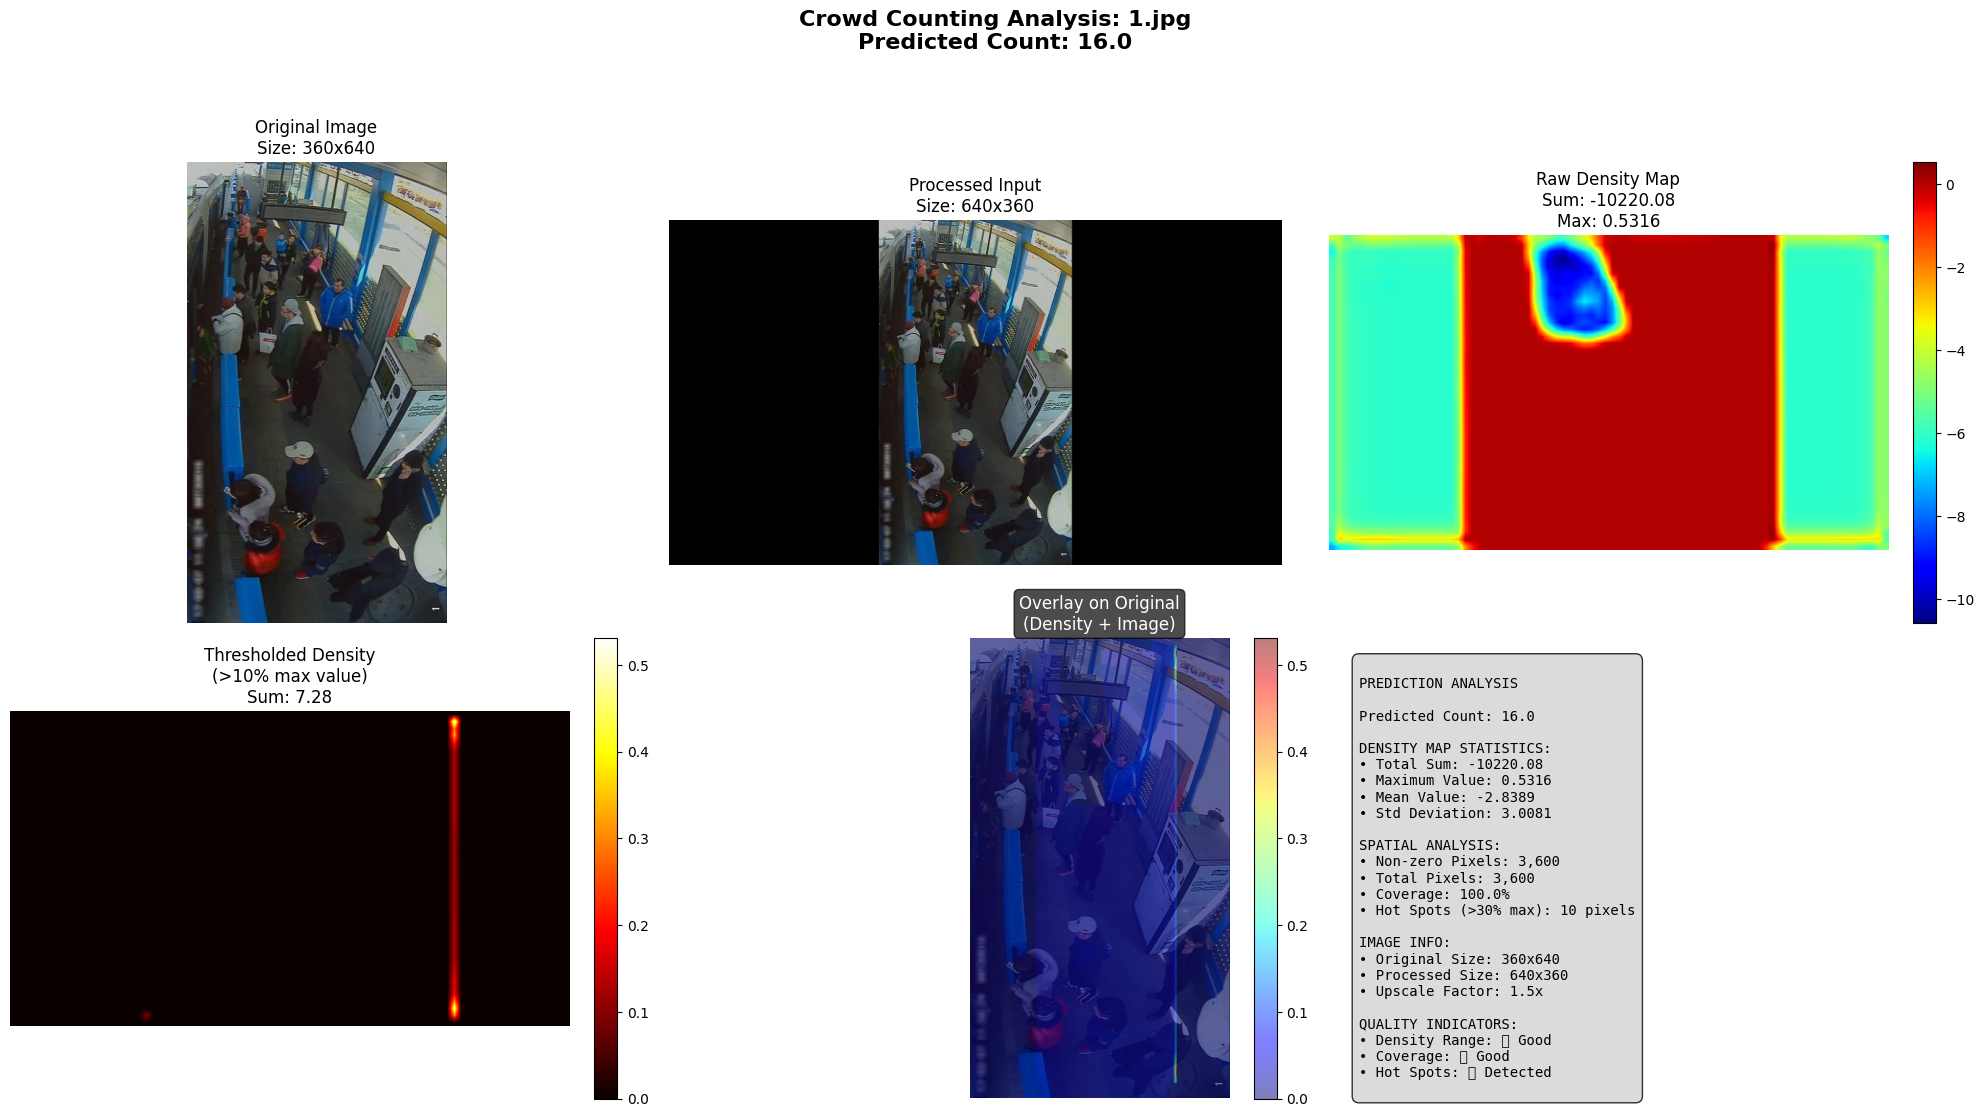


🔥 Creating density heatmap...
🔥 Heatmap saved to: single_image_analysis/1_heatmap.jpg


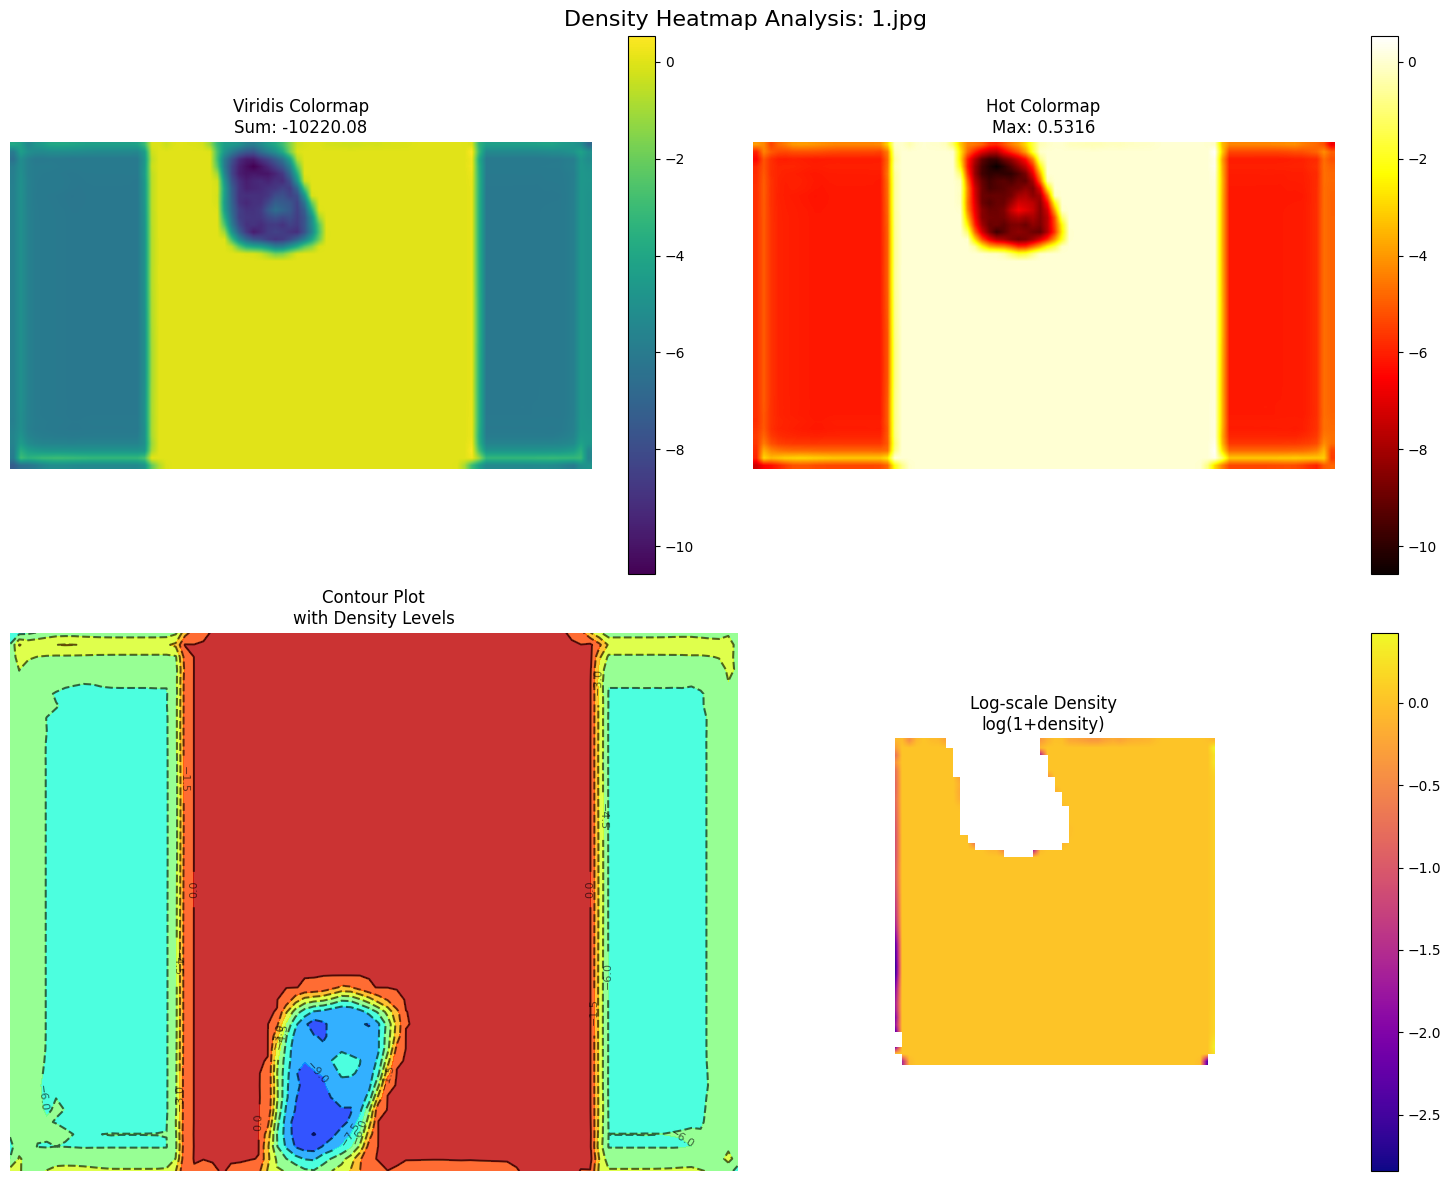


✅ Analysis completed!

🎯 FINAL RESULT: 16.0 people detected


In [9]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')

# Pastikan import model
# from your_model_file import ImprovedCSRNetV2

# ===================================================================
# SINGLE IMAGE PREDICTION & VISUALIZATION
# ===================================================================

class SingleImagePredictor:
    def __init__(self, model_path, device='auto'):
        """
        Initialize predictor untuk single image
        """
        # Device setup
        if device == 'auto':
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device(device)

        print(f"🔧 Using device: {self.device}")

        # Transform (same as training)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
        ])

        # Load model
        self.model = self._load_model(model_path)
        print("✅ Model loaded successfully!")

    def _load_model(self, model_path):
        """Load model dengan error handling"""
        try:
            model = ImprovedCSRNetV2(pretrained_frontend=True).to(self.device)
            state_dict = torch.load(model_path, map_location=self.device)
            model.load_state_dict(state_dict, strict=False)
            model.eval()
            return model
        except Exception as e:
            print(f"❌ Error loading ImprovedCSRNetV2: {e}")
            print("🔄 Trying fallback model...")
            try:
                model = ImprovedCSRNet().to(self.device)
                state_dict = torch.load(model_path, map_location=self.device)
                model.load_state_dict(state_dict, strict=False)
                model.eval()
                return model
            except Exception as e2:
                raise Exception(f"Failed to load any model: {e2}")

    def preprocess_image(self, img, target_size=(360, 640)):
        """
        Preprocess image dengan padding untuk maintain aspect ratio
        """
        target_h, target_w = target_size
        canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)

        orig_h, orig_w = img.shape[:2]
        scale = min(target_w / orig_w, target_h / orig_h)
        new_w, new_h = int(orig_w * scale), int(orig_h * scale)

        resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        x_offset = (target_w - new_w) // 2
        y_offset = (target_h - new_h) // 2
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_img

        return canvas, scale, (x_offset, y_offset, new_w, new_h)

    def predict_single_image(self, image_path, upscale_factor=1.5):
        """
        Predict count untuk single image
        """
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Cannot load image: {image_path}")

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_img = img_rgb.copy()

        # Optional upscaling
        if upscale_factor != 1.0:
            h, w = img_rgb.shape[:2]
            new_w, new_h = int(w * upscale_factor), int(h * upscale_factor)
            img_rgb = cv2.resize(img_rgb, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

        # Preprocess
        img_processed, scale, bbox = self.preprocess_image(img_rgb, target_size=(360, 640))
        img_tensor = self.transform(img_processed).unsqueeze(0).to(self.device)

        # Inference
        with torch.no_grad():
            outputs = self.model(img_tensor)

            # Handle different model outputs
            if isinstance(outputs, tuple) and len(outputs) >= 2:
                density_pred, count_pred = outputs[0], outputs[1]
                if count_pred is not None:
                    predicted_count = max(0, count_pred.item())
                else:
                    predicted_count = max(0, density_pred.sum().item())
            else:
                density_pred = outputs
                predicted_count = max(0, density_pred.sum().item())

        return {
            'original_image': original_img,
            'processed_image': img_processed,
            'density_map': density_pred.squeeze().cpu().numpy(),
            'predicted_count': predicted_count,
            'image_path': image_path,
            'scale_info': (scale, bbox),
            'upscale_factor': upscale_factor
        }

    def create_comprehensive_visualization(self, prediction_result, save_path=None, figsize=(20, 12)):
        """
        Create comprehensive visualization untuk evaluasi
        """
        original_img = prediction_result['original_image']
        processed_img = prediction_result['processed_image']
        density_map = prediction_result['density_map']
        predicted_count = prediction_result['predicted_count']
        image_path = prediction_result['image_path']

        # Setup figure dengan 6 subplots
        fig = plt.figure(figsize=figsize)
        fig.suptitle(f'Crowd Counting Analysis: {os.path.basename(image_path)}\nPredicted Count: {predicted_count:.1f}',
                    fontsize=16, fontweight='bold')

        # 1. Original Image
        plt.subplot(2, 3, 1)
        plt.imshow(original_img)
        plt.title(f'Original Image\nSize: {original_img.shape[1]}x{original_img.shape[0]}', fontsize=12)
        plt.axis('off')

        # 2. Processed Image (input to model)
        plt.subplot(2, 3, 2)
        plt.imshow(processed_img)
        plt.title(f'Processed Input\nSize: {processed_img.shape[1]}x{processed_img.shape[0]}', fontsize=12)
        plt.axis('off')

        # 3. Raw Density Map
        plt.subplot(2, 3, 3)
        density_plot = plt.imshow(density_map, cmap='jet', interpolation='bilinear')
        plt.title(f'Raw Density Map\nSum: {density_map.sum():.2f}\nMax: {density_map.max():.4f}', fontsize=12)
        plt.colorbar(density_plot, fraction=0.046, pad=0.04)
        plt.axis('off')

        # 4. Density Map dengan threshold
        plt.subplot(2, 3, 4)
        density_thresh = np.where(density_map > density_map.max() * 0.1, density_map, 0)
        thresh_plot = plt.imshow(density_thresh, cmap='hot', interpolation='bilinear')
        plt.title(f'Thresholded Density\n(>10% max value)\nSum: {density_thresh.sum():.2f}', fontsize=12)
        plt.colorbar(thresh_plot, fraction=0.046, pad=0.04)
        plt.axis('off')

        # 5. Overlay pada original
        plt.subplot(2, 3, 5)
        # Resize density map to original image size
        h, w = original_img.shape[:2]
        density_resized = cv2.resize(density_map, (w, h), interpolation=cv2.INTER_LINEAR)

        plt.imshow(original_img)
        overlay = plt.imshow(density_resized, cmap='jet', alpha=0.5,
                           vmin=0, vmax=density_map.max())
        plt.title('Overlay on Original\n(Density + Image)', fontsize=12, color='white',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7))
        plt.colorbar(overlay, fraction=0.046, pad=0.04)
        plt.axis('off')

        # 6. Analysis & Statistics
        plt.subplot(2, 3, 6)
        plt.axis('off')

        # Calculate statistics
        density_stats = {
            'Total Sum': f'{density_map.sum():.2f}',
            'Maximum': f'{density_map.max():.4f}',
            'Mean': f'{density_map.mean():.4f}',
            'Std Dev': f'{density_map.std():.4f}',
            'Non-zero pixels': f'{np.count_nonzero(density_map):,}',
            'Total pixels': f'{density_map.size:,}',
            'Coverage': f'{np.count_nonzero(density_map)/density_map.size*100:.1f}%'
        }

        # Hot spots analysis
        hot_spots = np.where(density_map > density_map.max() * 0.3)
        hot_spot_count = len(hot_spots[0])

        analysis_text = f"""
PREDICTION ANALYSIS

Predicted Count: {predicted_count:.1f}

DENSITY MAP STATISTICS:
• Total Sum: {density_stats['Total Sum']}
• Maximum Value: {density_stats['Maximum']}
• Mean Value: {density_stats['Mean']}
• Std Deviation: {density_stats['Std Dev']}

SPATIAL ANALYSIS:
• Non-zero Pixels: {density_stats['Non-zero pixels']}
• Total Pixels: {density_stats['Total pixels']}
• Coverage: {density_stats['Coverage']}
• Hot Spots (>30% max): {hot_spot_count:,} pixels

IMAGE INFO:
• Original Size: {original_img.shape[1]}x{original_img.shape[0]}
• Processed Size: {processed_img.shape[1]}x{processed_img.shape[0]}
• Upscale Factor: {prediction_result['upscale_factor']}x

QUALITY INDICATORS:
• Density Range: {"✅ Good" if density_map.max() > 0.001 else "⚠️ Low"}
• Coverage: {"✅ Good" if np.count_nonzero(density_map)/density_map.size > 0.01 else "⚠️ Sparse"}
• Hot Spots: {"✅ Detected" if hot_spot_count > 0 else "❌ None"}
        """

        plt.text(0.05, 0.95, analysis_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
            print(f"📸 Visualization saved to: {save_path}")

        plt.show()

        return fig

    def create_density_heatmap(self, prediction_result, save_path=None):
        """
        Create detailed density heatmap untuk fine analysis
        """
        density_map = prediction_result['density_map']
        predicted_count = prediction_result['predicted_count']
        image_path = prediction_result['image_path']

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Density Heatmap Analysis: {os.path.basename(image_path)}', fontsize=16)

        # 1. Original density
        im1 = axes[0,0].imshow(density_map, cmap='viridis', interpolation='bilinear')
        axes[0,0].set_title(f'Viridis Colormap\nSum: {density_map.sum():.2f}')
        plt.colorbar(im1, ax=axes[0,0])

        # 2. Hot colormap
        im2 = axes[0,1].imshow(density_map, cmap='hot', interpolation='bilinear')
        axes[0,1].set_title(f'Hot Colormap\nMax: {density_map.max():.4f}')
        plt.colorbar(im2, ax=axes[0,1])

        # 3. Contour plot
        X, Y = np.meshgrid(range(density_map.shape[1]), range(density_map.shape[0]))
        contour = axes[1,0].contour(X, Y, density_map, levels=10, colors='black', alpha=0.6)
        axes[1,0].contourf(X, Y, density_map, levels=10, cmap='jet', alpha=0.8)
        axes[1,0].clabel(contour, inline=True, fontsize=8)
        axes[1,0].set_title('Contour Plot\nwith Density Levels')

        # 4. 3D-like visualization
        density_log = np.log1p(density_map)  # log(1+x) to handle zeros
        im4 = axes[1,1].imshow(density_log, cmap='plasma', interpolation='bilinear')
        axes[1,1].set_title(f'Log-scale Density\nlog(1+density)')
        plt.colorbar(im4, ax=axes[1,1])

        for ax in axes.flat:
            ax.axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
            print(f"🔥 Heatmap saved to: {save_path}")

        plt.show()

        return fig

# ===================================================================
# USAGE FUNCTION
# ===================================================================
def predict_and_visualize_single_image(image_path, model_path, save_dir=None):
    """
    Main function untuk predict dan visualize single image

    Args:
        image_path: Path ke gambar yang akan diprediksi
        model_path: Path ke model (.pth file)
        save_dir: Directory untuk save visualizations (optional)
    """

    print(f"🖼️ Processing image: {image_path}")
    print(f"🤖 Using model: {model_path}")

    # Create save directory if specified
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        print(f"📁 Visualizations will be saved to: {save_dir}")

    # Initialize predictor
    predictor = SingleImagePredictor(model_path)

    # Predict
    print("🔍 Running prediction...")
    result = predictor.predict_single_image(image_path, upscale_factor=1.5)

    # Print prediction result
    print(f"\n📊 PREDICTION RESULT:")
    print(f"   Predicted Count: {result['predicted_count']:.1f} people")
    print(f"   Density Sum: {result['density_map'].sum():.2f}")
    print(f"   Density Max: {result['density_map'].max():.4f}")
    print(f"   Original Size: {result['original_image'].shape[1]}x{result['original_image'].shape[0]}")

    # Create visualizations
    img_name = os.path.splitext(os.path.basename(image_path))[0]

    print("\n🎨 Creating comprehensive visualization...")
    comprehensive_save_path = os.path.join(save_dir, f"{img_name}_comprehensive.jpg") if save_dir else None
    predictor.create_comprehensive_visualization(result, save_path=comprehensive_save_path)

    print("\n🔥 Creating density heatmap...")
    heatmap_save_path = os.path.join(save_dir, f"{img_name}_heatmap.jpg") if save_dir else None
    predictor.create_density_heatmap(result, save_path=heatmap_save_path)

    print(f"\n✅ Analysis completed!")

    return result

# ===================================================================
# EXAMPLE USAGE
# ===================================================================
if __name__ == "__main__":
    # ===== KONFIGURASI =====
    IMAGE_PATH = "/content/extracted_content/test/images/1.jpg"  # ← Ganti dengan path gambar Anda
    MODEL_PATH = "/content/optimal_model_checkpoints/best_csrnet.pth"  # ← Path ke model
    SAVE_DIR = "single_image_analysis"  # ← Directory untuk save hasil

    # ===== PREDIKSI & VISUALISASI =====
    try:
        result = predict_and_visualize_single_image(
            image_path=IMAGE_PATH,
            model_path=MODEL_PATH,
            save_dir=SAVE_DIR
        )

        print(f"\n🎯 FINAL RESULT: {result['predicted_count']:.1f} people detected")

    except Exception as e:
        print(f"❌ Error: {e}")
        print("\nTroubleshooting:")
        print("1. Pastikan path gambar benar")
        print("2. Pastikan model file exists")
        print("3. Pastikan model class sudah di-import")


# inference atau prediction ke data test

In [10]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from torchvision import transforms
from tqdm import tqdm

# Pastikan import model ImprovedCSRNetV2 dari file training
# from your_model_file import ImprovedCSRNetV2

# ------------------------------
# Paths
# ------------------------------
model_path = "/content/optimal_model_checkpoints/best_csrnet.pth"
test_img_dir = "/content/extracted_content/test/images"
output_csv = "predicted_counts.csv"

# ------------------------------
# Device
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------
# Transformasi image (sama dengan training)
# ------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ------------------------------
# Function: Upscale image sebelum preprocessing
# ------------------------------
def upscale_image(img, scale_factor=2):
    h, w = img.shape[:2]
    new_w = int(w * scale_factor)
    new_h = int(h * scale_factor)
    upscaled_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    return upscaled_img

# ------------------------------
# Function: Preprocess sama seperti training
# ------------------------------
def preprocess_image(img, target_size=(360, 640)):
    target_h, target_w = target_size
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)

    orig_h, orig_w = img.shape[:2]
    scale = min(target_w / orig_w, target_h / orig_h)
    new_w, new_h = int(orig_w * scale), int(orig_h * scale)

    resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_img

    return canvas

# ------------------------------
# Function: Robust prediction dengan handling berbagai output model
# ------------------------------
def predict_count(model, img_tensor):
    """
    Handle berbagai kemungkinan output dari model:
    - Single output (density_map)
    - Tuple dengan 2 outputs (density_map, count_pred)
    - Tuple dengan 3 outputs (density_map, count_pred, density_class)
    """
    with torch.no_grad():
        outputs = model(img_tensor)

        # Handle berbagai format output
        if isinstance(outputs, tuple):
            if len(outputs) == 3:
                # ImprovedCSRNetV2: (density_map, count_pred, density_class)
                density_map, count_pred, density_class = outputs

                # Prioritas: gunakan count_pred jika ada, fallback ke density sum
                if count_pred is not None:
                    count = count_pred.item() if count_pred.dim() > 0 else count_pred
                else:
                    count = density_map.sum().item()

            elif len(outputs) == 2:
                # Format: (density_map, count_pred)
                density_map, count_pred = outputs

                if count_pred is not None:
                    count = count_pred.item() if count_pred.dim() > 0 else count_pred
                else:
                    count = density_map.sum().item()
            else:
                # Unexpected tuple format, use first element
                density_map = outputs[0]
                count = density_map.sum().item()
        else:
            # Single output (density_map only)
            density_map = outputs
            count = density_map.sum().item()

    # Ensure non-negative count
    count = max(0, count)

    return count

# ------------------------------
# Function: Multi-scale prediction untuk akurasi lebih baik
# ------------------------------
def predict_with_multi_scale(model, img, scales=[1.0, 1.5, 2.0]):
    """
    Prediksi dengan multiple scales dan rata-rata hasilnya
    """
    predictions = []

    for scale in scales:
        # Apply scale
        if scale != 1.0:
            img_scaled = upscale_image(img, scale_factor=scale)
        else:
            img_scaled = img.copy()

        # Preprocess
        img_processed = preprocess_image(img_scaled, target_size=(360, 640))
        img_tensor = transform(img_processed).unsqueeze(0).to(device)

        # Predict
        count = predict_count(model, img_tensor)
        predictions.append(count)

    # Return weighted average (memberikan bobot lebih pada scale yang lebih besar)
    weights = np.array([1.0, 1.2, 1.5])[:len(scales)]  # Bias towards higher scales
    weighted_pred = np.average(predictions, weights=weights)

    return weighted_pred

# ------------------------------
# Load Model
# ------------------------------
print("🔄 Loading model...")
try:
    model = ImprovedCSRNetV2(pretrained_frontend=True).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit(1)

# ------------------------------
# Prepare test images
# ------------------------------
valid_ext = [".jpg", ".jpeg", ".png", ".bmp", ".JPG", ".JPEG", ".PNG", ".BMP"]
img_files = sorted([f for f in os.listdir(test_img_dir)
                   if os.path.splitext(f)[1] in valid_ext])

print(f"📁 Found {len(img_files)} test images")

if len(img_files) == 0:
    print("❌ No valid images found!")
    exit(1)

# ------------------------------
# Prediction dengan progress bar
# ------------------------------
predictions = []
failed_images = []

print("🔍 Starting prediction...")
for img_file in tqdm(img_files, desc="Predicting"):
    try:
        img_path = os.path.join(test_img_dir, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"⚠️ Warning: Could not read {img_file}")
            failed_images.append(img_file)
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ======= ENHANCED PREDICTION =======

        # Option 1: Single scale prediction (faster)
        # img_upscaled = upscale_image(img, scale_factor=2)
        # img_processed = preprocess_image(img_upscaled, target_size=(360, 640))
        # img_tensor = transform(img_processed).unsqueeze(0).to(device)
        # count = predict_count(model, img_tensor)

        # Option 2: Multi-scale prediction (more accurate)
        count = predict_with_multi_scale(model, img, scales=[1.0, 1.5, 2.0])

        # Format sesuai kebutuhan submit
        predictions.append({
            "image_id": img_file,
            "predicted_count": round(count, 2)  # 2 decimal places
        })

    except Exception as e:
        print(f"❌ Error processing {img_file}: {e}")
        failed_images.append(img_file)
        continue

# ------------------------------
# Validation & Debugging
# ------------------------------
if len(predictions) == 0:
    print("❌ No successful predictions!")
    exit(1)

# Show statistics
counts = [p["predicted_count"] for p in predictions]
print(f"\n📊 Prediction Statistics:")
print(f"   Total images processed: {len(predictions)}")
print(f"   Failed images: {len(failed_images)}")
print(f"   Count range: [{min(counts):.2f}, {max(counts):.2f}]")
print(f"   Average count: {np.mean(counts):.2f}")
print(f"   Median count: {np.median(counts):.2f}")

# Show some sample predictions
print(f"\n🔍 Sample predictions:")
for i, pred in enumerate(predictions[:5]):
    print(f"   {pred['image_id']}: {pred['predicted_count']}")

if failed_images:
    print(f"\n⚠️ Failed to process: {failed_images}")

# ------------------------------
# Simpan ke CSV - EXACT format sesuai kebutuhan submit
# ------------------------------
try:
    df = pd.DataFrame(predictions)

    # Ensure columns are in correct order
    df = df[["image_id", "predicted_count"]]

    # Save to CSV
    df.to_csv(output_csv, index=False)

    # Verify CSV format
    print(f"\n✅ Predictions saved to {output_csv}")
    print(f"📄 CSV Preview:")
    print(df.head())
    print(f"\n📋 CSV Info:")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Data types: {df.dtypes.to_dict()}")

except Exception as e:
    print(f"❌ Error saving CSV: {e}")

print("\n🎉 Inference completed!")

# ------------------------------
# Optional: Quick validation
# ------------------------------
# Verify CSV dapat dibaca kembali
try:
    df_verify = pd.read_csv(output_csv)
    assert len(df_verify) == len(predictions), "CSV length mismatch!"
    assert list(df_verify.columns) == ["image_id", "predicted_count"], "CSV columns mismatch!"
    print("✅ CSV validation passed!")
except Exception as e:
    print(f"❌ CSV validation failed: {e}")


Using device: cuda
🔄 Loading model...
✅ Loaded pretrained VGG16 weights for frontend
✅ Model loaded successfully!
📁 Found 500 test images
🔍 Starting prediction...


Predicting: 100%|██████████| 500/500 [00:56<00:00,  8.90it/s]


📊 Prediction Statistics:
   Total images processed: 500
   Failed images: 0
   Count range: [2.54, 147.44]
   Average count: 46.58
   Median count: 25.78

🔍 Sample predictions:
   1.jpg: 15.87
   10.jpg: 80.94
   100.jpg: 120.48
   101.jpg: 3.74
   102.jpg: 54.99

✅ Predictions saved to predicted_counts.csv
📄 CSV Preview:
  image_id  predicted_count
0    1.jpg            15.87
1   10.jpg            80.94
2  100.jpg           120.48
3  101.jpg             3.74
4  102.jpg            54.99

📋 CSV Info:
   Shape: (500, 2)
   Columns: ['image_id', 'predicted_count']
   Data types: {'image_id': dtype('O'), 'predicted_count': dtype('float64')}

🎉 Inference completed!
✅ CSV validation passed!
